# Carbon Credit Projects in India: Regression Analysis

**Author:** Anvith  
**Date:** May 2025  
**Version:** 1.0

## Purpose
This notebook performs regression analysis to identify the determinants of success in CDM and VCS carbon credit projects in India. The analysis builds on the descriptive findings from Notebook 2 and uses multivariate models to isolate the effects of different factors on project performance.

## Input Data
- `vcs_fully_categorized.csv`: Processed dataset with all variables needed for analysis

## Output Files
- `model_overall_results.txt`: Results from the overall regression model
- `model_tech_results_*.txt`: Results from technology-specific models
- `model_regime_results_*.txt`: Results from regime-specific models
- `model_stepwise_results.txt`: Results from stepwise regression
- Various visualization files (PNG format)

## Dependencies
- pandas
- numpy
- matplotlib
- seaborn
- statsmodels

In [48]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

# For regression analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.regressionplots import plot_leverage_resid2

# For model selection
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

# Set matplotlib to display plots inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Create directories for outputs if they don't exist
os.makedirs('../output', exist_ok=True)
os.makedirs('../output/figures', exist_ok=True)
os.makedirs('../output/tables', exist_ok=True)
os.makedirs('../output/models', exist_ok=True)

# Helper function for file paths
def get_path(file_name, directory=None):
    """
    Get standardized file path.
    
    Parameters:
    -----------
    file_name : str
        Name of the file
    directory : str or None
        Subdirectory (default: None, for root project directory)
        
    Returns:
    --------
    str
        Full file path
    """
    if directory is None:
        return file_name
    else:
        return os.path.join(directory, file_name)

# Progress tracking function
def log_progress(step, message):
    """Log progress with timestamp"""
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print(f"[{timestamp}] {step}: {message}")

In [49]:
###################
# PARAMETERS
###################

# File paths
DATA_DIR = '../output'  # Use output from notebook 1 as input
OUTPUT_DIR = '../output'  # Parent directory for output files
FIGURES_DIR = os.path.join(OUTPUT_DIR, 'figures')
TABLES_DIR = os.path.join(OUTPUT_DIR, 'tables')
MODELS_DIR = os.path.join(OUTPUT_DIR, 'models')

# Input and output files
INPUT_FILE = os.path.join(DATA_DIR, 'combined_projects_categorized.csv')
MODEL_OVERALL_RESULTS = os.path.join(MODELS_DIR, 'model_overall_results.txt')
MODEL_STEPWISE_RESULTS = os.path.join(MODELS_DIR, 'model_stepwise_results.txt')

# Figure output paths
FIG_RESIDUALS = os.path.join(FIGURES_DIR, 'model_residuals.png')
FIG_PREDICTED_VS_ACTUAL = os.path.join(FIGURES_DIR, 'predicted_vs_actual.png')
FIG_COEFFICIENT_PLOT = os.path.join(FIGURES_DIR, 'coefficient_plot.png')
FIG_LEVERAGE_PLOT = os.path.join(FIGURES_DIR, 'leverage_plot.png')
FIG_VIF_PLOT = os.path.join(FIGURES_DIR, 'vif_plot.png')
FIG_RESIDUAL_QQ = os.path.join(FIGURES_DIR, 'residual_qq_plot.png')
FIG_REGIME_COEF_COMPARE = os.path.join(FIGURES_DIR, 'regime_coefficient_comparison.png')
FIG_TECH_COEF_COMPARE = os.path.join(FIGURES_DIR, 'tech_coefficient_comparison.png')

# Analysis parameters
MIN_COUNT_FOR_MODEL = 30  # Minimum observations for running a separate model
VIF_THRESHOLD = 10  # Threshold for concerning multicollinearity
MAX_P_VALUE = 0.05  # Maximum p-value for statistical significance
BASE_TECH_CATEGORY = 'Wind'  # Base category for technology dummies
MIN_COUNT_FOR_TECH_MODEL = 50  # Minimum observations for technology-specific model

# Visualization settings
plt.style.use('seaborn-v0_8')  # Use compatible style
sns.set_context("paper", font_scale=1.5)

## 1. Data Loading and Preparation

This section loads the data and prepares it for regression analysis.

In [50]:
# Load the fully categorized dataset
log_progress("Data Loading", "Starting to load data")
df = pd.read_csv(INPUT_FILE)
log_progress("Data Loading", f"Completed - loaded {len(df)} projects")

# Filter for projects with valid success indicators
df_valid = df.dropna(subset=['log_q_success_indicator'])
log_progress("Data Filtering", f"Filtered to {len(df_valid)} projects with valid success indicators")

# Display basic information about the dataset
print(f"Combined dataset contains {len(df_valid)} projects with valid success indicators")
print(f"  VCS projects: {(df_valid['Regime'] == 'VCS').sum()}")
print(f"  CDM projects: {(df_valid['Regime'] == 'CDM').sum()}")

# Define the dependent variable
y_var = 'log_q_success_indicator'

# Create dummy variable for CDM (for regression)
df_valid['Is_CDM'] = (df_valid['Regime'] == 'CDM').astype(int)

# Ensure log_t_actual_years is available
if 'log_t_actual_years' not in df_valid.columns:
    df_valid['log_t_actual_years'] = np.log(df_valid['t_actual_years'])

# Check for outliers in the dependent variable
z_scores = np.abs((df_valid[y_var] - df_valid[y_var].mean()) / df_valid[y_var].std())
outliers_mask = z_scores > 3
num_outliers = outliers_mask.sum()

print(f"\nPotential outliers in {y_var} (z-score > 3): {num_outliers}")
if num_outliers > 0:
    print("Outlier values:")
    print(df_valid.loc[outliers_mask, [y_var, 'Technology_Category', 'Regime']].head())

# Create a version of the dataset without outliers for sensitivity analysis
df_no_outliers = df_valid[~outliers_mask].copy()

# Identify predictors for regression
numeric_predictors = ['log_t_actual_years', 'Scale_Large', 'Is_International', 'Is_CDM']
categorical_predictors = ['Technology_Category']  # Will be converted to dummies

# Get technology dummy variables (if not already created)
tech_dummies = pd.get_dummies(df_valid['Technology_Category'], prefix='Tech', drop_first=False)

tech_dummies.columns = (
    tech_dummies.columns
    .str.strip()
    .str.replace(' ', '_')
    .str.replace('[^0-9a-zA-Z_]', '', regex=True)
)

# Merge into df_valid correctly
df_valid = df_valid.drop(columns=[col for col in df_valid.columns if col.startswith("Tech_")], errors='ignore')
df_valid = pd.concat([df_valid, tech_dummies], axis=1)
print('df_valid.columns', df_valid.columns)

# Ensure the base category is dropped
if f'Tech_{BASE_TECH_CATEGORY}' in tech_dummies.columns:
    tech_dummies = tech_dummies.drop(f'Tech_{BASE_TECH_CATEGORY}', axis=1)
    print(f"\nTechnology base category: {BASE_TECH_CATEGORY}")
else:
    # If base category not found, use the first category as base
    first_tech = tech_dummies.columns[0]
    tech_dummies = tech_dummies.drop(first_tech, axis=1)
    print(f"\nBase technology category not found. Using {first_tech.replace('Tech_', '')} as base.")

# Add dummies to main dataframe if not already there
#tech_dummy_cols = [col for col in tech_dummies.columns]
tech_dummy_cols = list(tech_dummies.columns)
missing_dummies = [col for col in tech_dummy_cols if col not in df_valid.columns]

if missing_dummies:
    print(f"Adding {len(missing_dummies)} technology dummy variables to dataset")
    for col in missing_dummies:
        tech_name = col.replace('Tech_', '')
        df_valid[col] = (df_valid['Technology_Category'] == tech_name).astype(int)

# List all predictor variables for the model
predictor_vars = numeric_predictors + tech_dummy_cols
print(f"\nPredictor variables for regression models: {len(predictor_vars)}")
for i, var in enumerate(predictor_vars):
    print(f"  {i+1}: {var}")

# Create interaction terms between regime and key predictors
df_valid['Is_CDM_x_log_t'] = df_valid['Is_CDM'] * df_valid['log_t_actual_years']
df_valid['Is_CDM_x_Scale'] = df_valid['Is_CDM'] * df_valid['Scale_Large']
df_valid['Is_CDM_x_Intl'] = df_valid['Is_CDM'] * df_valid['Is_International']

interaction_vars = ['Is_CDM_x_log_t', 'Is_CDM_x_Scale', 'Is_CDM_x_Intl']

# Prepare datasets for different models
df_vcs = df_valid[df_valid['Regime'] == 'VCS'].copy()
df_cdm = df_valid[df_valid['Regime'] == 'CDM'].copy()

print(f"\nVCS dataset: {len(df_vcs)} projects")
print(f"CDM dataset: {len(df_cdm)} projects")

# Check if we have enough observations for separate models
enough_vcs = len(df_vcs) >= MIN_COUNT_FOR_MODEL
enough_cdm = len(df_cdm) >= MIN_COUNT_FOR_MODEL

if enough_vcs:
    print("Sufficient VCS projects for separate model")
else:
    print("Insufficient VCS projects for separate model")

if enough_cdm:
    print("Sufficient CDM projects for separate model")
else:
    print("Insufficient CDM projects for separate model")

# Technology-specific datasets
tech_datasets = {}
for tech in df_valid['Technology_Category'].unique():
    tech_df = df_valid[df_valid['Technology_Category'] == tech].copy()
    if len(tech_df) >= MIN_COUNT_FOR_TECH_MODEL:
        tech_datasets[tech] = tech_df
        print(f"{tech} dataset: {len(tech_df)} projects (sufficient for model)")
    else:
        print(f"{tech} dataset: {len(tech_df)} projects (insufficient for model)")

[2025-05-10 00:49:44] Data Loading: Starting to load data
[2025-05-10 00:49:44] Data Loading: Completed - loaded 1978 projects
[2025-05-10 00:49:44] Data Filtering: Filtered to 792 projects with valid success indicators
Combined dataset contains 792 projects with valid success indicators
  VCS projects: 293
  CDM projects: 499

Potential outliers in log_q_success_indicator (z-score > 3): 15
Outlier values:
   log_q_success_indicator Technology_Category Regime
0                -7.063231   Biomass and Waste    VCS
1                -8.398589     Other Renewable    VCS
2               -10.256815   Biomass and Waste    VCS
7                -8.396572               Other    VCS
8                -5.354454   Energy Efficiency    VCS
df_valid.columns Index(['ID', 'Name', 'Proponent', 'Project Type', 'AFOLU Activities',
       'Methodology', 'Status', 'Country/Area',
       'Estimated Annual Emission Reductions', 'Region',
       'Project Registration Date', 'Crediting Period Start Date',
       

C:\Users\DELL\AppData\Local\Temp\ipykernel_4576\1294316128.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Is_CDM'] = (df_valid['Regime'] == 'CDM').astype(int)
C:\Users\DELL\AppData\Local\Temp\ipykernel_4576\1294316128.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['log_t_actual_years'] = np.log(df_valid['t_actual_years'])


## 2. Overall Regression Models

This section develops regression models for the entire dataset to identify the main determinants of project success.

[2025-05-10 00:49:55] Overall Regression: Starting analysis
🔍 Duplicate columns: []

Model 1: Base Model (All Projects) Results:
Observations: 792.0
R-squared: 0.1148
Adjusted R-squared: 0.1023
F-statistic: 9.20 (p-value: 0.0000)
AIC: 2498.17
BIC: 2554.27

Coefficients:
                                Coefficient  Std Error   t-value   p-value  \
log_t_actual_years                -0.214734   0.048066 -4.467526  0.000009   
Tech_Biomass_and_Waste[T.True]    -0.389861   0.134264 -2.903690  0.003792   
Is_CDM                             0.707609   0.271411  2.607148  0.009304   
Scale_Large                       -0.279854   0.120162 -2.328976  0.020115   
Tech_Other[T.True]                 0.309881   0.164899  1.879216  0.060588   
Tech_Energy_Efficiency[T.True]    -0.369004   0.238767 -1.545453  0.122642   
Intercept                         -0.207619   0.190932 -1.087395  0.277198   
Tech_Hydro[T.True]                -0.091606   0.175009 -0.523435  0.600821   
Is_International           

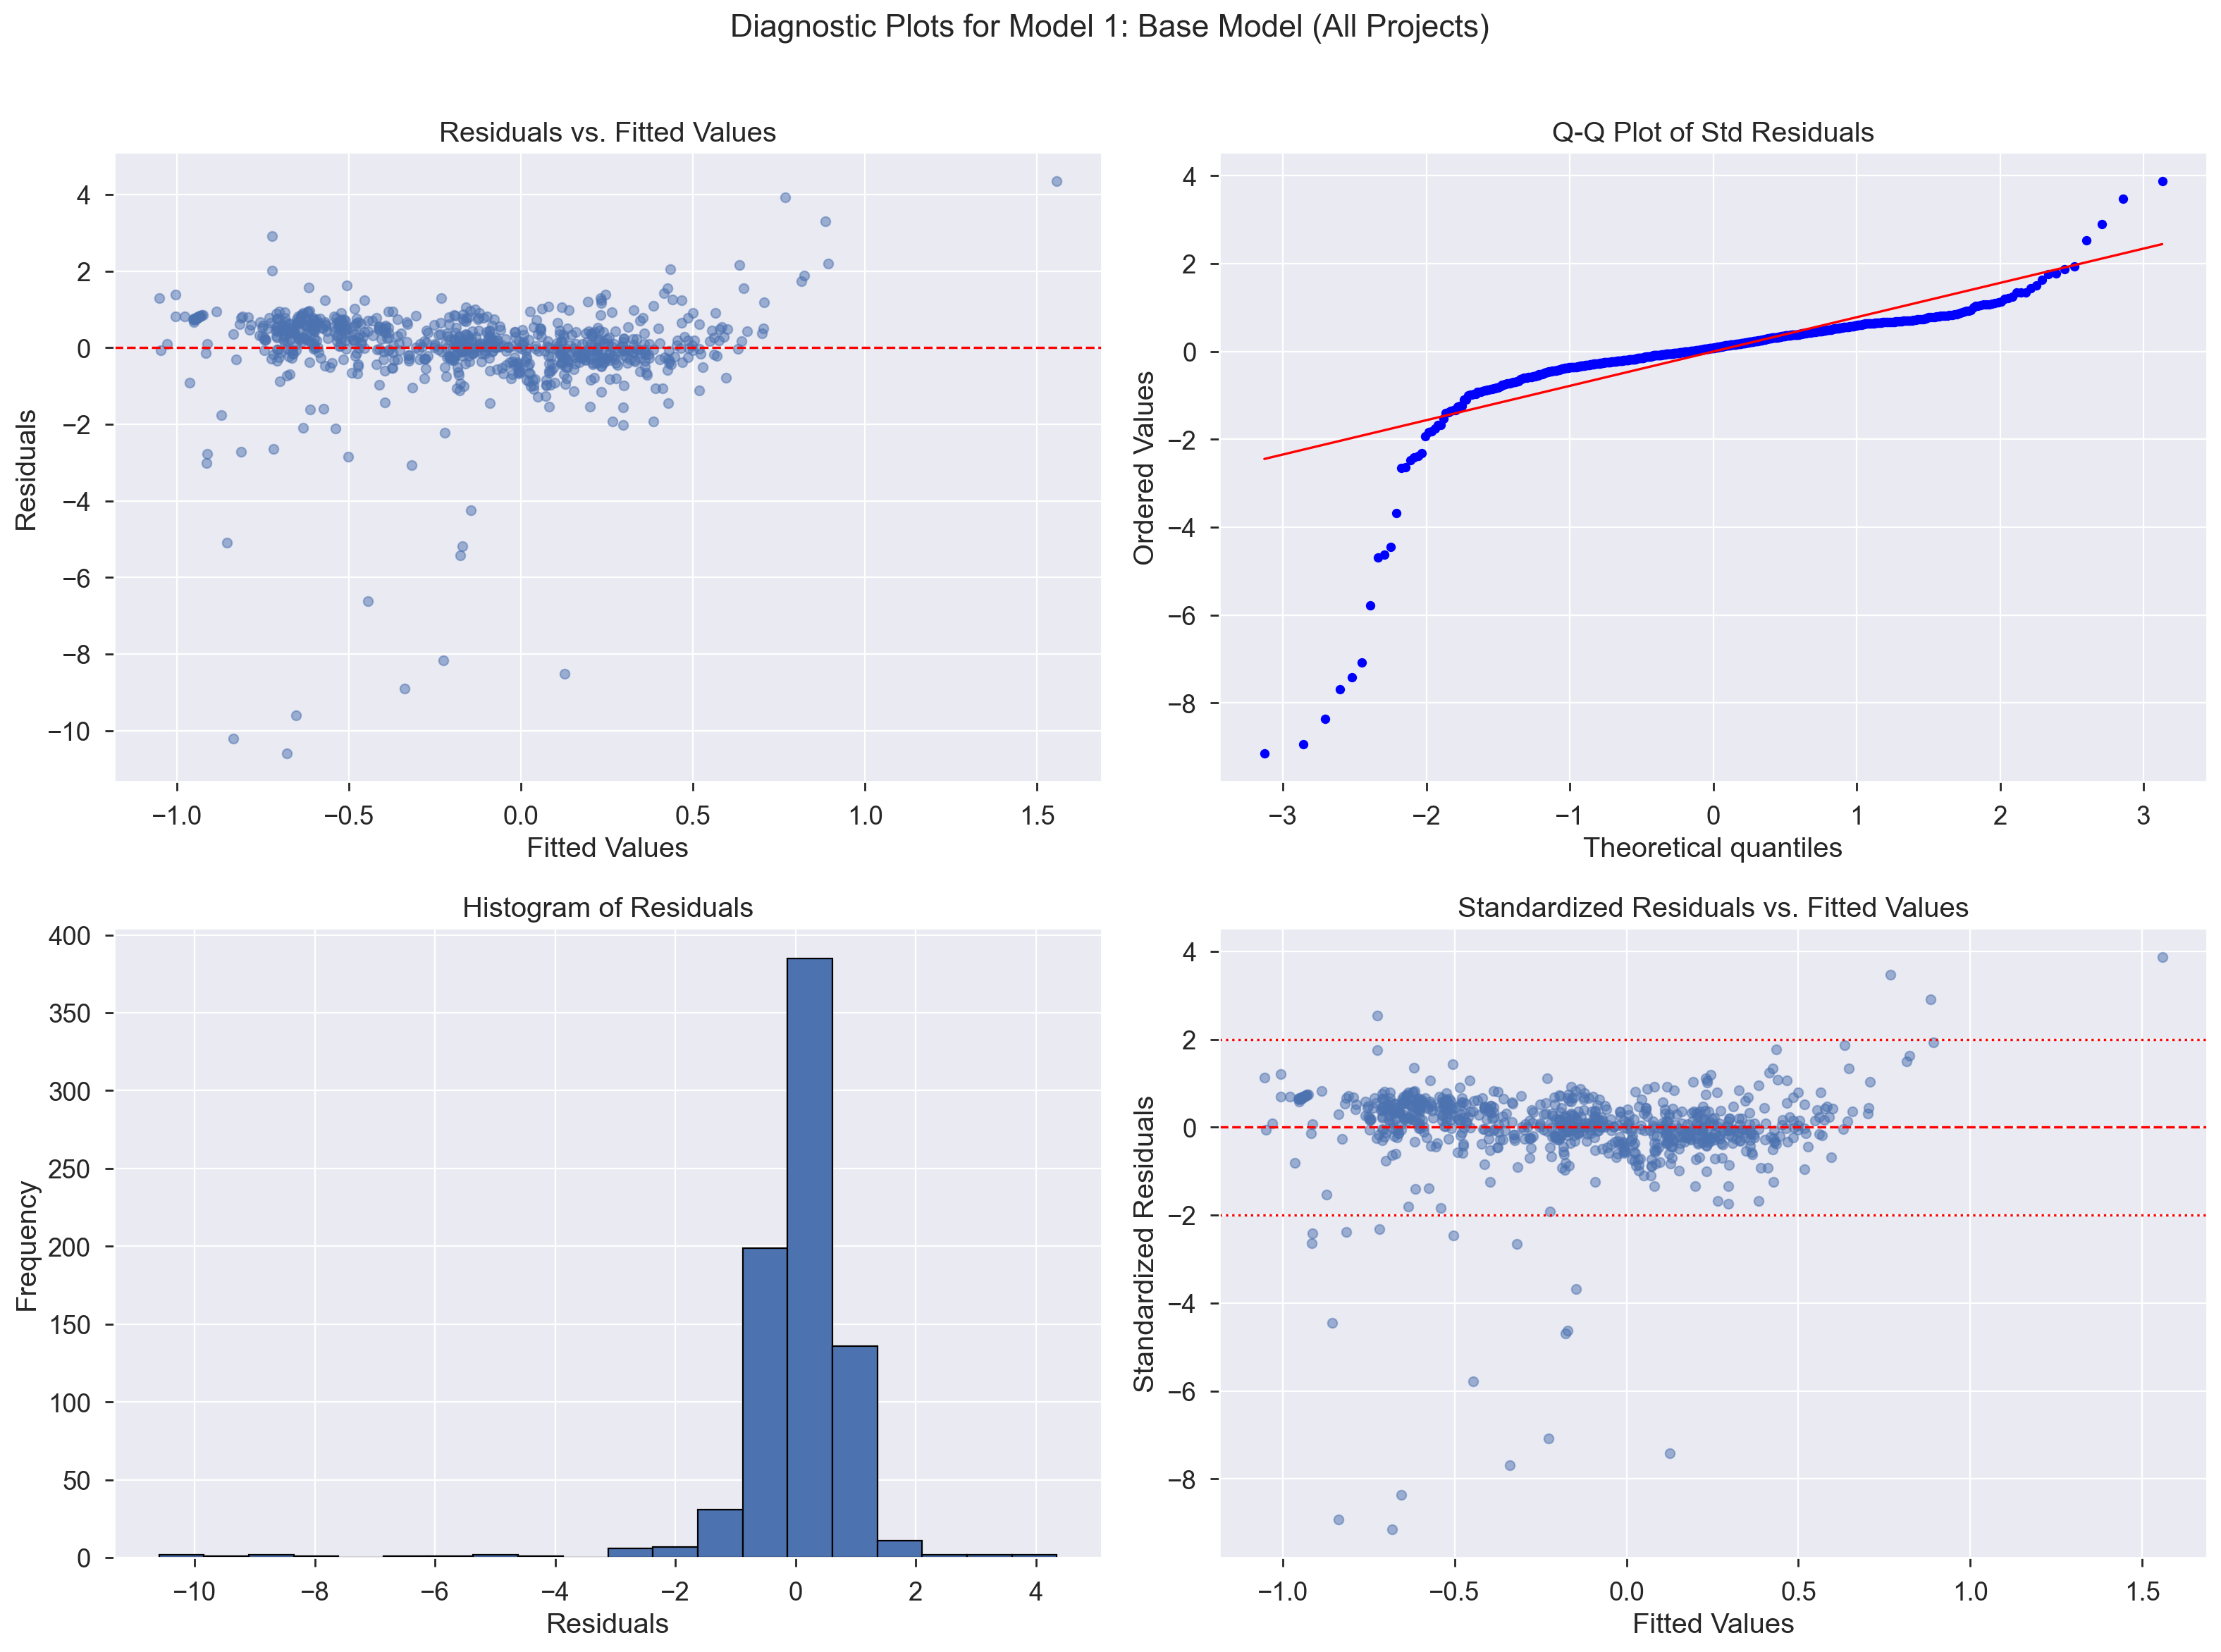

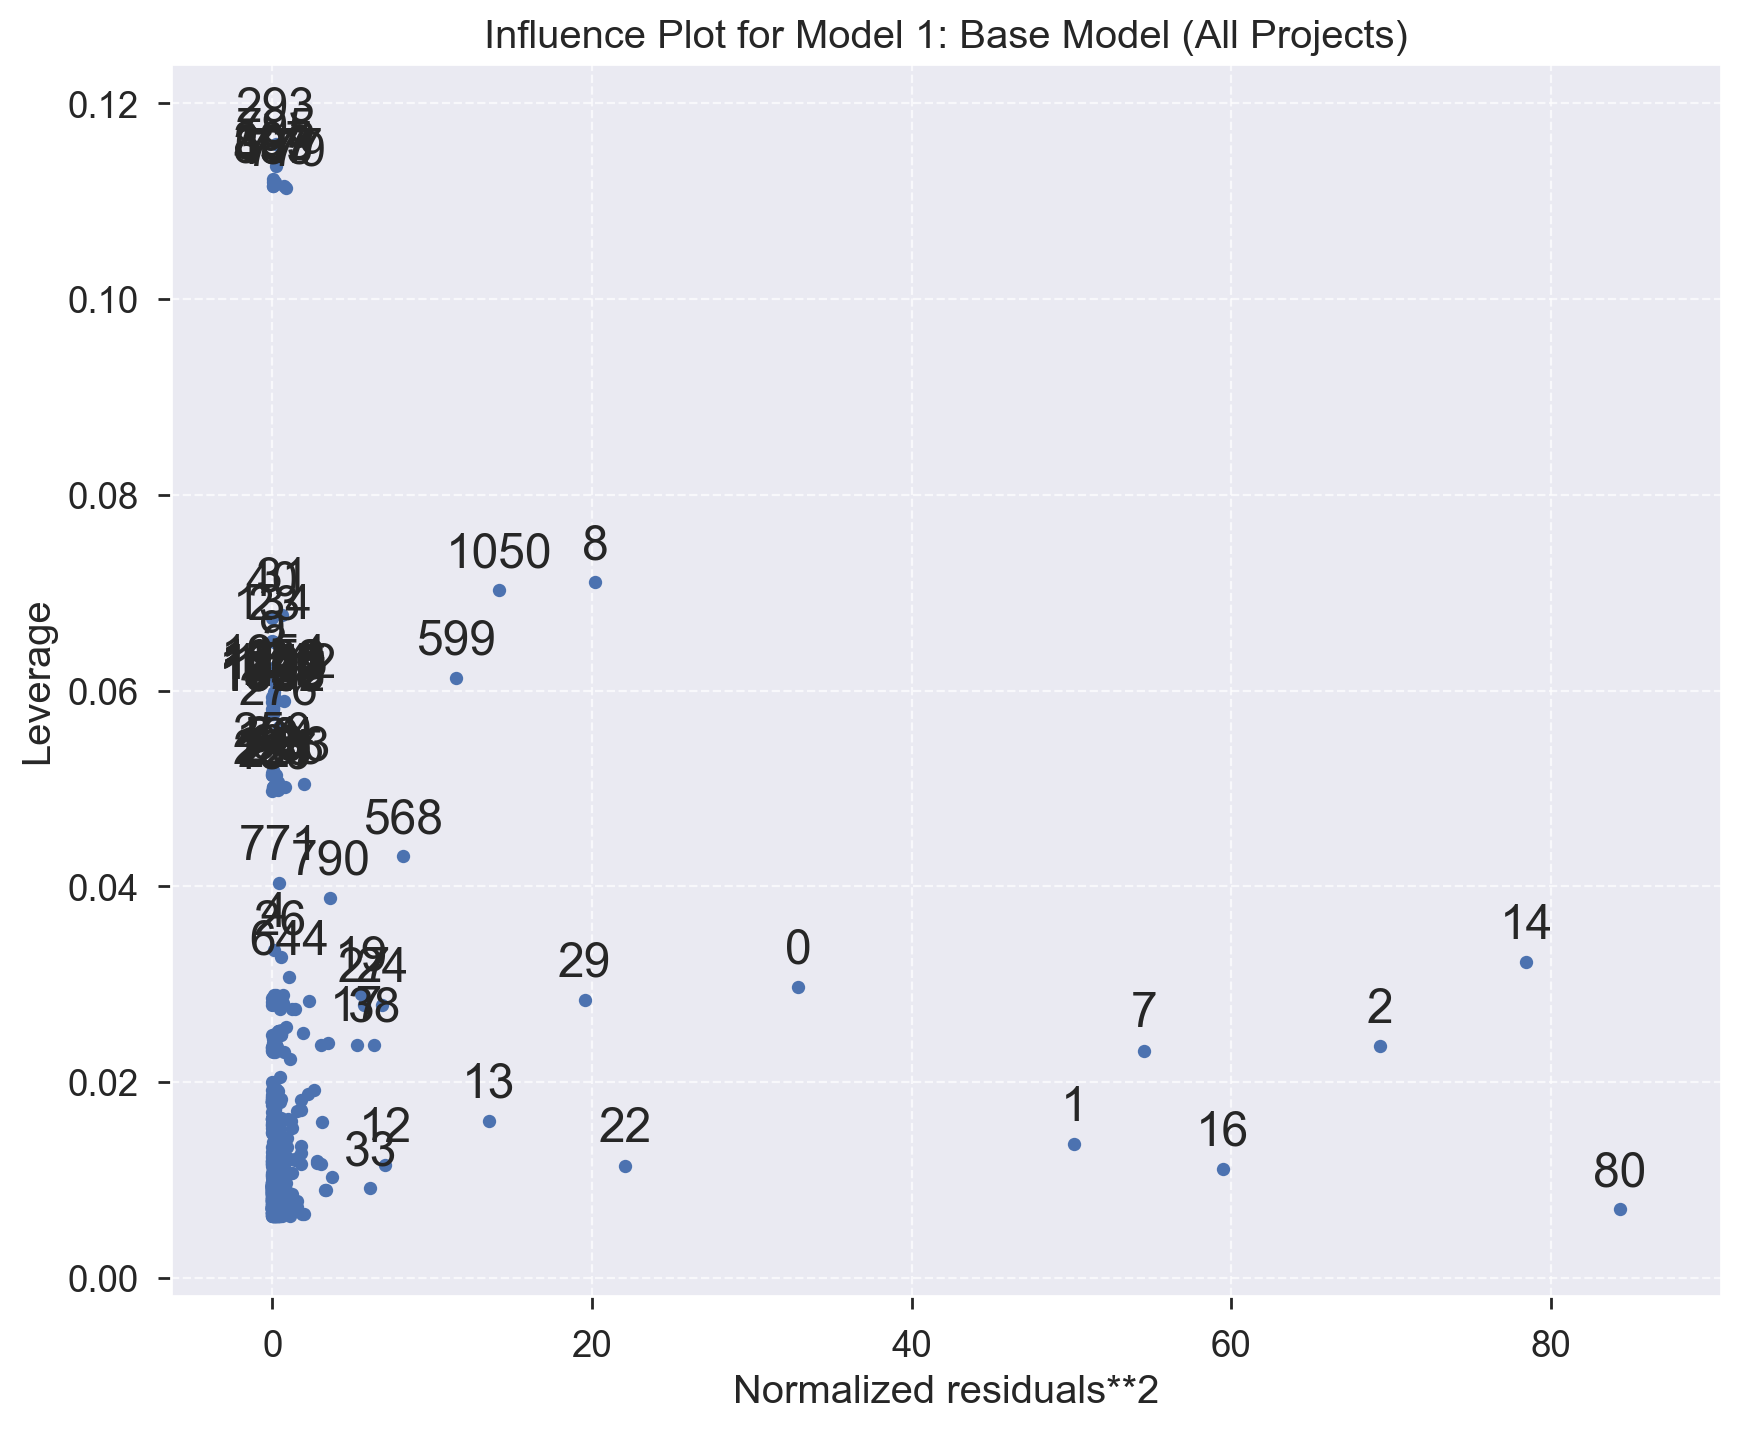


Model 2: Interaction Model (All Projects) Results:
Observations: 792.0
R-squared: 0.3026
Adjusted R-squared: 0.2910
F-statistic: 25.97 (p-value: 0.0000)
AIC: 2313.26
BIC: 2378.71

Coefficients:
                                Coefficient  Std Error    t-value  \
Is_CDM_x_log_t                    -1.350478   0.093381 -14.461962   
log_t_actual_years                 0.735203   0.078300   9.389626   
Is_CDM                             1.299976   0.149266   8.709143   
Is_CDM_x_Intl                      1.299976   0.149266   8.709143   
Intercept                         -1.892505   0.237447  -7.970226   
Tech_Biomass_and_Waste[T.True]    -0.364767   0.119367  -3.055851   
Is_International                   0.469952   0.232132   2.024504   
Tech_Energy_Efficiency[T.True]     0.410656   0.226950   1.809457   
Is_CDM_x_Scale                    -0.278956   0.206626  -1.350053   
Tech_Industrial_Gases[T.True]     -0.288812   0.358254  -0.806166   
Tech_Other[T.True]                 0.065008   

c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


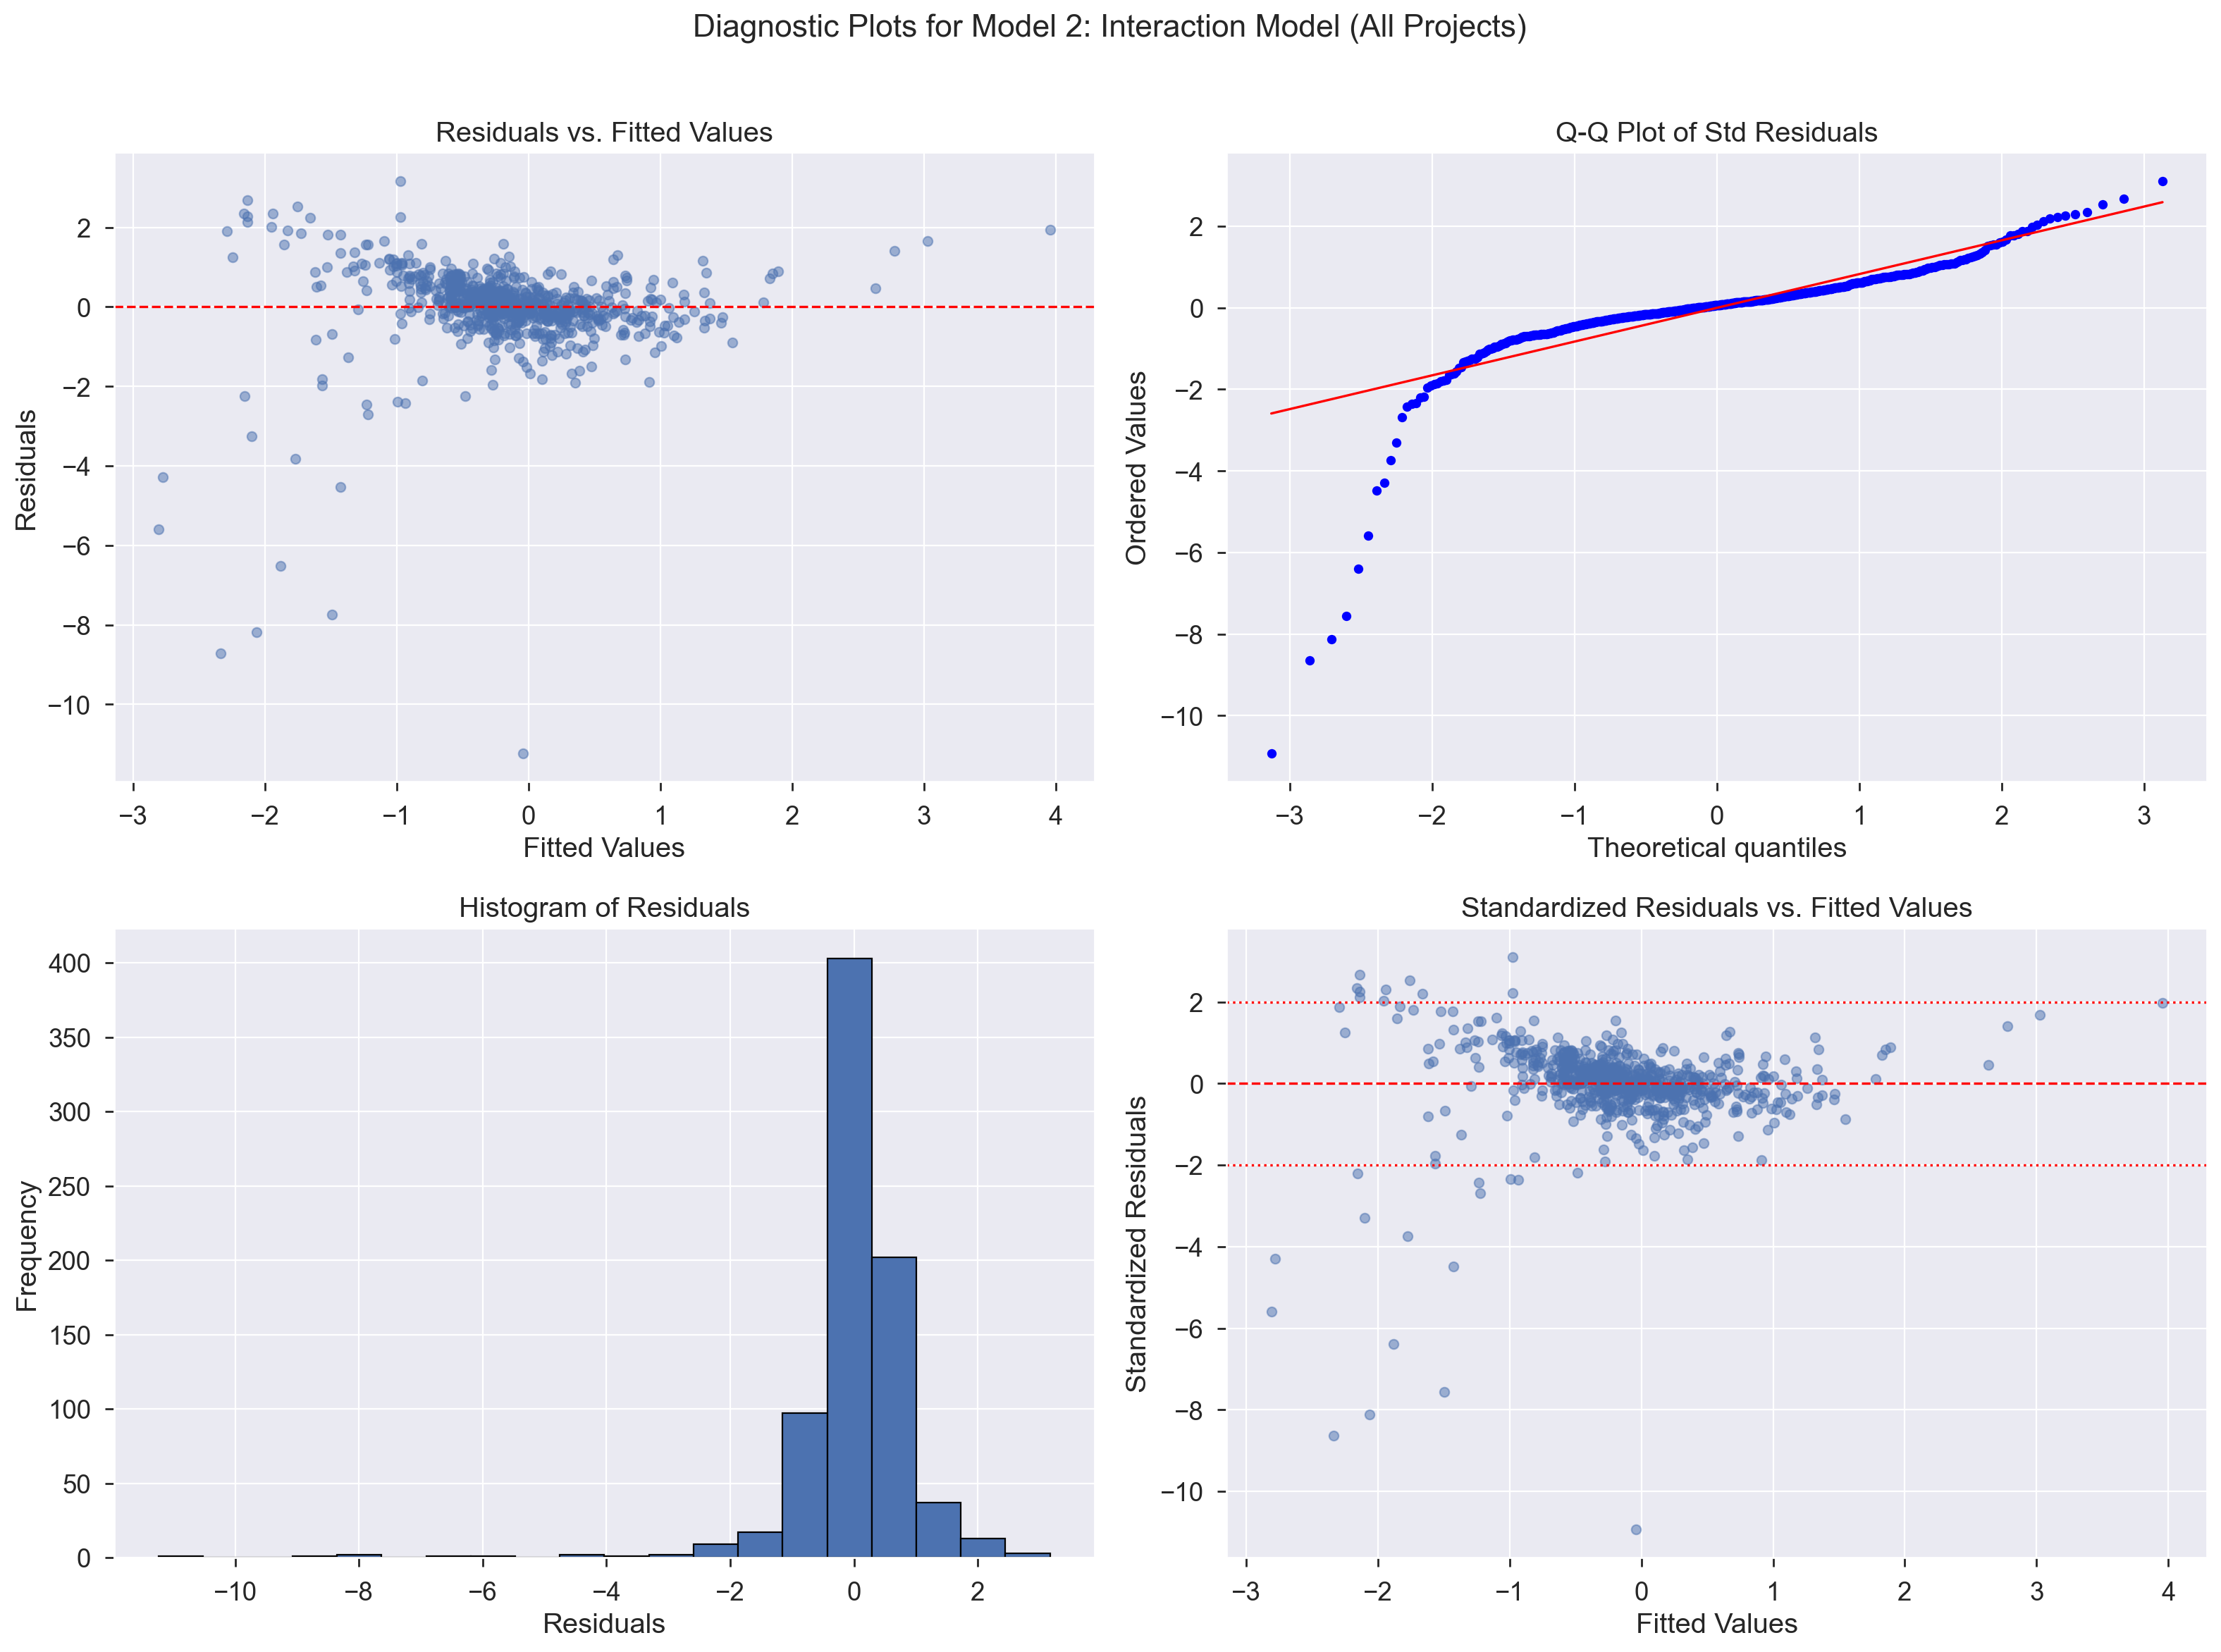

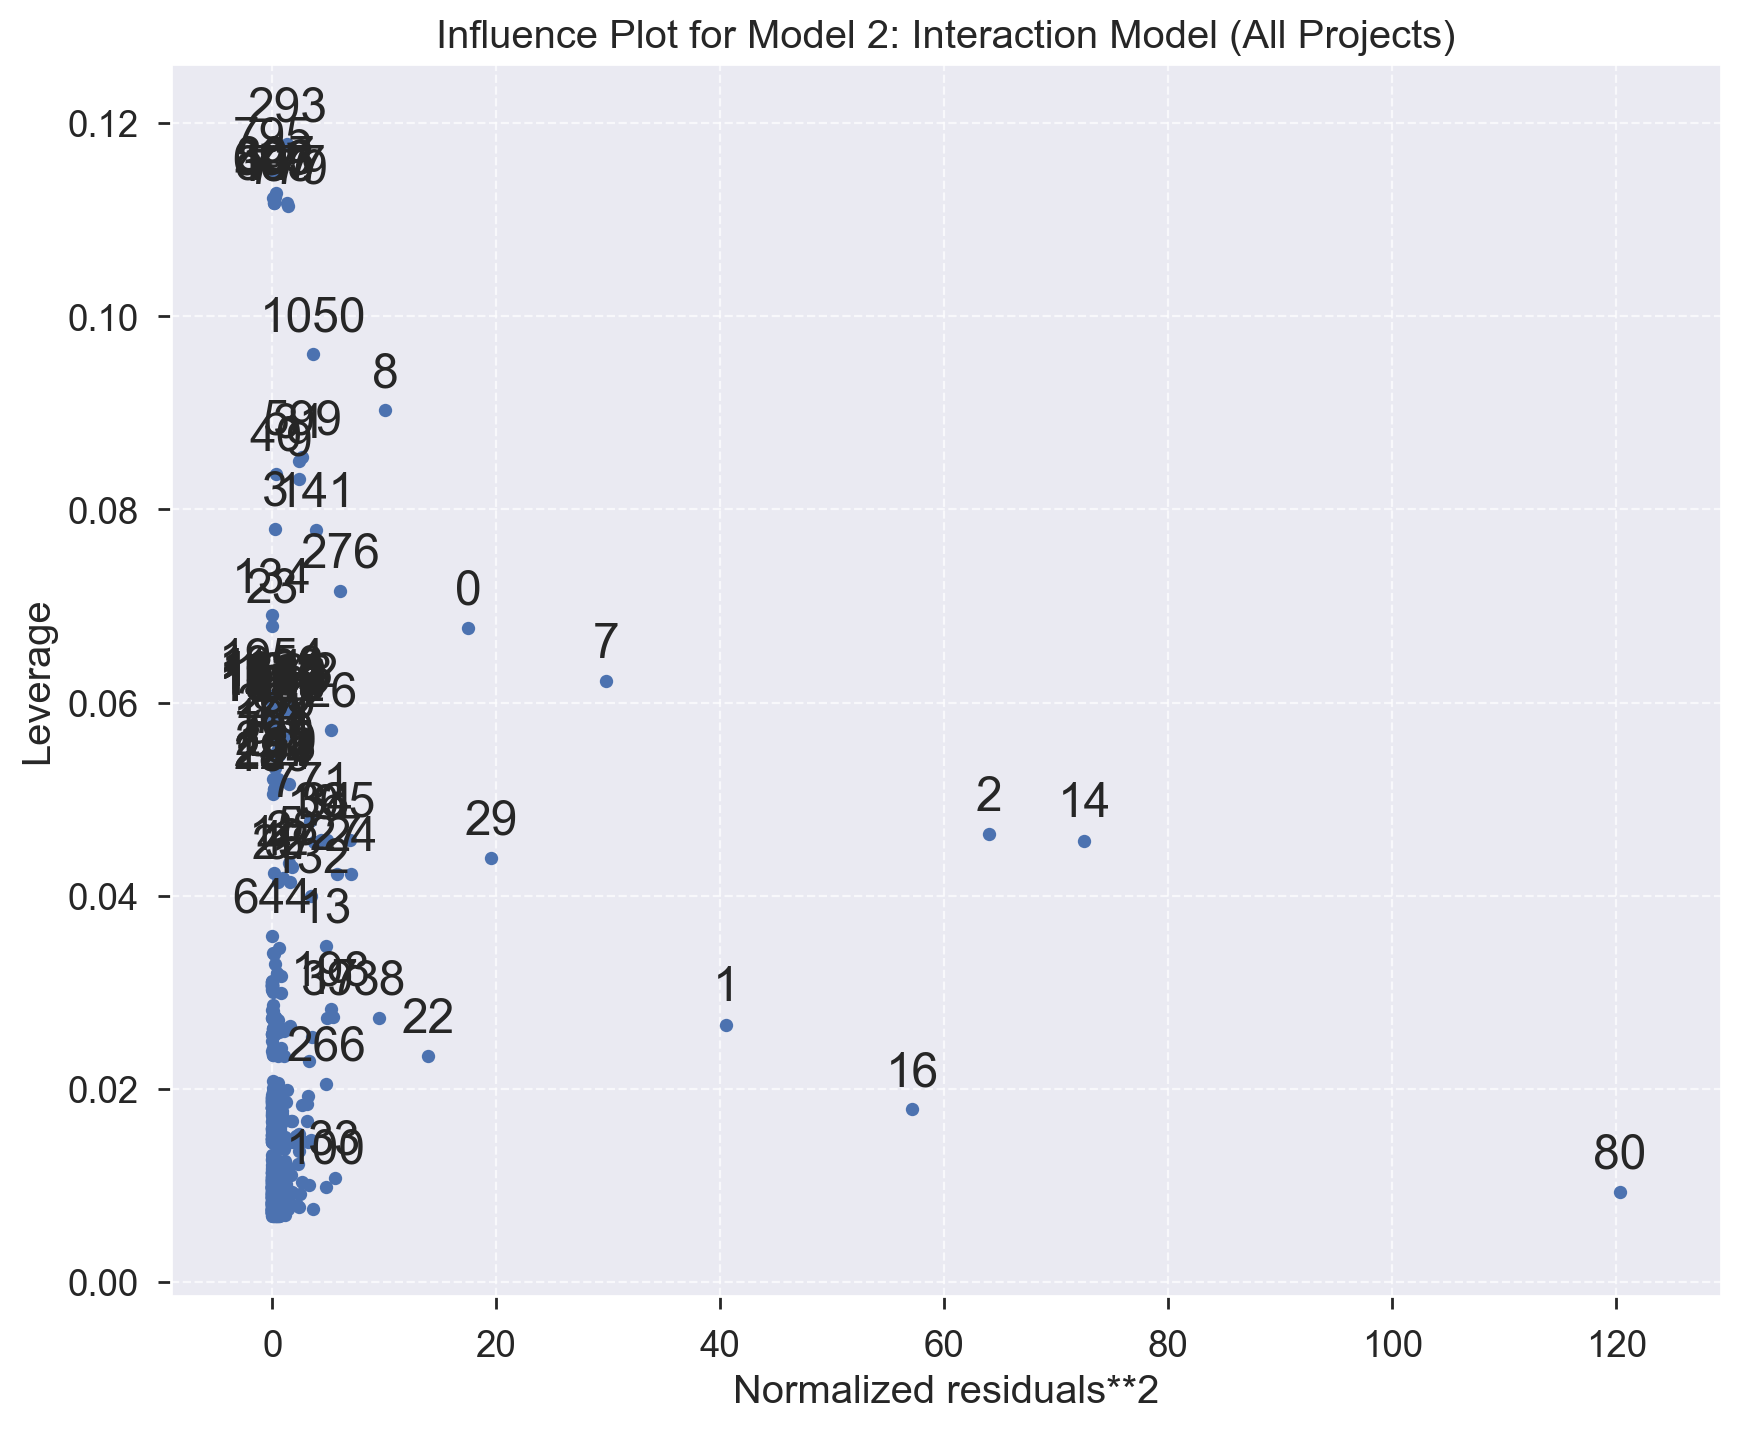


ANOVA Comparison of Models:
   df_resid          ssr  df_diff     ss_diff         F        Pr(>F)
0     780.0  1054.305163      0.0         NaN       NaN           NaN
1     778.0   830.572941      2.0  223.732222  104.7853  5.058853e-41
Interaction terms significantly improve the model (p < 0.05)
Preferred model: Model 2 (with interactions)
[2025-05-10 00:50:00] Overall Regression: Completed analysis


In [51]:
log_progress("Overall Regression", "Starting analysis")

# Function to run and document regression model
def run_regression_model(data, y_var, x_vars, model_name, output_file=None, print_results=True, 
                         check_vif=True, plot_residuals=True, plot_leverage=True):
    """
    Run a regression model and document results
    
    Parameters:
    -----------
    data : pandas DataFrame
        Dataset containing variables
    y_var : str
        Name of dependent variable
    x_vars : list
        List of predictor variable names
    model_name : str
        Name of the model for documentation
    output_file : str or None
        Path to save results (if None, results are not saved to file)
    print_results : bool
        Whether to print summary to console
    check_vif : bool
        Whether to calculate and report VIFs
    plot_residuals : bool
        Whether to create residual plots
    plot_leverage : bool
        Whether to create leverage/influence plots
    
    Returns:
    --------
    statsmodels.regression.linear_model.RegressionResults
        Fitted model results
    """
    # Prepare formula for statsmodels
    formula = f"{y_var} ~ {' + '.join(x_vars)}"
    # Fit the model
    model = smf.ols(formula=formula, data=data).fit()
    
    # Print summary if requested
    if print_results:
        print(f"\n{model_name} Results:")
        print(f"Observations: {model.nobs}")
        print(f"R-squared: {model.rsquared:.4f}")
        print(f"Adjusted R-squared: {model.rsquared_adj:.4f}")
        print(f"F-statistic: {model.fvalue:.2f} (p-value: {model.f_pvalue:.4f})")
        print(f"AIC: {model.aic:.2f}")
        print(f"BIC: {model.bic:.2f}")
        print("\nCoefficients:")
        
        # Create a nice coefficient table with significance stars
        coef_table = pd.DataFrame({
            'Coefficient': model.params,
            'Std Error': model.bse,
            't-value': model.tvalues,
            'p-value': model.pvalues
        })
        
        # Add significance stars
        coef_table['Significance'] = ''
        coef_table.loc[coef_table['p-value'] < 0.001, 'Significance'] = '***'
        coef_table.loc[(coef_table['p-value'] >= 0.001) & (coef_table['p-value'] < 0.01), 'Significance'] = '**'
        coef_table.loc[(coef_table['p-value'] >= 0.01) & (coef_table['p-value'] < 0.05), 'Significance'] = '*'
        coef_table.loc[(coef_table['p-value'] >= 0.05) & (coef_table['p-value'] < 0.1), 'Significance'] = '.'
        
        # Sort by significance
        coef_table_sorted = coef_table.sort_values('p-value')
        print(coef_table_sorted)
    
    # Save to file if output_file is provided
    if output_file:
        with open(output_file, 'w') as f:
            f.write(f"{model_name}\n")
            f.write("="*80 + "\n\n")
            f.write(model.summary().as_text())
            
            # Add note about significance levels
            f.write("\n\nSignificance codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1\n\n")
            
            # Calculate VIFs if requested
            if check_vif:
                f.write("Variance Inflation Factors (VIF):\n")
                vif_data = calculate_vif(data[x_vars])
                f.write(vif_data.to_string() + "\n\n")
    
    # Check for multicollinearity if requested
    if check_vif:
        vif_data = calculate_vif(data[x_vars])
        print("\nVariance Inflation Factors (VIF):")
        print(vif_data.sort_values('VIF', ascending=False).head(10))
        
        # Alert for high VIFs
        high_vifs = vif_data[vif_data['VIF'] > VIF_THRESHOLD]
        if len(high_vifs) > 0:
            print(f"\nWARNING: {len(high_vifs)} variables have VIF > {VIF_THRESHOLD}, indicating potential multicollinearity:")
            print(high_vifs[['Variable', 'VIF']])
    
    # Create diagnostic plots if requested
    if plot_residuals:
        create_residual_plots(model, model_name)
    
    if plot_leverage:
        create_leverage_plot(model, model_name)
    
    return model

# # Function to calculate VIFs
# def calculate_vif(X):
#     """Calculate Variance Inflation Factors for predictor variables"""

#     # Add constant for intercept
#     X_with_const = add_constant(X)
    
#     # Calculate VIF for each predictor
#     vif_data = pd.DataFrame()
#     vif_data['Variable'] = X_with_const.columns
#     vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) 
#                         for i in range(X_with_const.shape[1])]
    
#     # Drop constant term (always has high VIF)
#     vif_data = vif_data[vif_data['Variable'] != 'const']
    
#     return vif_data

def calculate_vif(X):
    # Ensure numeric dtype
    X = X.apply(pd.to_numeric, errors='coerce')
    
    # Drop rows with NaNs
    X = X.dropna()

    # Add constant term
    X_with_const = sm.add_constant(X)

    # Force float conversion
    X_with_const = X_with_const.astype(float)

    # Calculate VIF
    vif_data = pd.DataFrame()
    vif_data['Variable'] = X_with_const.columns
    vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) 
                       for i in range(X_with_const.shape[1])]
    
    return vif_data[vif_data['Variable'] != 'const']

# Function to create residual plots
def create_residual_plots(model, model_name):
    """Create diagnostic residual plots for the model"""
    # Get fitted values and residuals
    fitted_values = model.fittedvalues
    residuals = model.resid
    std_residuals = model.get_influence().resid_studentized_internal
    
    # Create figure with 2x2 subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Residuals vs. Fitted Values
    ax1.scatter(fitted_values, residuals, alpha=0.5)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_xlabel('Fitted Values')
    ax1.set_ylabel('Residuals')
    ax1.set_title('Residuals vs. Fitted Values')
    
    # Plot 2: Q-Q Plot of Standardized Residuals
    import scipy.stats as stats
    stats.probplot(std_residuals, dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot of Std Residuals')
    
    # Plot 3: Histogram of Residuals
    ax3.hist(residuals, bins=20, edgecolor='black')
    ax3.set_xlabel('Residuals')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Histogram of Residuals')
    
    # Plot 4: Standardized Residuals vs. Fitted Values
    ax4.scatter(fitted_values, std_residuals, alpha=0.5)
    ax4.axhline(y=0, color='r', linestyle='--')
    ax4.axhline(y=2, color='r', linestyle=':')
    ax4.axhline(y=-2, color='r', linestyle=':')
    ax4.set_xlabel('Fitted Values')
    ax4.set_ylabel('Standardized Residuals')
    ax4.set_title('Standardized Residuals vs. Fitted Values')
    
    # Add overall title and adjust layout
    plt.suptitle(f'Diagnostic Plots for {model_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])

    # Display the plot
    plt.show()
    
    # Save the figure
    plot_filename = f"{model_name.lower().replace(' ', '_')}_diagnostics.png"
    plt.savefig(os.path.join(FIGURES_DIR, plot_filename), dpi=300)
    plt.close()

# Function to create leverage plot
def create_leverage_plot(model, model_name):
    """Create influence/leverage plot for the model"""
    fig, ax = plt.subplots(figsize=(10, 8))
    plot_leverage_resid2(model, ax=ax)
    ax.set_title(f'Influence Plot for {model_name}')
    ax.grid(True, linestyle='--', alpha=0.7)

    # Display the plot
    plt.show()
    
    # Save the figure
    plot_filename = f"{model_name.lower().replace(' ', '_')}_leverage.png"
    plt.savefig(os.path.join(FIGURES_DIR, plot_filename), dpi=300)
    plt.close()

# Model 1: Base model without interactions
model1_vars = numeric_predictors + tech_dummy_cols

dupes = df_valid.columns[df_valid.columns.duplicated()].tolist()
print("🔍 Duplicate columns:", dupes)

for col in model1_vars:
    try:
        series = df_valid[col]
        if hasattr(series, 'ndim') and series.ndim > 1:
            print(f"❌ Column {col} is {series.ndim}D with shape {series.shape}")
            print('df_valid[col]', df_valid[col][:5])
    except KeyError:
        print(f"❌ Column {col} not found in DataFrame")

df_valid.columns = df_valid.columns.str.strip().str.replace(' ', '_').str.replace('[^0-9a-zA-Z_]', '', regex=True)


model1 = run_regression_model(
    data=df_valid,
    y_var=y_var,
    x_vars=model1_vars,
    model_name="Model 1: Base Model (All Projects)",
    output_file=os.path.join(MODELS_DIR, 'model1_base_results.txt')
)

# Model 2: Model with regime interactions
model2_vars = numeric_predictors + tech_dummy_cols + interaction_vars
model2 = run_regression_model(
    data=df_valid,
    y_var=y_var,
    x_vars=model2_vars,
    model_name="Model 2: Interaction Model (All Projects)",
    output_file=os.path.join(MODELS_DIR, 'model2_interaction_results.txt')
)

# Compare models using ANOVA
if model1 is not None and model2 is not None:
    anova_results = anova_lm(model1, model2)
    print("\nANOVA Comparison of Models:")
    print(anova_results)
    
    # Test if the interaction terms significantly improve the model
    if anova_results['Pr(>F)'].iloc[-1] < 0.05:
        print("Interaction terms significantly improve the model (p < 0.05)")
        preferred_model = model2
        preferred_model_name = "Model 2 (with interactions)"
    else:
        print("Interaction terms do not significantly improve the model (p >= 0.05)")
        preferred_model = model1
        preferred_model_name = "Model 1 (without interactions)"
    
    print(f"Preferred model: {preferred_model_name}")
else:
    print("Could not compare models using ANOVA (one or both models failed)")
    preferred_model = model1 if model1 is not None else model2
    preferred_model_name = "Model 1" if model1 is not None else "Model 2"

# Save the overall preferred model results
if preferred_model is not None:
    with open(MODEL_OVERALL_RESULTS, 'w') as f:
        f.write(f"Preferred Overall Model: {preferred_model_name}\n")
        f.write("="*80 + "\n\n")
        f.write(preferred_model.summary().as_text())

log_progress("Overall Regression", "Completed analysis")

## 3. Regime-Specific Models

This section develops separate regression models for CDM and VCS projects to identify regime-specific determinants of success.

[2025-05-10 00:50:00] Regime-Specific Models: Starting analysis

VCS Projects Model Results:
Observations: 293.0
R-squared: 0.2155
Adjusted R-squared: 0.1990
F-statistic: 13.09 (p-value: 0.0000)
AIC: 1076.17
BIC: 1101.93

Coefficients:
                                 Coefficient     Std Error   t-value  \
Intercept                      -1.486140e+00  2.422978e-01 -6.133526   
Tech_Biomass_and_Waste[T.True] -2.696609e+00  4.406521e-01 -6.119586   
log_t_actual_years              5.700724e-01  1.187006e-01  4.802609   
Tech_Other[T.True]              9.431384e-01  3.642435e-01  2.589307   
Tech_Industrial_Gases[T.True]   1.971005e-16  8.505768e-17  2.317257   
Is_International                7.457323e-01  3.411404e-01  2.185998   
Tech_Energy_Efficiency[T.True]  4.388551e-01  2.149019e-01  2.042118   
Scale_Large                    -8.486897e-01  4.513402e-01 -1.880377   
Tech_Hydro[T.True]             -1.857234e-16  1.259810e-16 -1.474217   
Tech_Other_Renewable[T.True]   -1.715251e-01

c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1

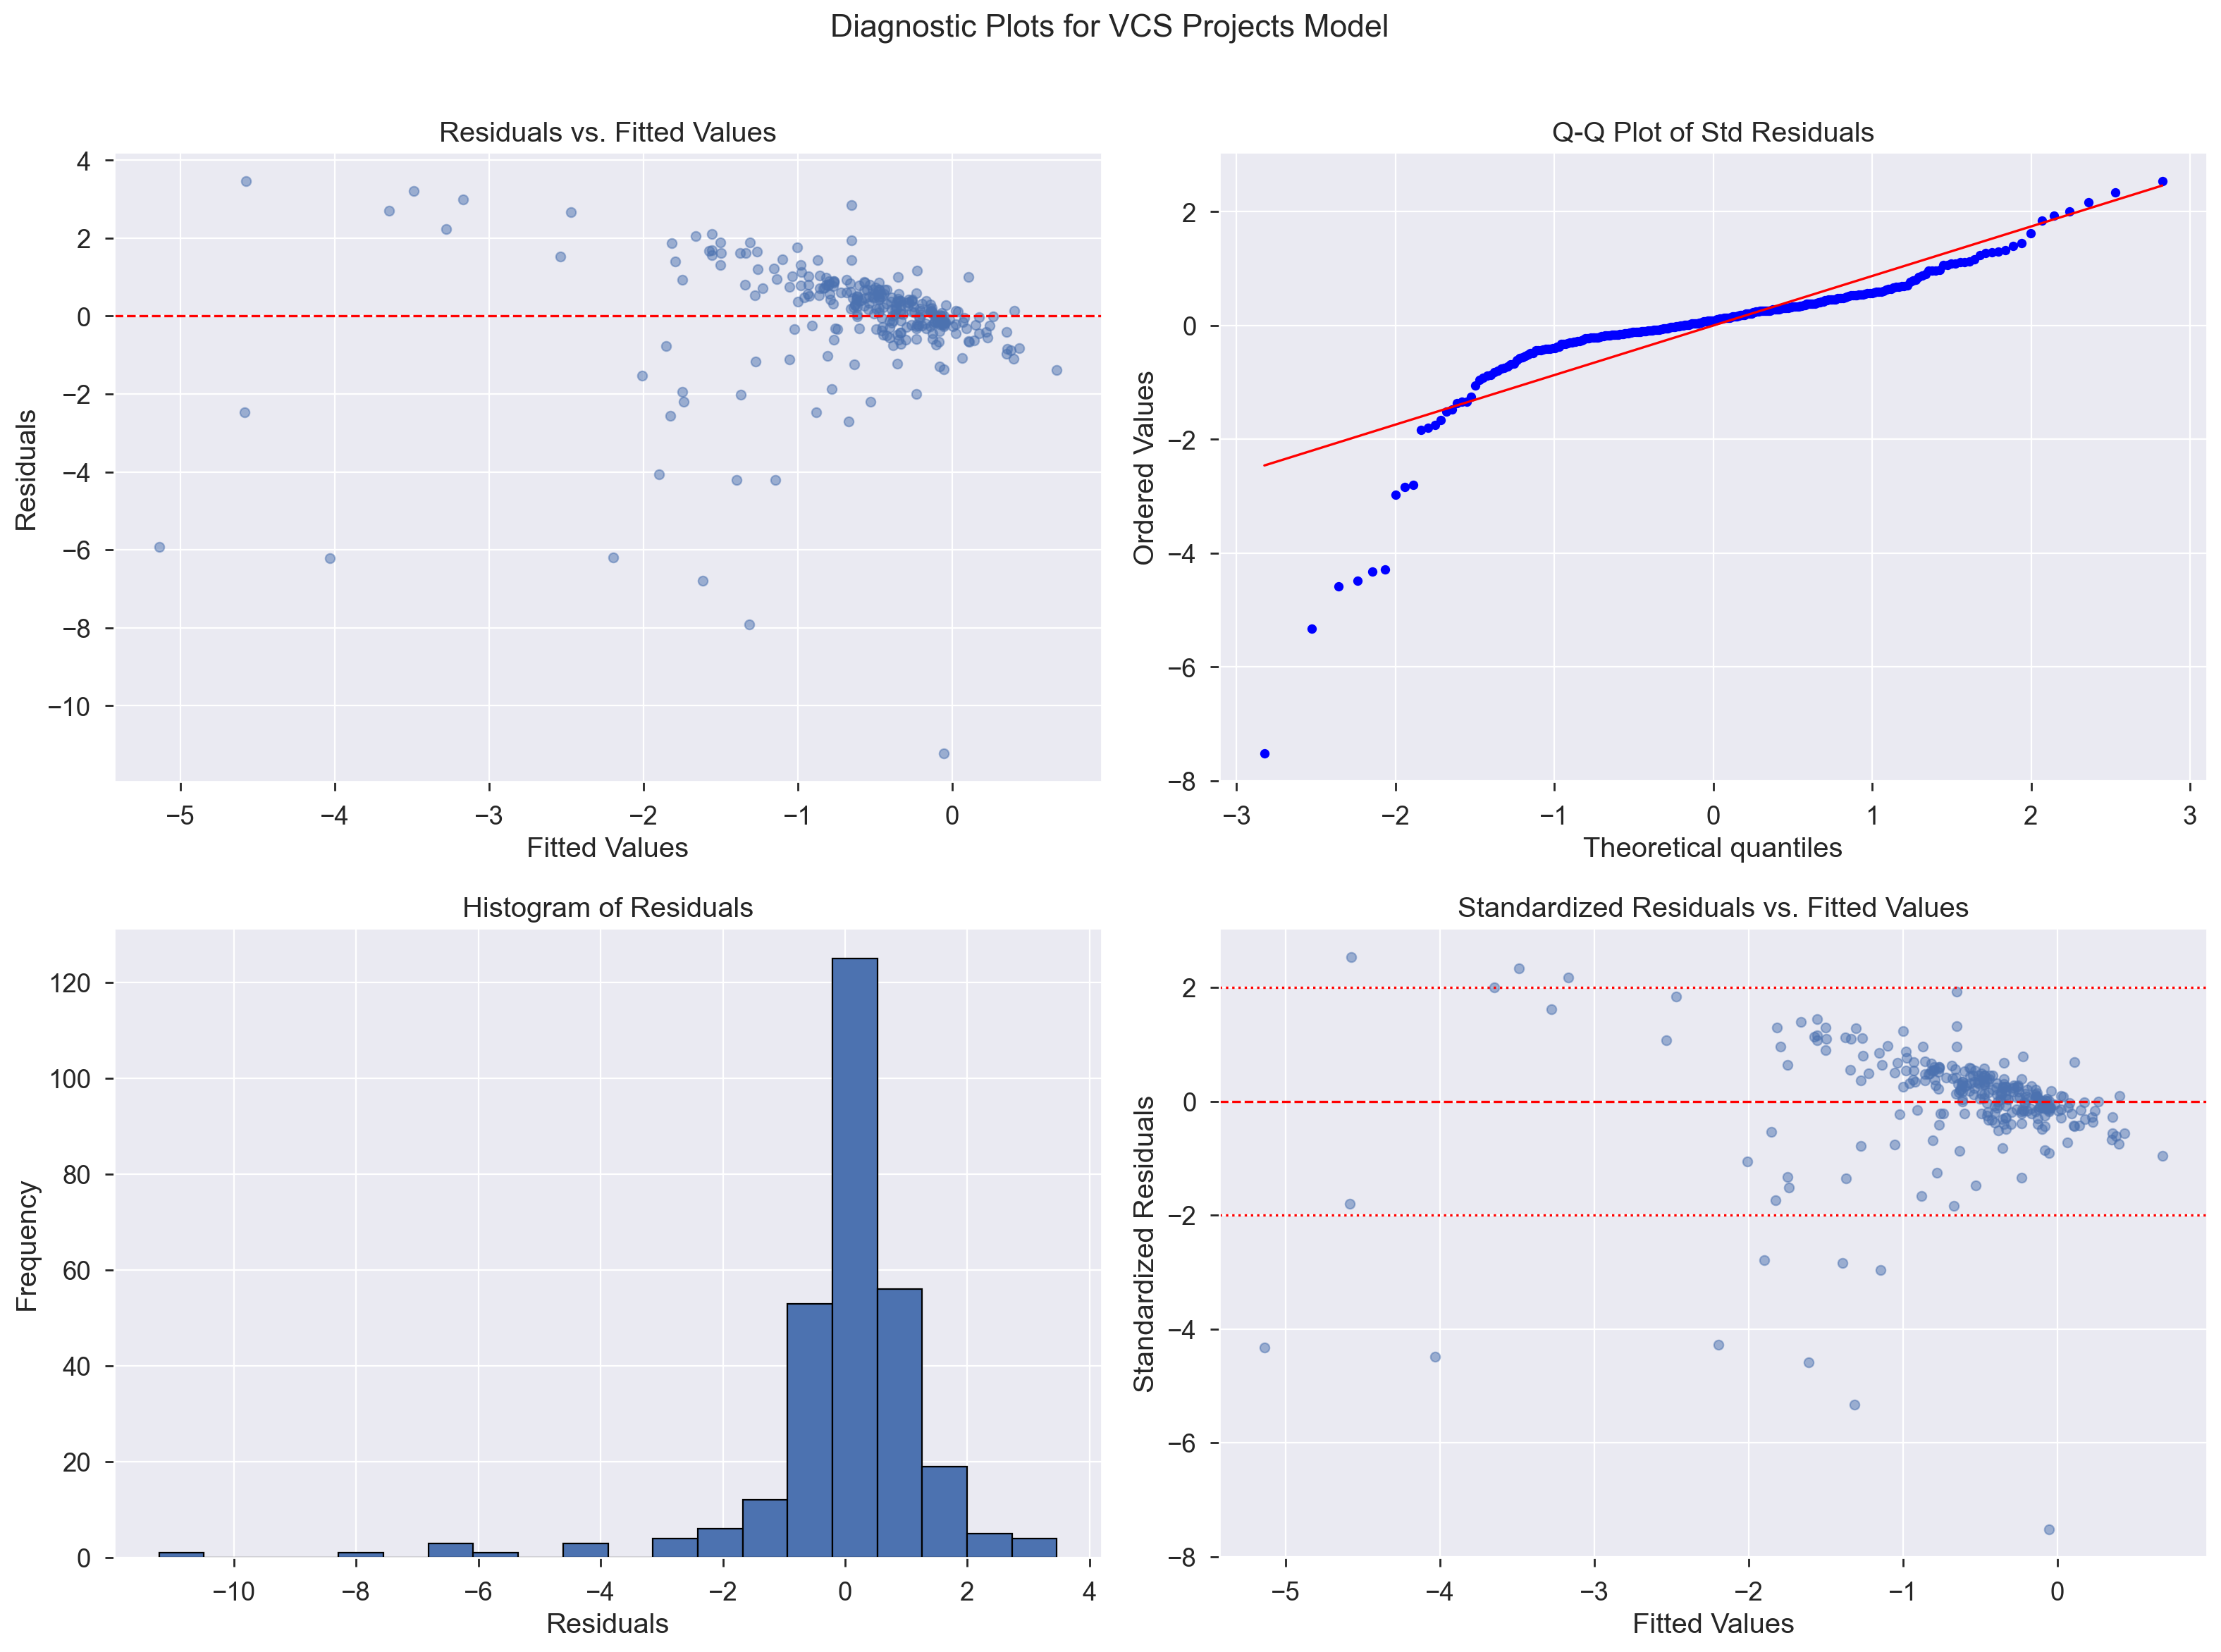

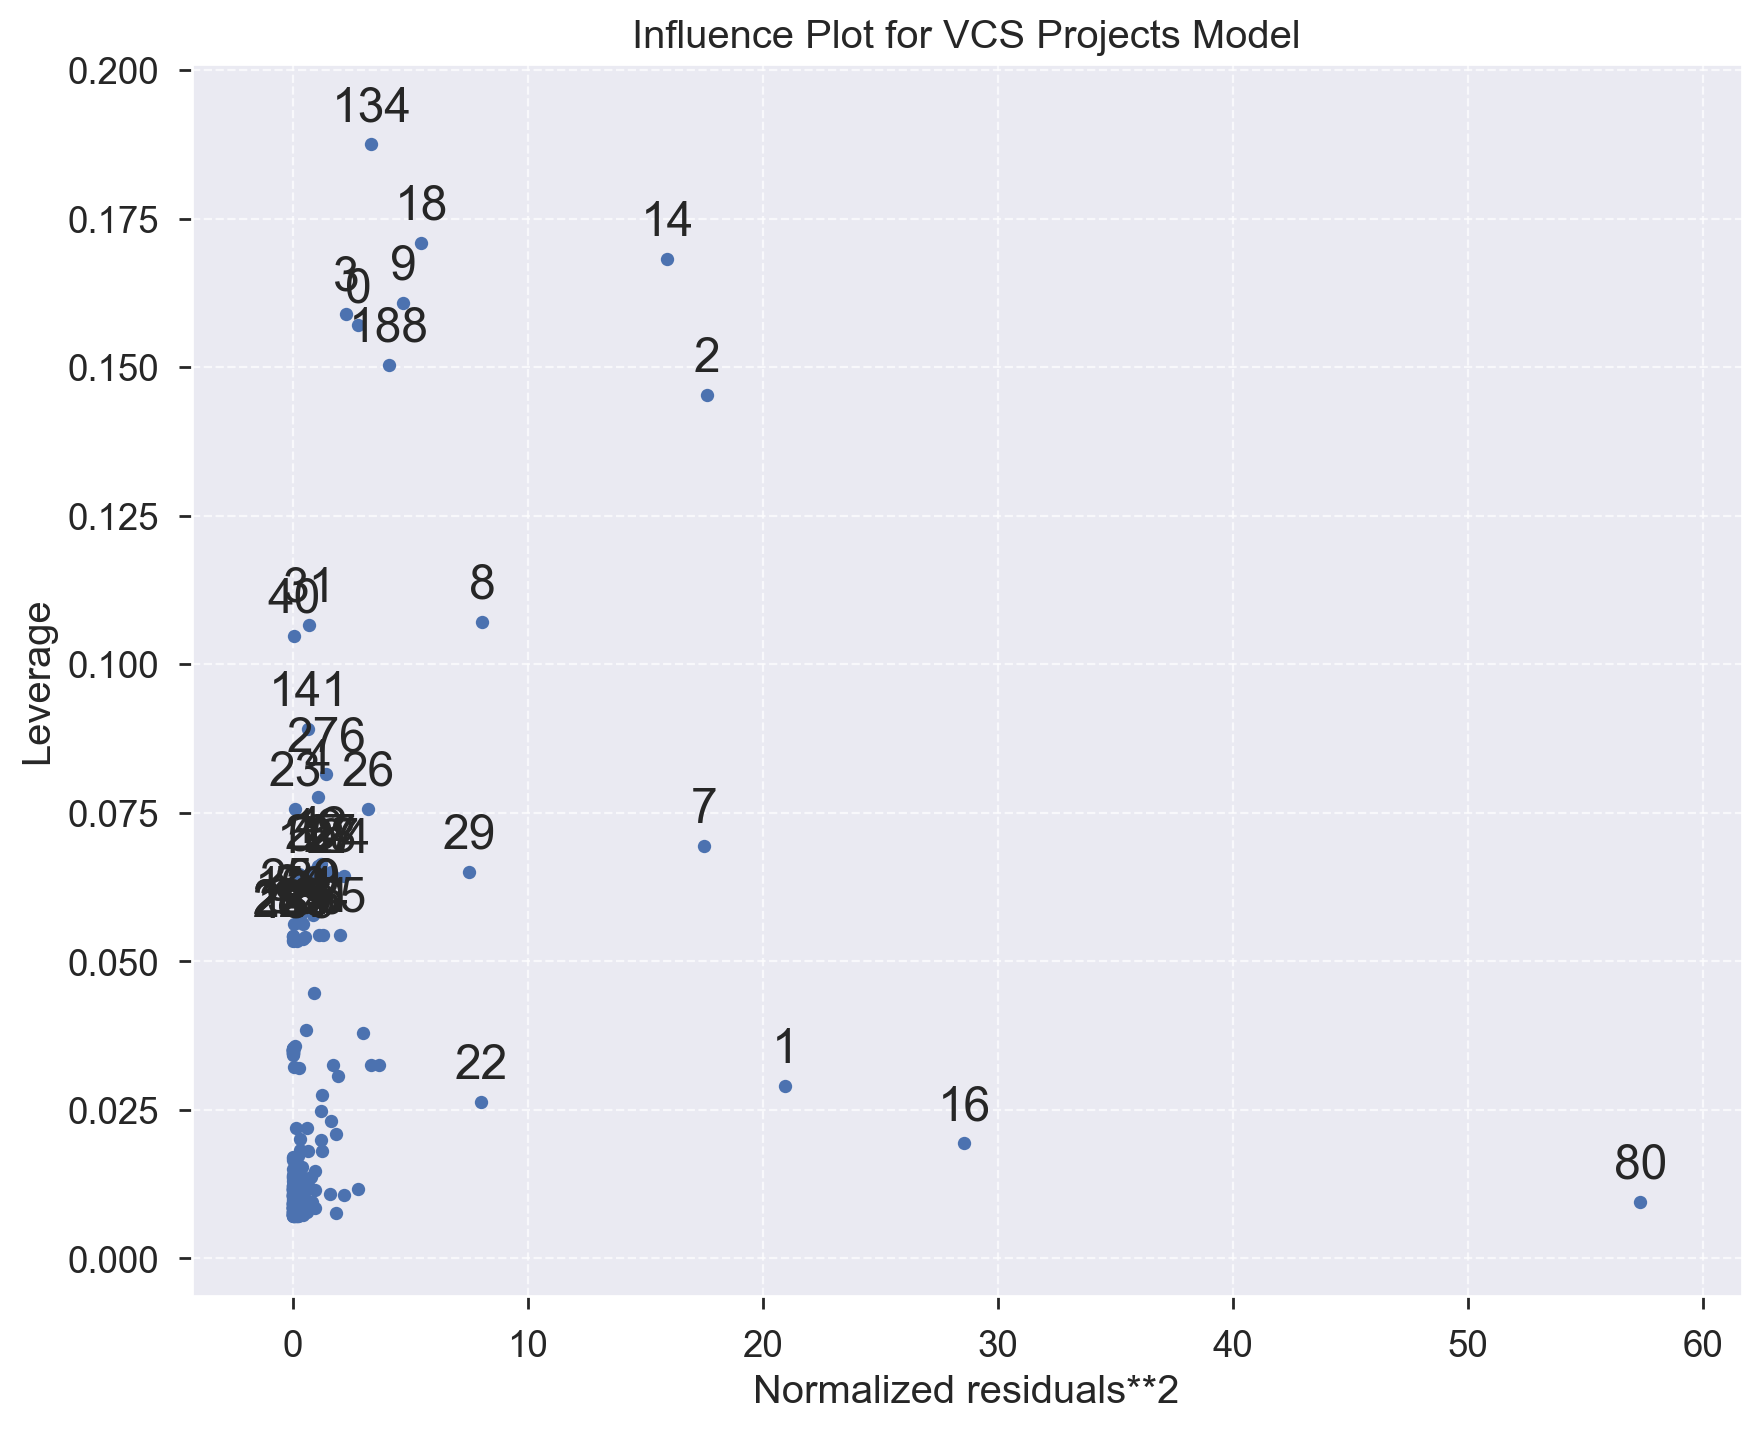


CDM Projects Model Results:
Observations: 499.0
R-squared: 0.5755
Adjusted R-squared: 0.5677
F-statistic: 73.67 (p-value: 0.0000)
AIC: 724.37
BIC: 766.50

Coefficients:
                                Coefficient  Std Error    t-value  \
log_t_actual_years                -0.618586   0.024465 -25.284651   
Intercept                          0.554621   0.028219  19.654392   
Is_International                   0.554621   0.028219  19.654392   
Tech_Other[T.True]                -0.278542   0.079022  -3.524872   
Tech_Energy_Efficiency[T.True]    -1.579175   0.497707  -3.172900   
Tech_Biomass_and_Waste[T.True]    -0.178874   0.058314  -3.067418   
Tech_Industrial_Gases[T.True]     -0.387453   0.171887  -2.254123   
Scale_Large                       -0.050253   0.054817  -0.916748   
Tech_Hydro[T.True]                 0.026708   0.074667   0.357702   
Tech_Other_Renewable[T.True]      -0.007663   0.102860  -0.074498   
Tech_Solar[T.True]                -0.005825   0.121892  -0.047789   

 

c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


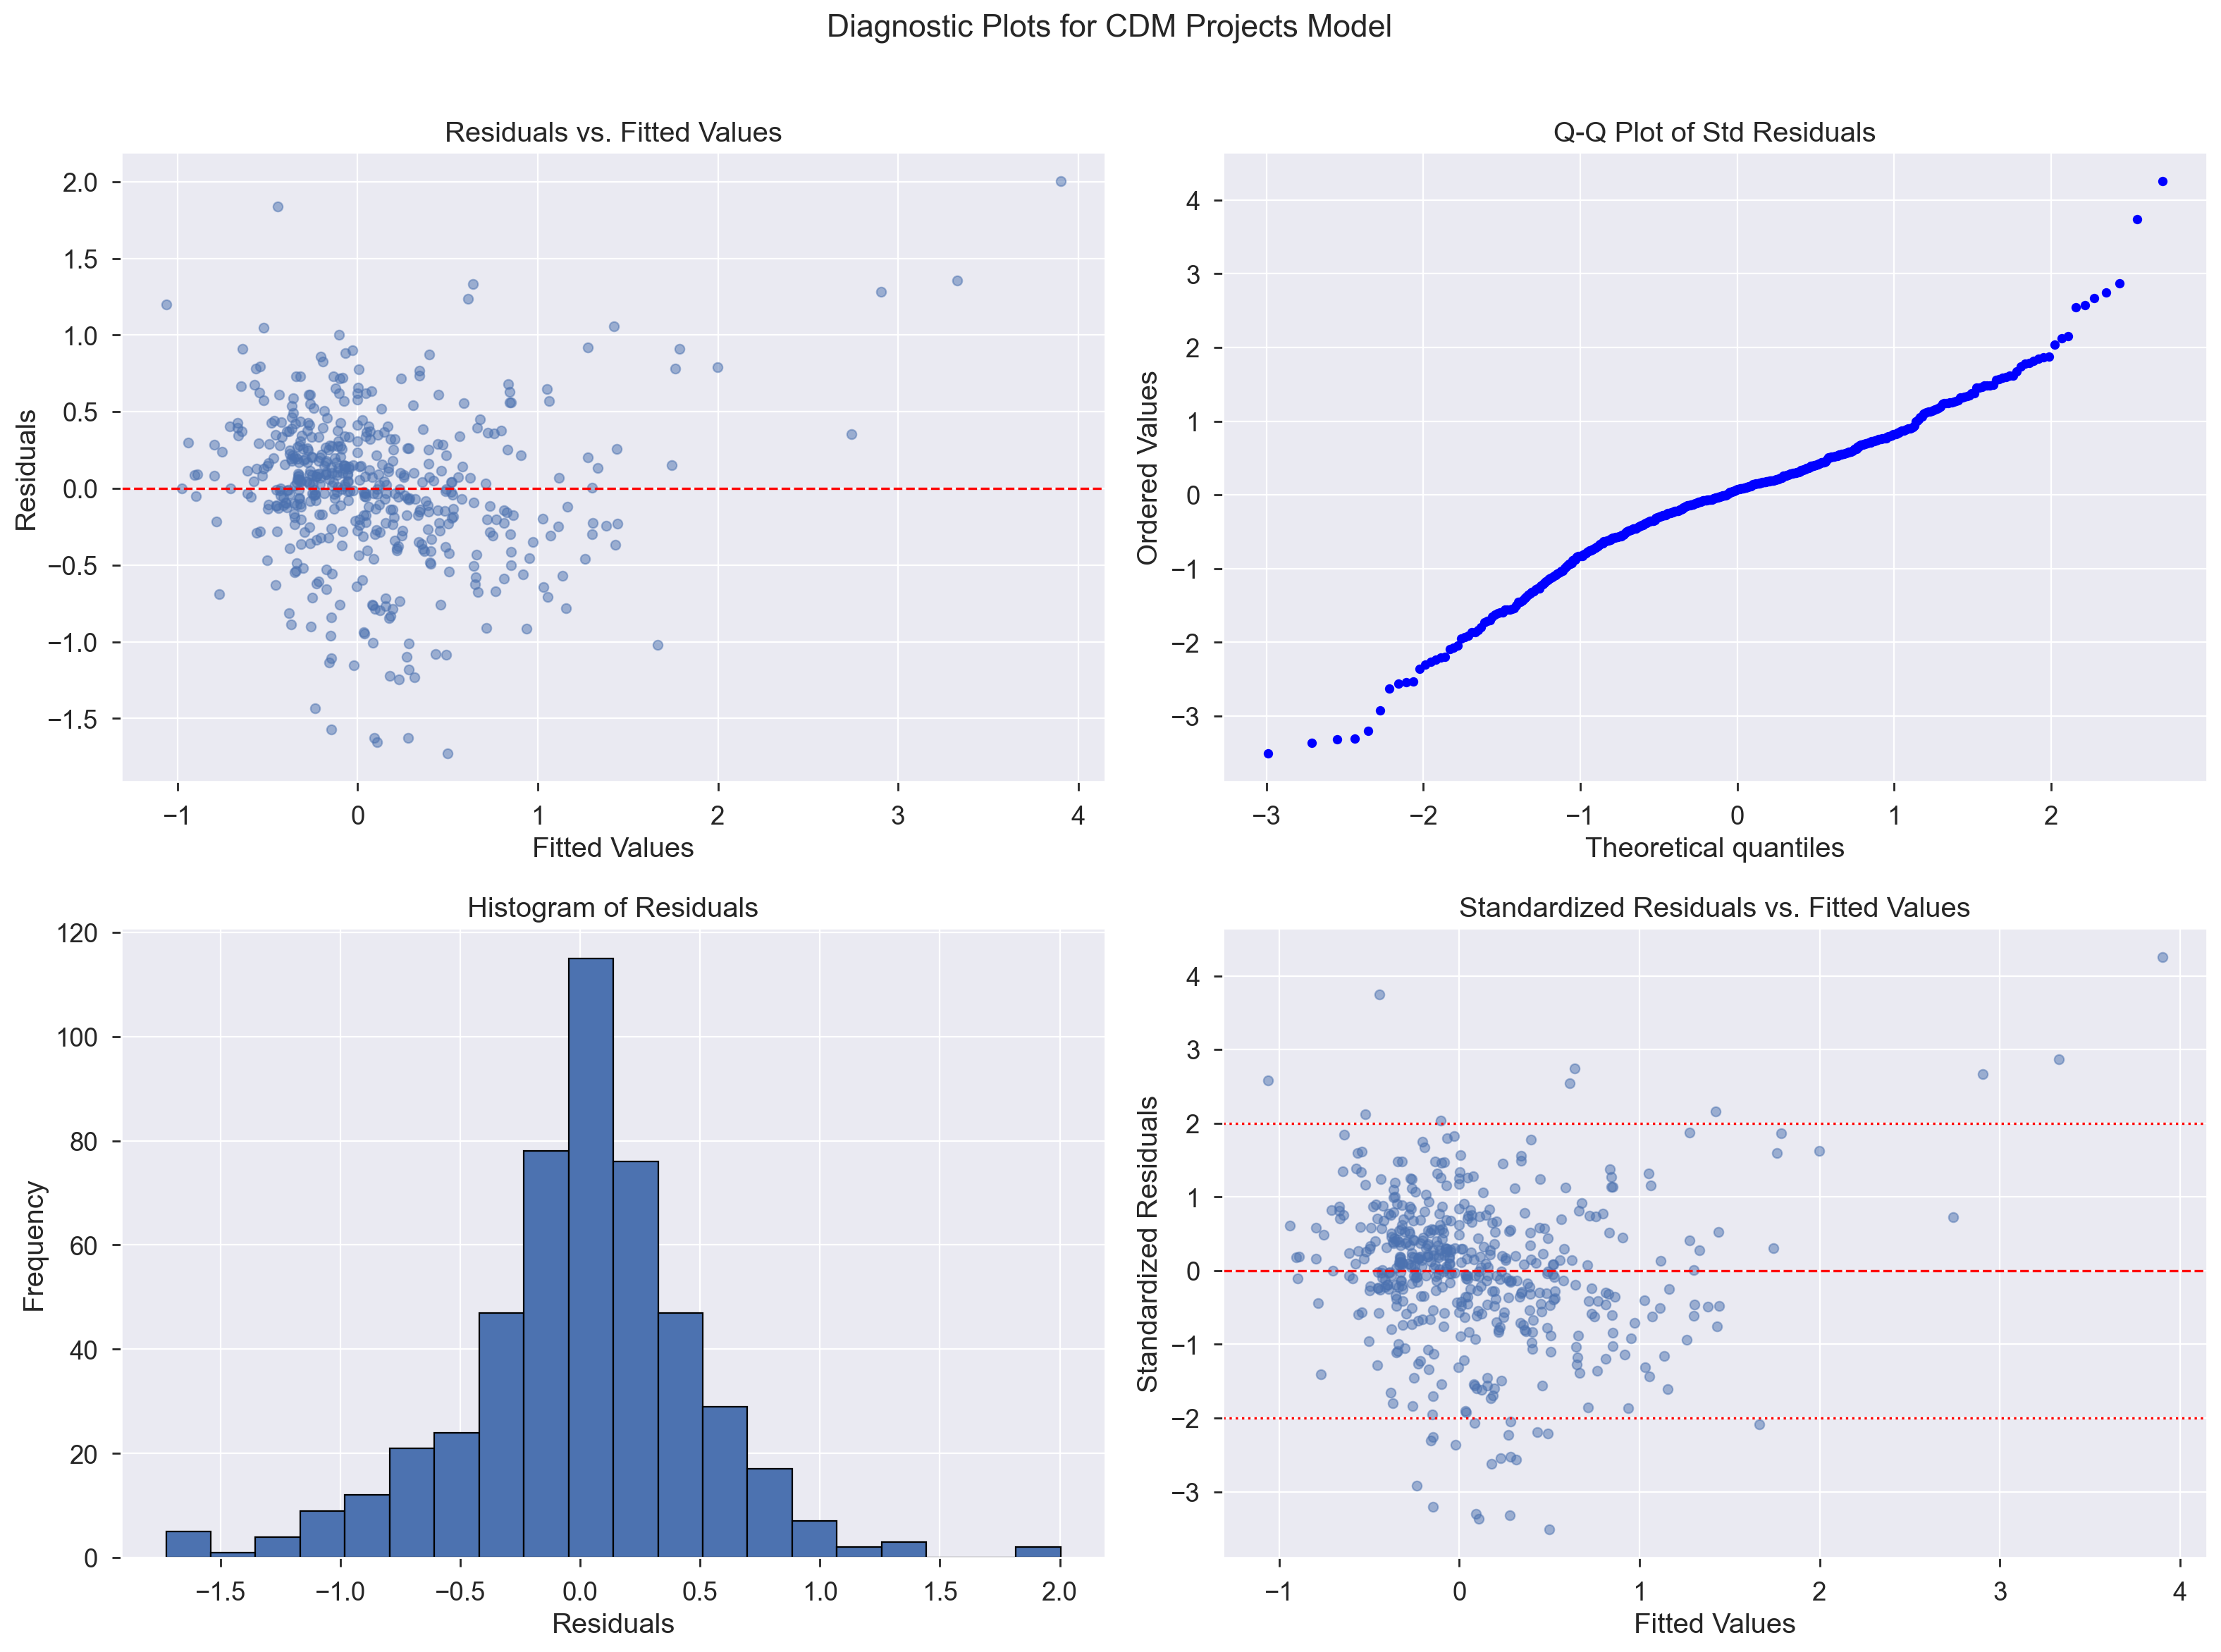

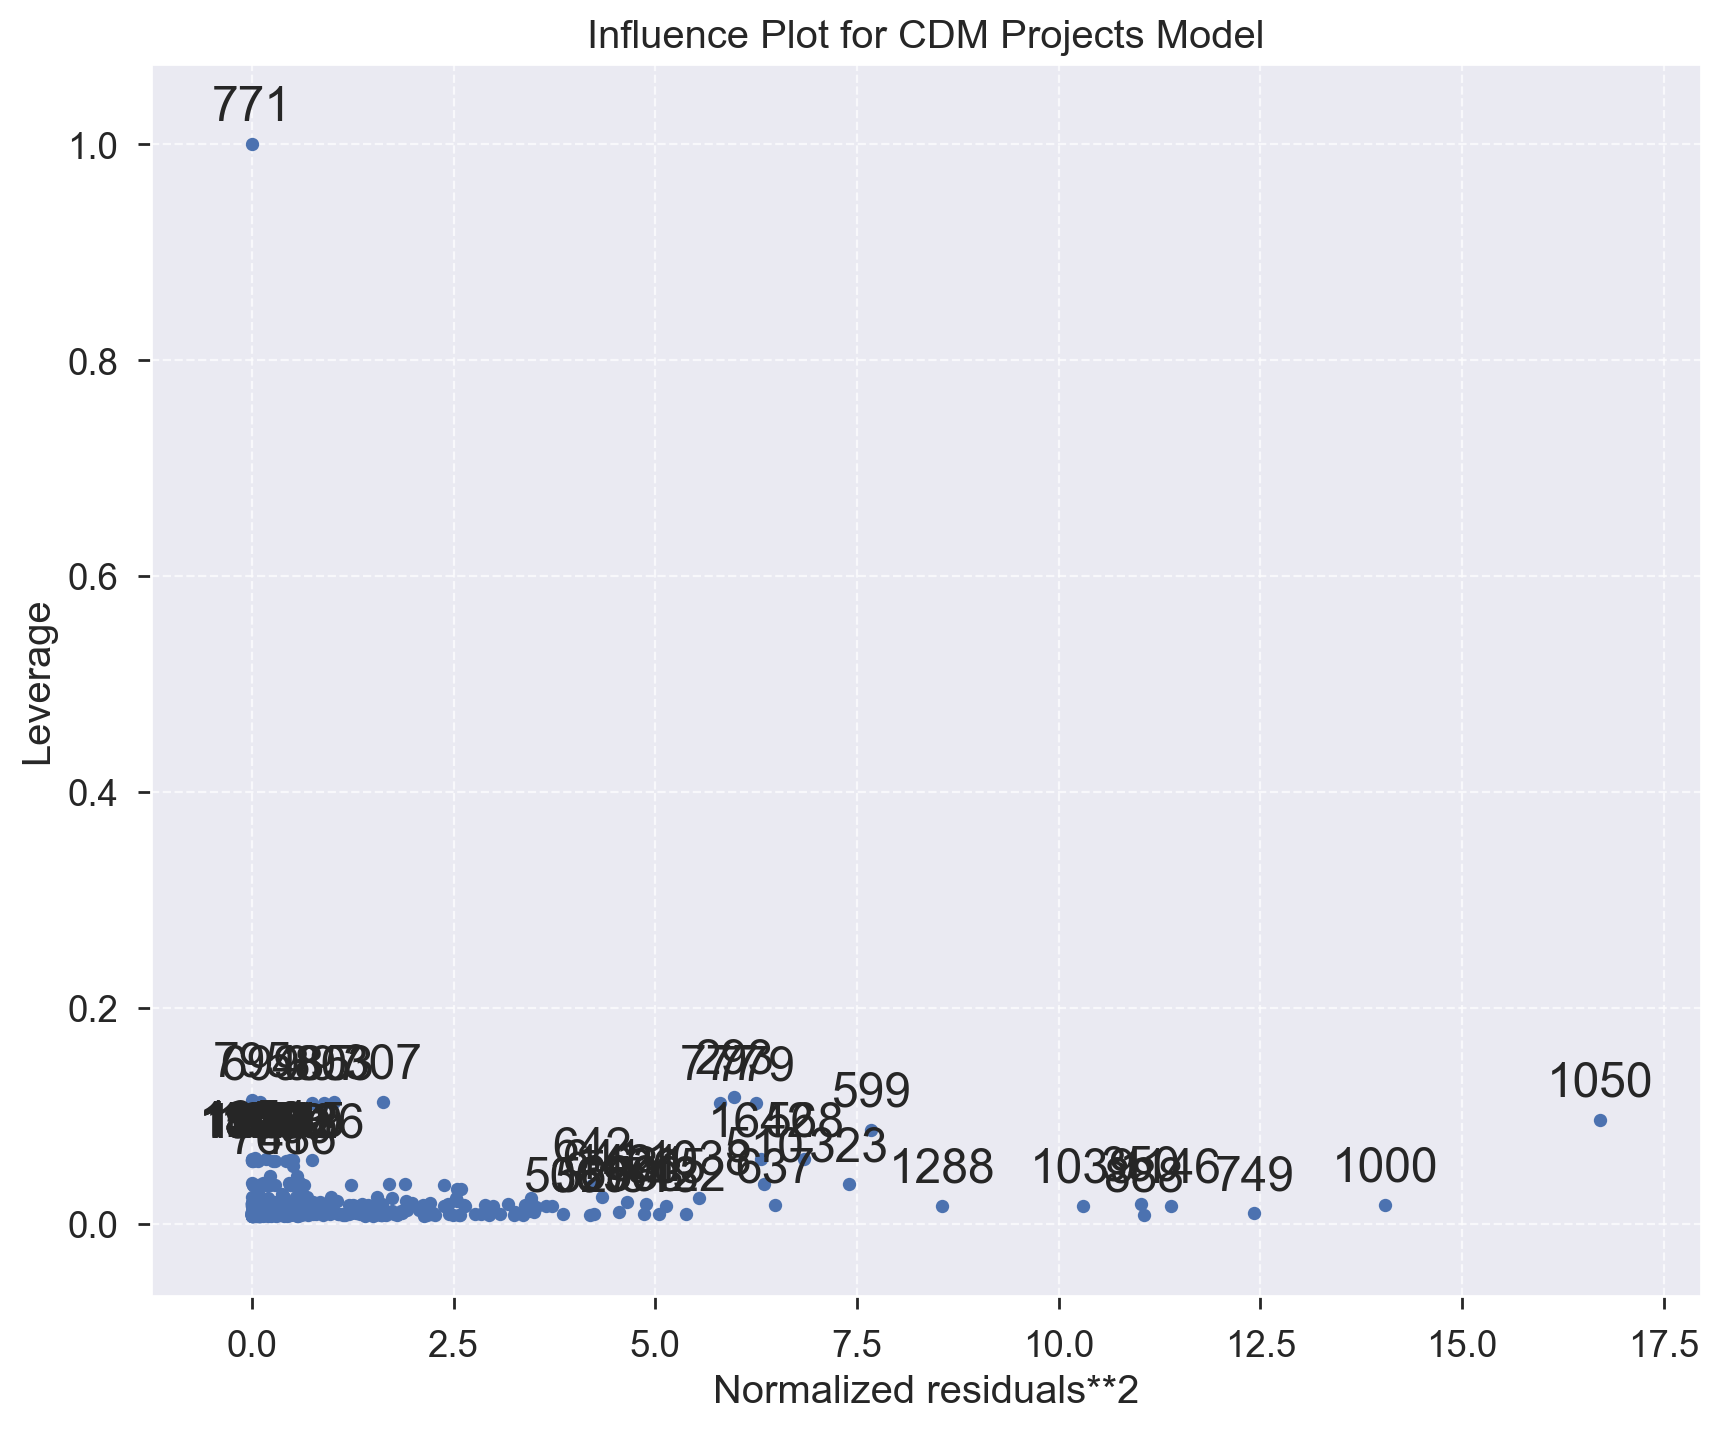


Coefficient Comparison between VCS and CDM Models:
                                    VCS_coef      VCS_pval  CDM_coef  \
log_t_actual_years              5.700724e-01  2.529909e-06 -0.618586   
Intercept                      -1.486140e+00  2.851997e-09  0.554621   
Tech_Biomass_and_Waste[T.True] -2.696609e+00  3.081507e-09 -0.178874   
Tech_Energy_Efficiency[T.True]  4.388551e-01  4.205689e-02 -1.579175   
Tech_Other[T.True]              9.431384e-01  1.010903e-02 -0.278542   
Tech_Industrial_Gases[T.True]   1.971005e-16  2.119583e-02 -0.387453   
Scale_Large                    -8.486897e-01  6.107284e-02 -0.050253   
Tech_Other_Renewable[T.True]   -1.715251e-01  4.703302e-01 -0.007663   
Is_International                7.457323e-01  2.962643e-02  0.554621   
Tech_Hydro[T.True]             -1.857234e-16  1.415231e-01  0.026708   
Tech_Solar[T.True]              0.000000e+00           NaN -0.005825   

                                    CDM_pval VCS_sig CDM_sig      Diff  \
log_t_act

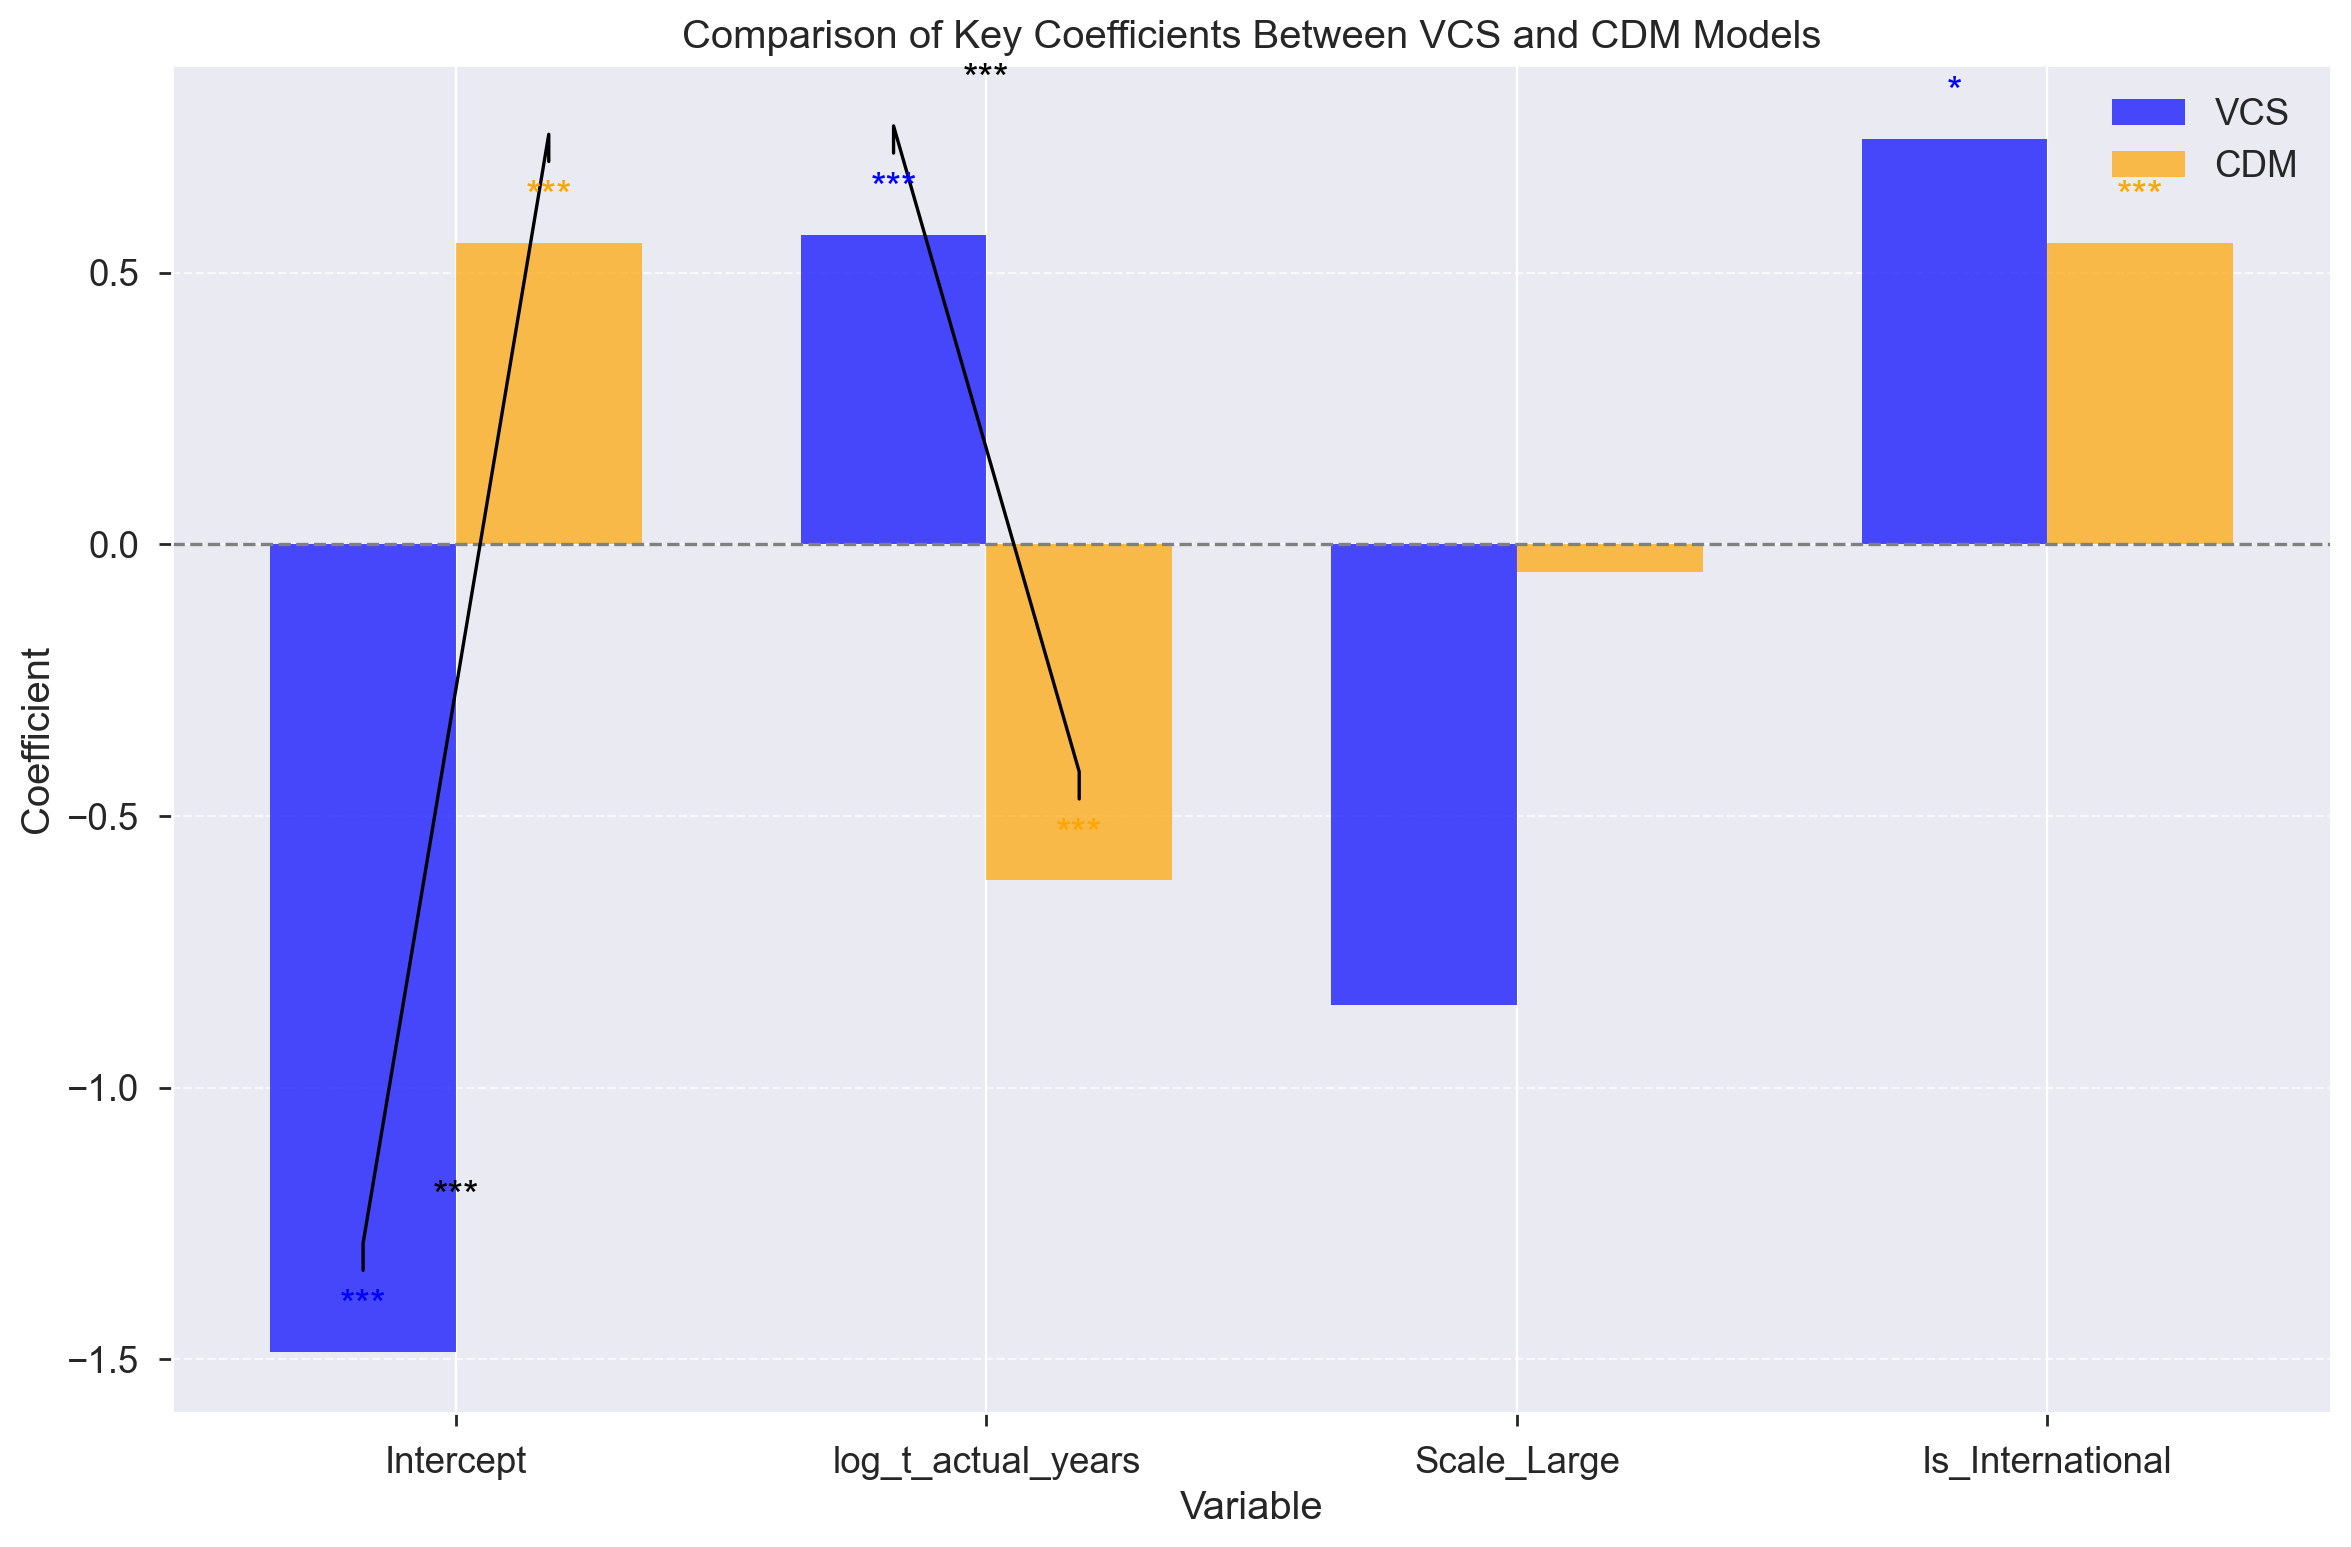


Key findings from regime comparison:
Significant differences between regimes found for:
  - Intercept: Stronger effect in CDM (diff=-2.0408, p=0.0000)
  - log_t_actual_years: Stronger effect in VCS (diff=1.1887, p=0.0000)
[2025-05-10 00:50:06] Regime-Specific Models: Completed analysis


In [52]:
log_progress("Regime-Specific Models", "Starting analysis")

# Variables for regime-specific models (exclude regime itself and interactions)
regime_model_vars = ['log_t_actual_years', 'Scale_Large', 'Is_International'] + tech_dummy_cols

# Model for VCS projects
if enough_vcs:
    vcs_model = run_regression_model(
        data=df_vcs,
        y_var=y_var,
        x_vars=regime_model_vars,
        model_name="VCS Projects Model",
        output_file=os.path.join(MODELS_DIR, 'model_vcs_results.txt')
    )
else:
    print("Insufficient VCS projects for separate model")
    vcs_model = None

# Model for CDM projects
if enough_cdm:
    cdm_model = run_regression_model(
        data=df_cdm,
        y_var=y_var,
        x_vars=regime_model_vars,
        model_name="CDM Projects Model",
        output_file=os.path.join(MODELS_DIR, 'model_cdm_results.txt')
    )
else:
    print("Insufficient CDM projects for separate model")
    cdm_model = None

# Compare coefficients across regime-specific models
if vcs_model is not None and cdm_model is not None:
    # Create coefficient comparison dataframe without duplicate index entries
    common_vars = list(dict.fromkeys(['Intercept'] + [var for var in vcs_model.params.index if var in cdm_model.params.index]))
    coef_comparison = pd.DataFrame(index=common_vars)
    
    # Add coefficients and p-values
    coef_comparison['VCS_coef'] = vcs_model.params
    coef_comparison['VCS_pval'] = vcs_model.pvalues
    coef_comparison['CDM_coef'] = cdm_model.params
    coef_comparison['CDM_pval'] = cdm_model.pvalues
    
    # Add significance indicators
    coef_comparison['VCS_sig'] = ''
    coef_comparison.loc[coef_comparison['VCS_pval'] < 0.001, 'VCS_sig'] = '***'
    coef_comparison.loc[(coef_comparison['VCS_pval'] >= 0.001) & (coef_comparison['VCS_pval'] < 0.01), 'VCS_sig'] = '**'
    coef_comparison.loc[(coef_comparison['VCS_pval'] >= 0.01) & (coef_comparison['VCS_pval'] < 0.05), 'VCS_sig'] = '*'
    
    coef_comparison['CDM_sig'] = ''
    coef_comparison.loc[coef_comparison['CDM_pval'] < 0.001, 'CDM_sig'] = '***'
    coef_comparison.loc[(coef_comparison['CDM_pval'] >= 0.001) & (coef_comparison['CDM_pval'] < 0.01), 'CDM_sig'] = '**'
    coef_comparison.loc[(coef_comparison['CDM_pval'] >= 0.01) & (coef_comparison['CDM_pval'] < 0.05), 'CDM_sig'] = '*'
    
    # Calculate difference in coefficients
    coef_comparison['Diff'] = coef_comparison['VCS_coef'] - coef_comparison['CDM_coef']
    
    # Test for statistical difference in coefficients
    import numpy as np
    from scipy import stats
    
    coef_comparison['t_stat'] = np.nan
    coef_comparison['p_diff'] = np.nan
    
    for var in common_vars:
        if not isinstance(var, str) or var not in list(vcs_model.params.index) or var not in list(cdm_model.params.index):
            continue
        
        b1 = vcs_model.params[var]
        b2 = cdm_model.params[var]
        se1 = vcs_model.bse[var]
        se2 = cdm_model.bse[var]
        
        t_stat = (b1 - b2) / np.sqrt(se1**2 + se2**2)
        p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=vcs_model.df_resid + cdm_model.df_resid))
        
        coef_comparison.loc[var, 't_stat'] = t_stat
        coef_comparison.loc[var, 'p_diff'] = p_value
    
    # Add significance indicator for difference
    coef_comparison['Diff_sig'] = ''
    coef_comparison.loc[coef_comparison['p_diff'] < 0.001, 'Diff_sig'] = '***'
    coef_comparison.loc[(coef_comparison['p_diff'] >= 0.001) & (coef_comparison['p_diff'] < 0.01), 'Diff_sig'] = '**'
    coef_comparison.loc[(coef_comparison['p_diff'] >= 0.01) & (coef_comparison['p_diff'] < 0.05), 'Diff_sig'] = '*'
    
    # Sort by significance of difference
    coef_comparison_sorted = coef_comparison.sort_values('p_diff')
    
    print("\nCoefficient Comparison between VCS and CDM Models:")
    print(coef_comparison_sorted)
    
    # Save to file
    coef_comparison_sorted.to_csv(os.path.join(TABLES_DIR, 'regime_coefficient_comparison.csv'))

    # --------- FIXED PLOTTING BLOCK ----------
    initial_key_vars = ['Intercept', 'log_t_actual_years', 'Scale_Large', 'Is_International']
    
    # Use reindex to match and clean missing
    coef_subset = coef_comparison.reindex(initial_key_vars).dropna(subset=['VCS_coef', 'CDM_coef'])

    # Final key vars to plot
    key_vars = list(coef_subset.index)
    x = np.arange(len(key_vars))
    vcs_vals = coef_subset['VCS_coef'].values
    cdm_vals = coef_subset['CDM_coef'].values

    # Plot
    plt.figure(figsize=(12, 8))
    width = 0.35
    plt.bar(x - width/2, vcs_vals, width, label='VCS', color='blue', alpha=0.7)
    plt.bar(x + width/2, cdm_vals, width, label='CDM', color='orange', alpha=0.7)

    plt.xlabel('Variable')
    plt.ylabel('Coefficient')
    plt.title('Comparison of Key Coefficients Between VCS and CDM Models')
    plt.xticks(x, key_vars)
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.legend()

    # Add significance indicators
    for i, var in enumerate(key_vars):
        vcs_sig = coef_subset.loc[var, 'VCS_sig']
        cdm_sig = coef_subset.loc[var, 'CDM_sig']
        diff_sig = coef_subset.loc[var, 'Diff_sig']
        
        if vcs_sig:
            plt.text(i - width/2, coef_subset.loc[var, 'VCS_coef'] + 0.05, vcs_sig, 
                     ha='center', va='bottom', color='blue')
        
        if cdm_sig:
            plt.text(i + width/2, coef_subset.loc[var, 'CDM_coef'] + 0.05, cdm_sig, 
                     ha='center', va='bottom', color='orange')
        
        if diff_sig:
            plt.plot([i - width/2, i - width/2, i + width/2, i + width/2], 
                     [coef_subset.loc[var, 'VCS_coef'] + 0.15, 
                      coef_subset.loc[var, 'VCS_coef'] + 0.2, 
                      coef_subset.loc[var, 'CDM_coef'] + 0.2, 
                      coef_subset.loc[var, 'CDM_coef'] + 0.15], 
                     color='black')
            plt.text(i, coef_subset.loc[var, 'VCS_coef'] + 0.25, diff_sig, 
                     ha='center', va='bottom', color='black')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Display the plot
    plt.show()

    plt.savefig(FIG_REGIME_COEF_COMPARE, dpi=300)
    plt.close()
    # -----------------------------------------

    # Key findings
    print("\nKey findings from regime comparison:")
    key_vars_diff = coef_subset
    sig_diffs = key_vars_diff[key_vars_diff['p_diff'] < 0.05]

    if len(sig_diffs) > 0:
        print("Significant differences between regimes found for:")
        for var in sig_diffs.index:
            vcs_val = sig_diffs.loc[var, 'VCS_coef']
            cdm_val = sig_diffs.loc[var, 'CDM_coef']
            diff = sig_diffs.loc[var, 'Diff']
            p_val = sig_diffs.loc[var, 'p_diff']
           
            stronger = "VCS" if vcs_val > cdm_val else "CDM"
            print(f"  - {var}: Stronger effect in {stronger} (diff={diff:.4f}, p={p_val:.4f})")
    else:
        print("No significant differences found between regimes for key variables")

log_progress("Regime-Specific Models", "Completed analysis")


## 4. Technology-Specific Models

This section develops separate regression models for different technology types to identify technology-specific determinants of success.

[2025-05-10 00:50:06] Technology-Specific Models: Starting analysis

Running model for Biomass and Waste projects (n=134)

Biomass and Waste Projects Model Results:
Observations: 134.0
R-squared: 0.5554
Adjusted R-squared: 0.5416
F-statistic: 40.29 (p-value: 0.0000)
AIC: 415.05
BIC: 429.54

Coefficients:
                    Coefficient  Std Error    t-value       p-value  \
Intercept             -5.641411   0.512106 -11.016094  2.665810e-20   
Is_International       5.182587   0.816590   6.346617  3.432146e-09   
log_t_actual_years    -0.472142   0.101351  -4.658468  7.820331e-06   
Is_CDM                 1.220357   0.661364   1.845211  6.730008e-02   
Scale_Large           -0.266408   0.254351  -1.047404  2.968716e-01   

                   Significance  
Intercept                   ***  
Is_International            ***  
log_t_actual_years          ***  
Is_CDM                        .  
Scale_Large                      

Variance Inflation Factors (VIF):
             Variable       

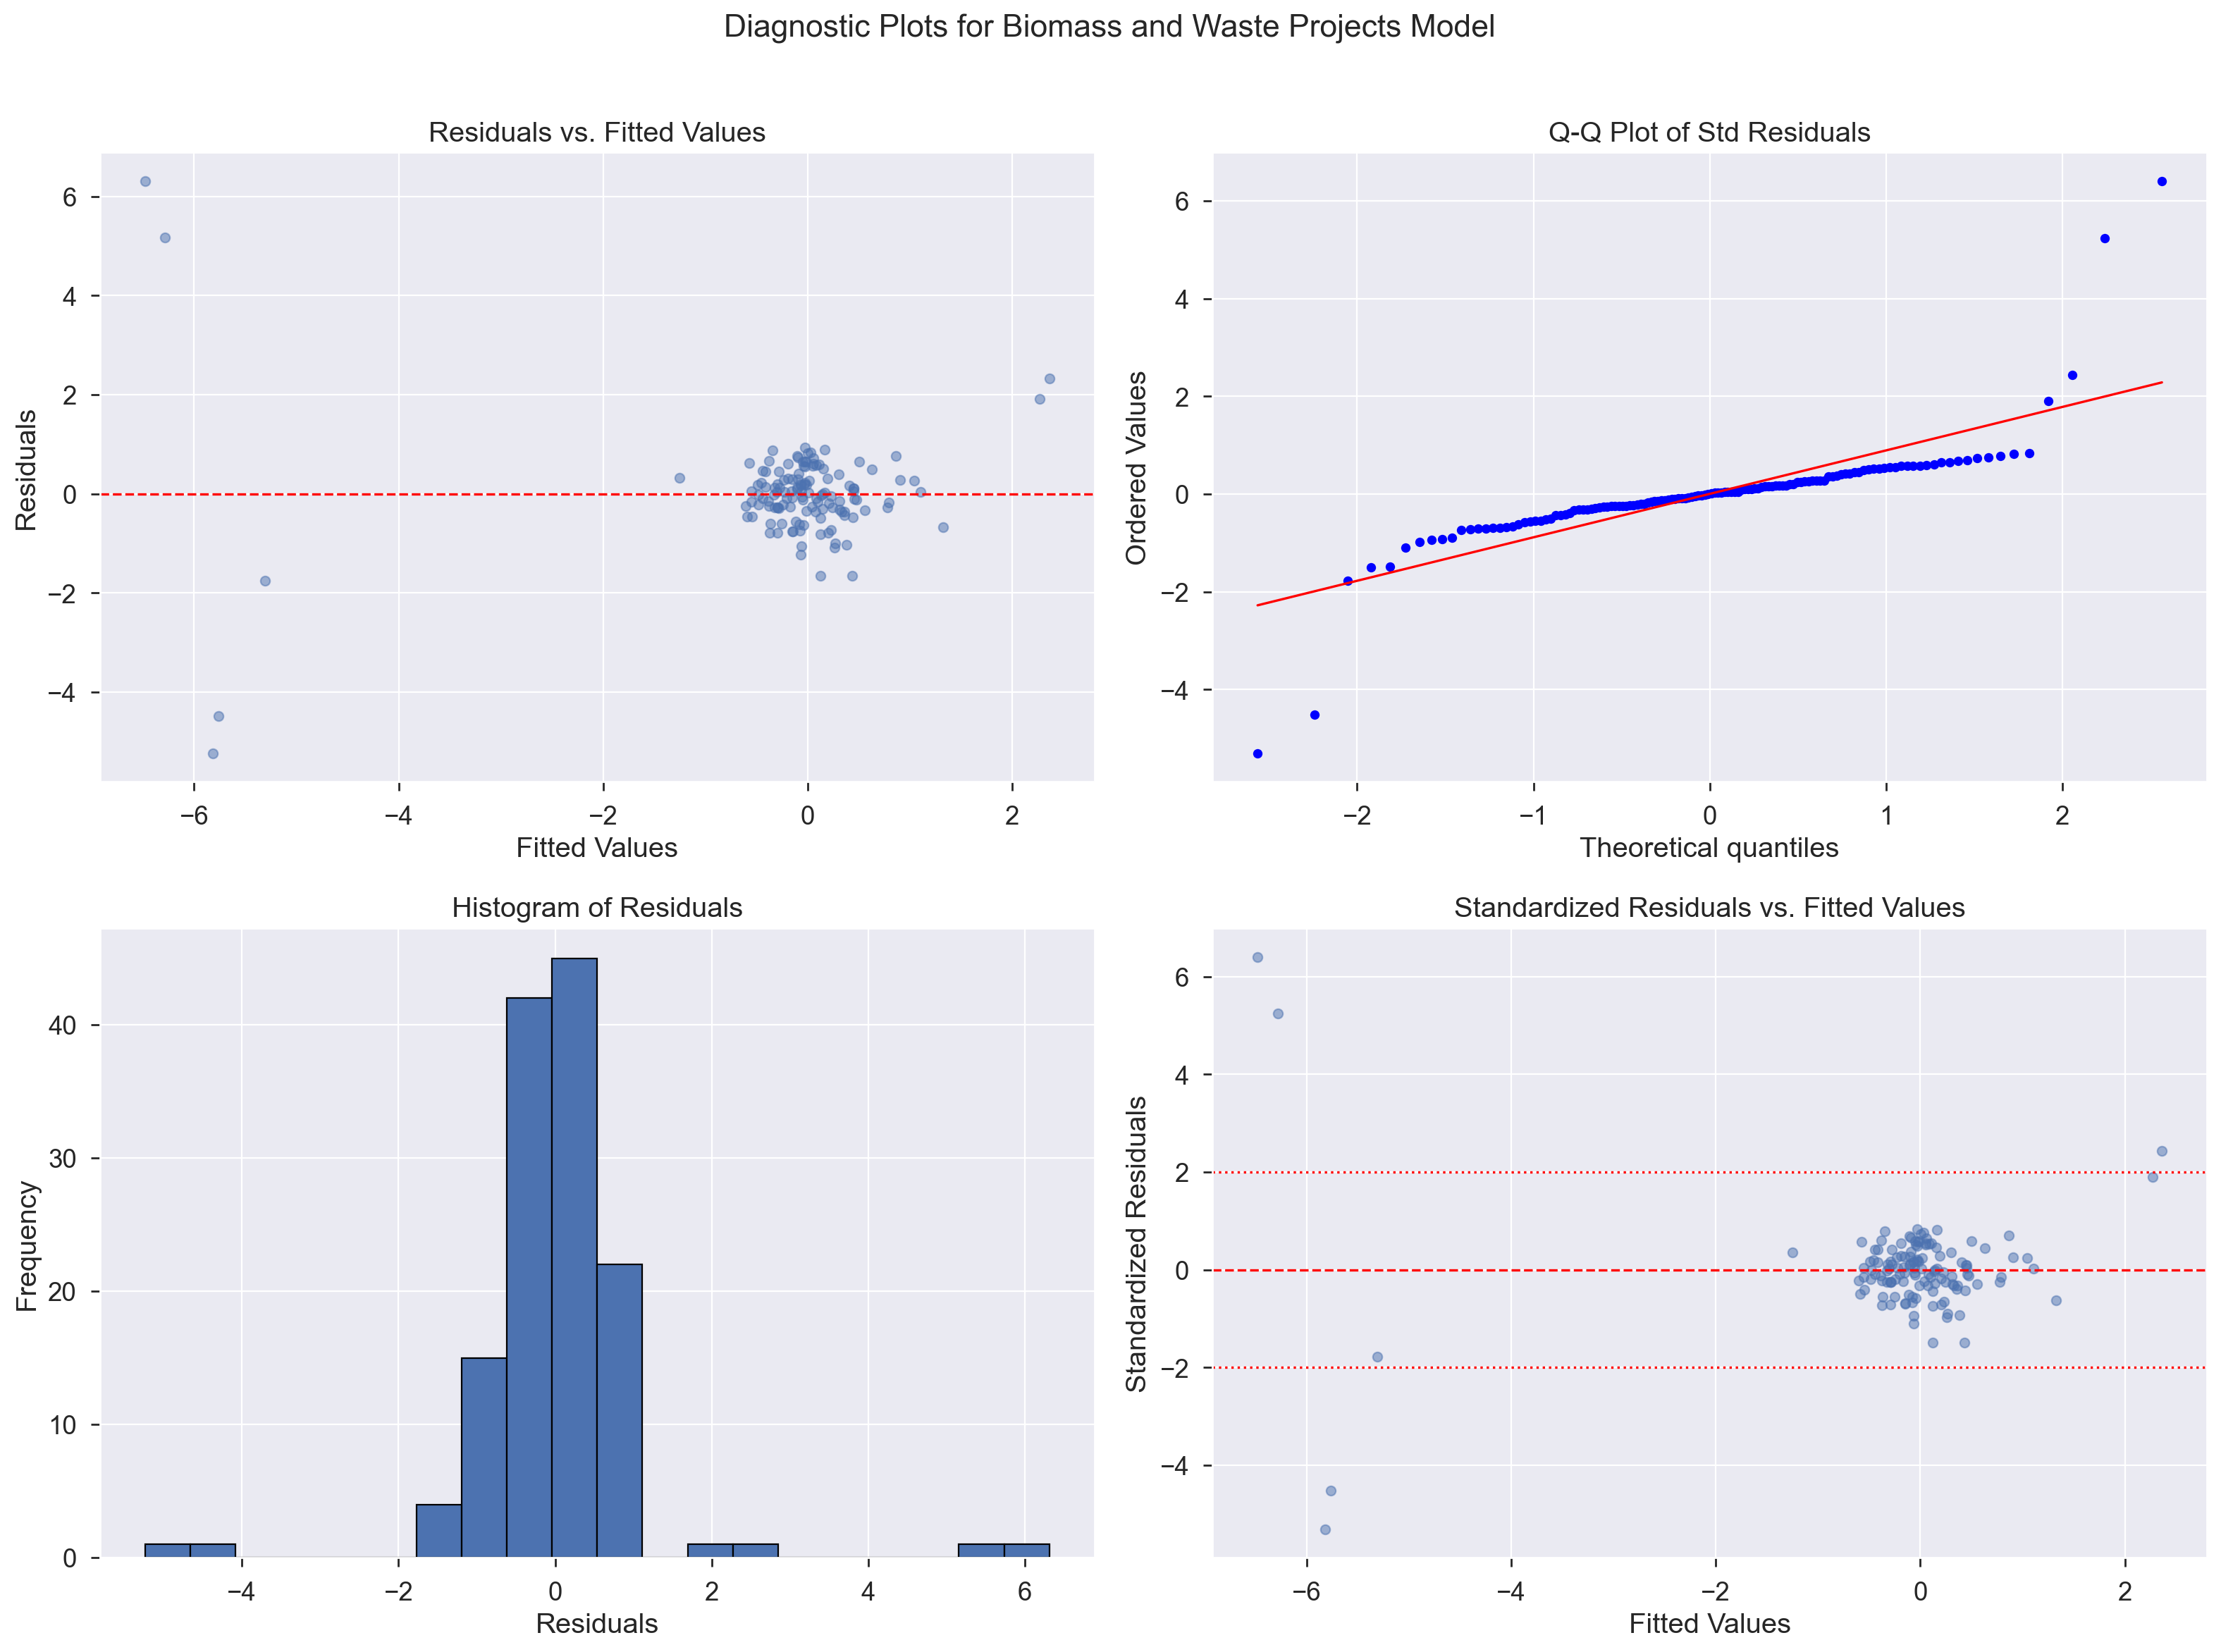

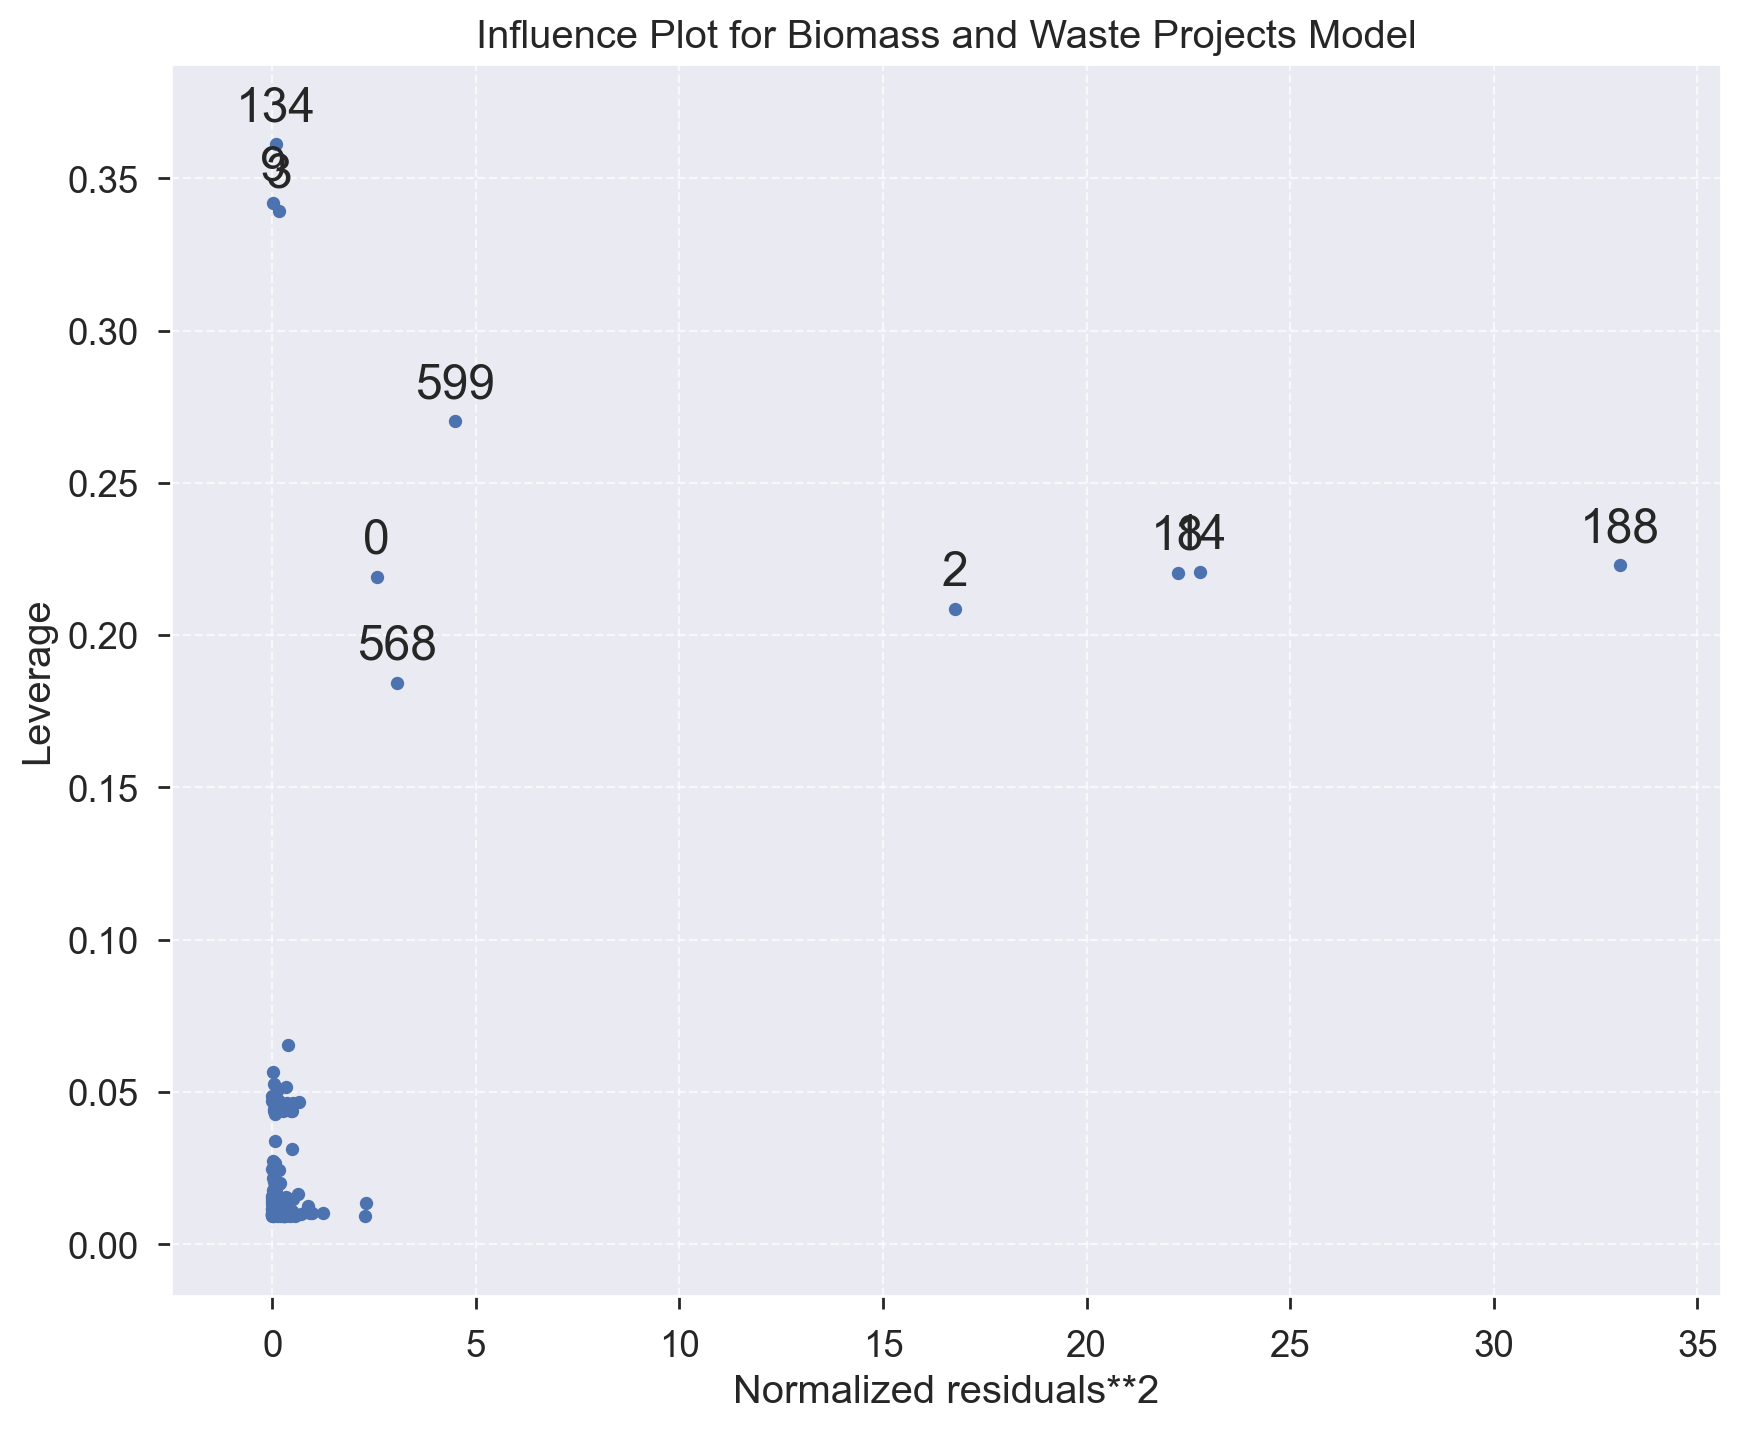


Running model for Other Renewable projects (n=127)

Other Renewable Projects Model Results:
Observations: 127.0
R-squared: 0.1219
Adjusted R-squared: 0.1005
F-statistic: 5.69 (p-value: 0.0011)
AIC: 427.62
BIC: 439.00

Coefficients:
                     Coefficient     Std Error   t-value   p-value  \
Intercept          -1.298009e+00  3.276120e-01 -3.962032  0.000125   
log_t_actual_years  3.781688e-01  1.695159e-01  2.230875  0.027502   
Is_CDM              6.007795e-01  5.269767e-01  1.140049  0.256481   
Is_International    5.184461e-01  4.743039e-01  1.093067  0.276500   
Scale_Large        -3.140667e-18  5.500228e-16 -0.005710  0.995453   

                   Significance  
Intercept                   ***  
log_t_actual_years            *  
Is_CDM                           
Is_International                 
Scale_Large                      

Variance Inflation Factors (VIF):
             Variable       VIF
4              Is_CDM  3.682850
3    Is_International  3.525861
1  log_t_ac

c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


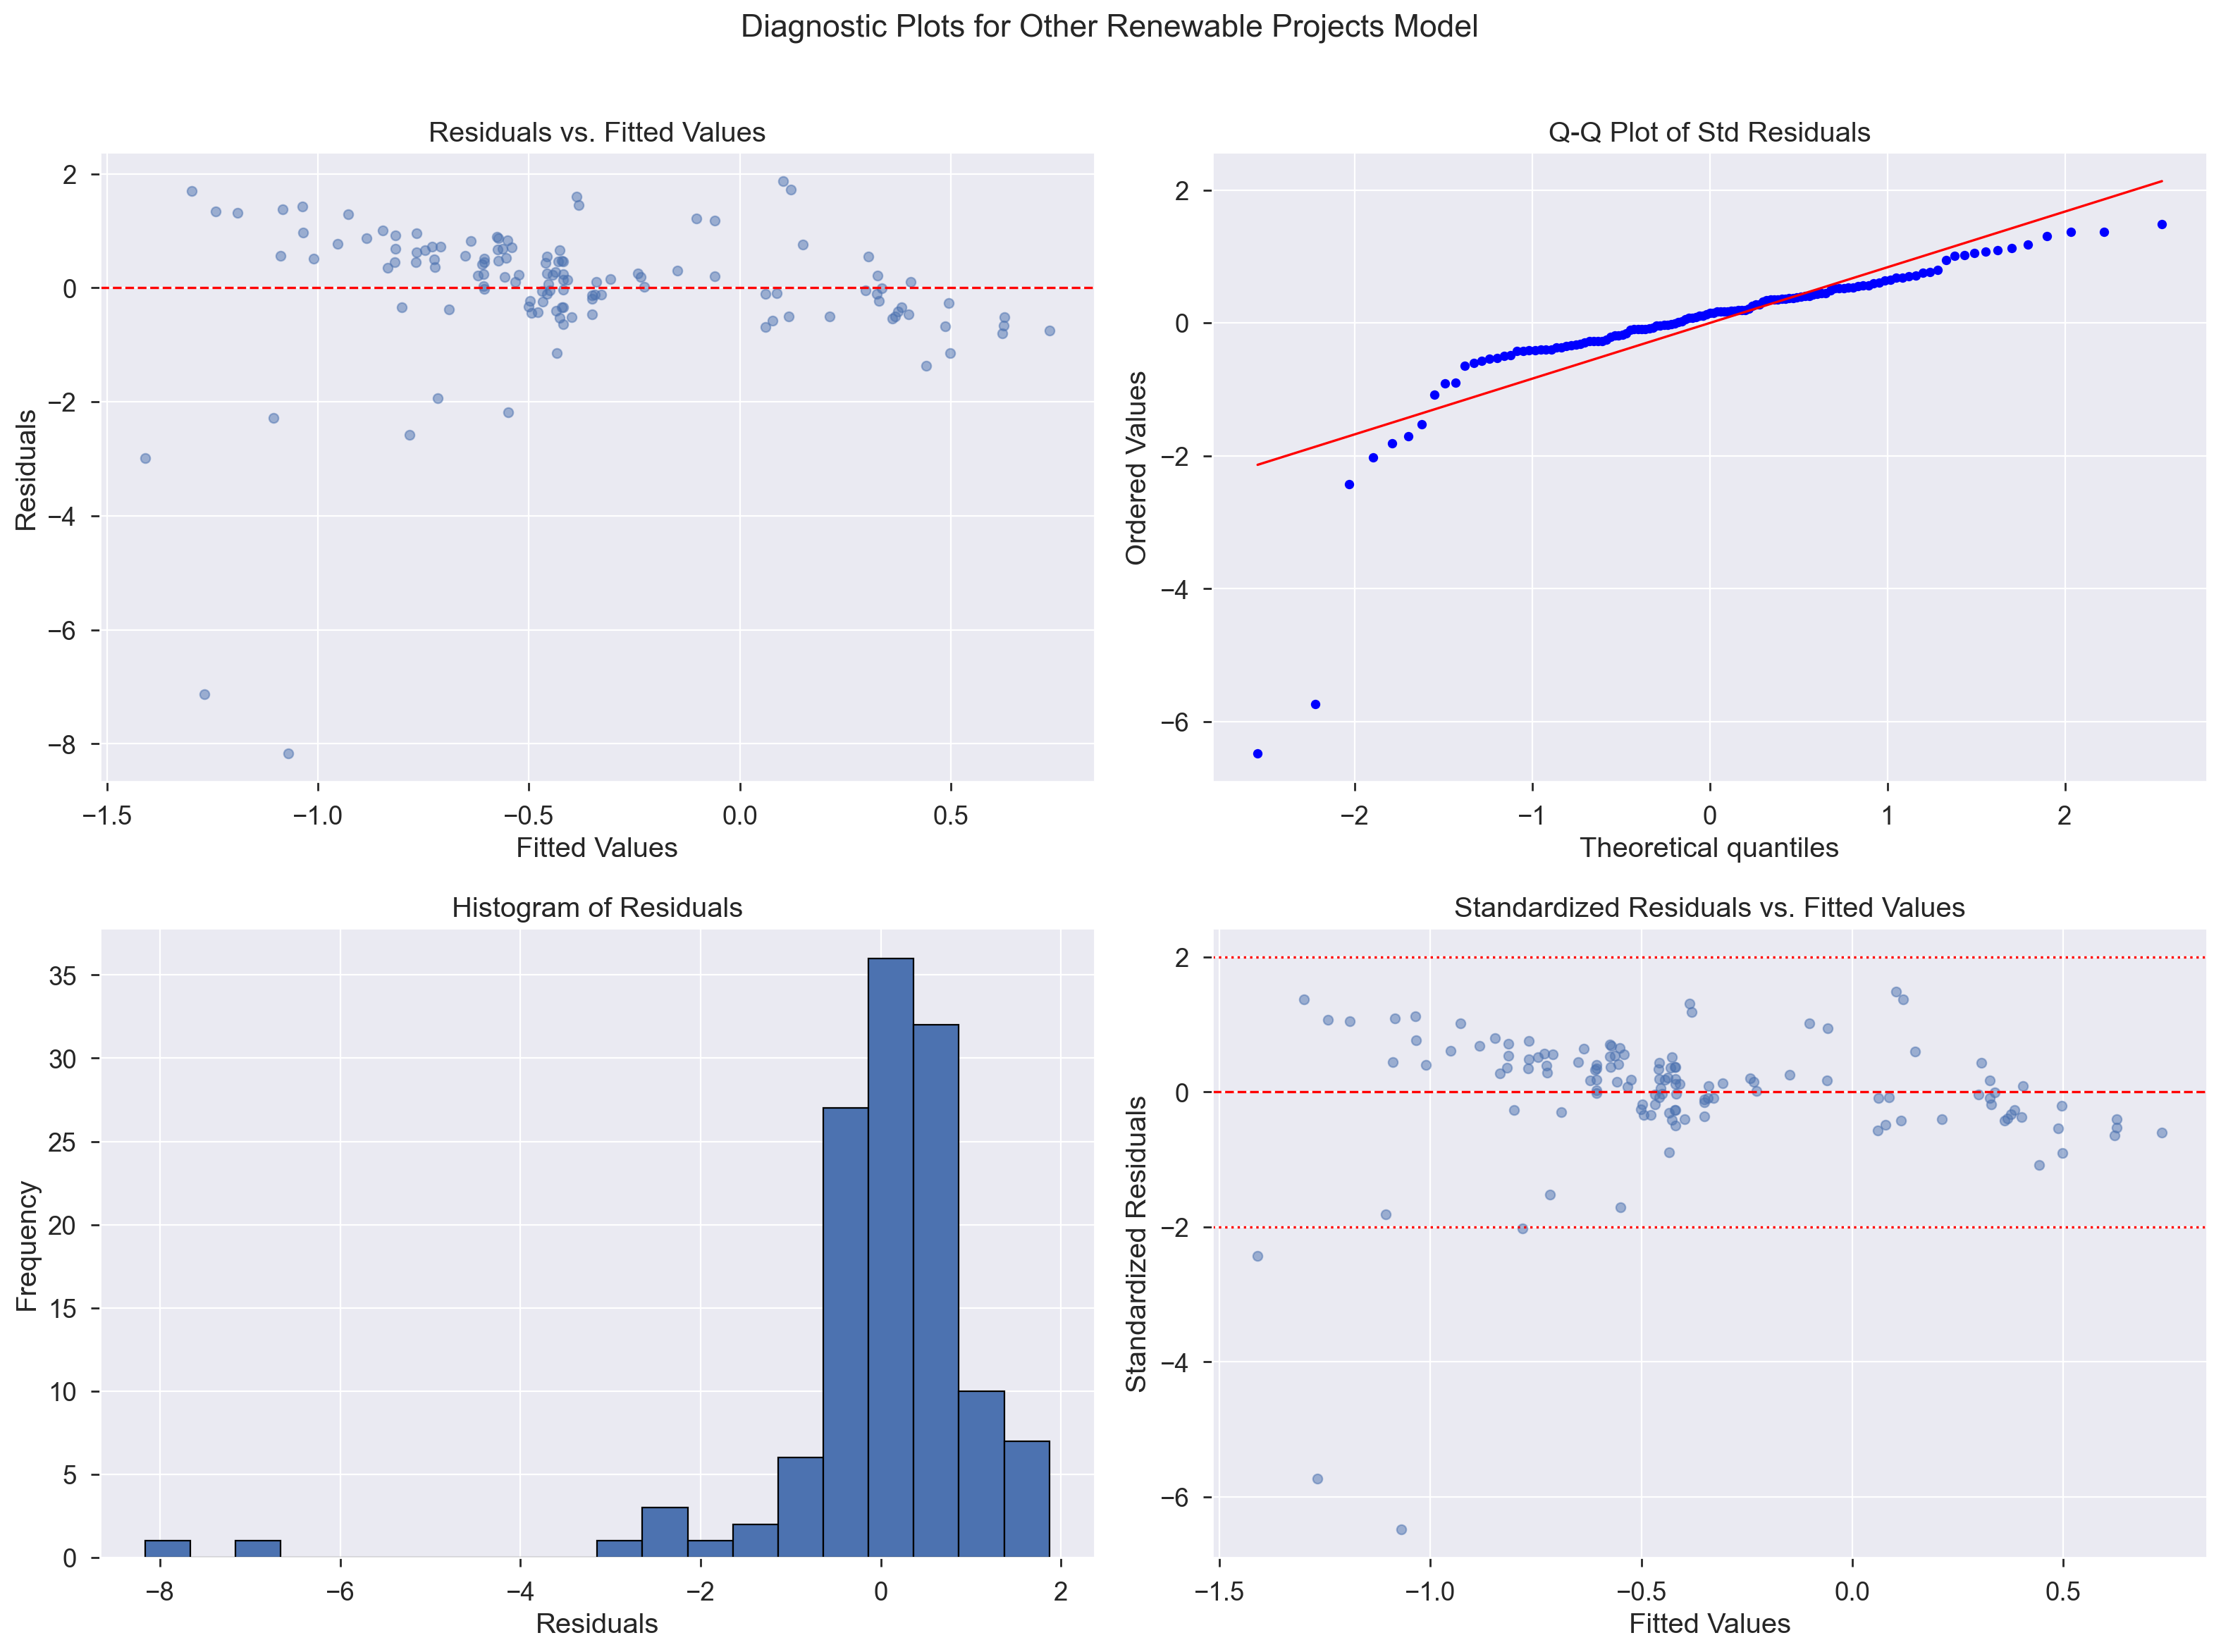

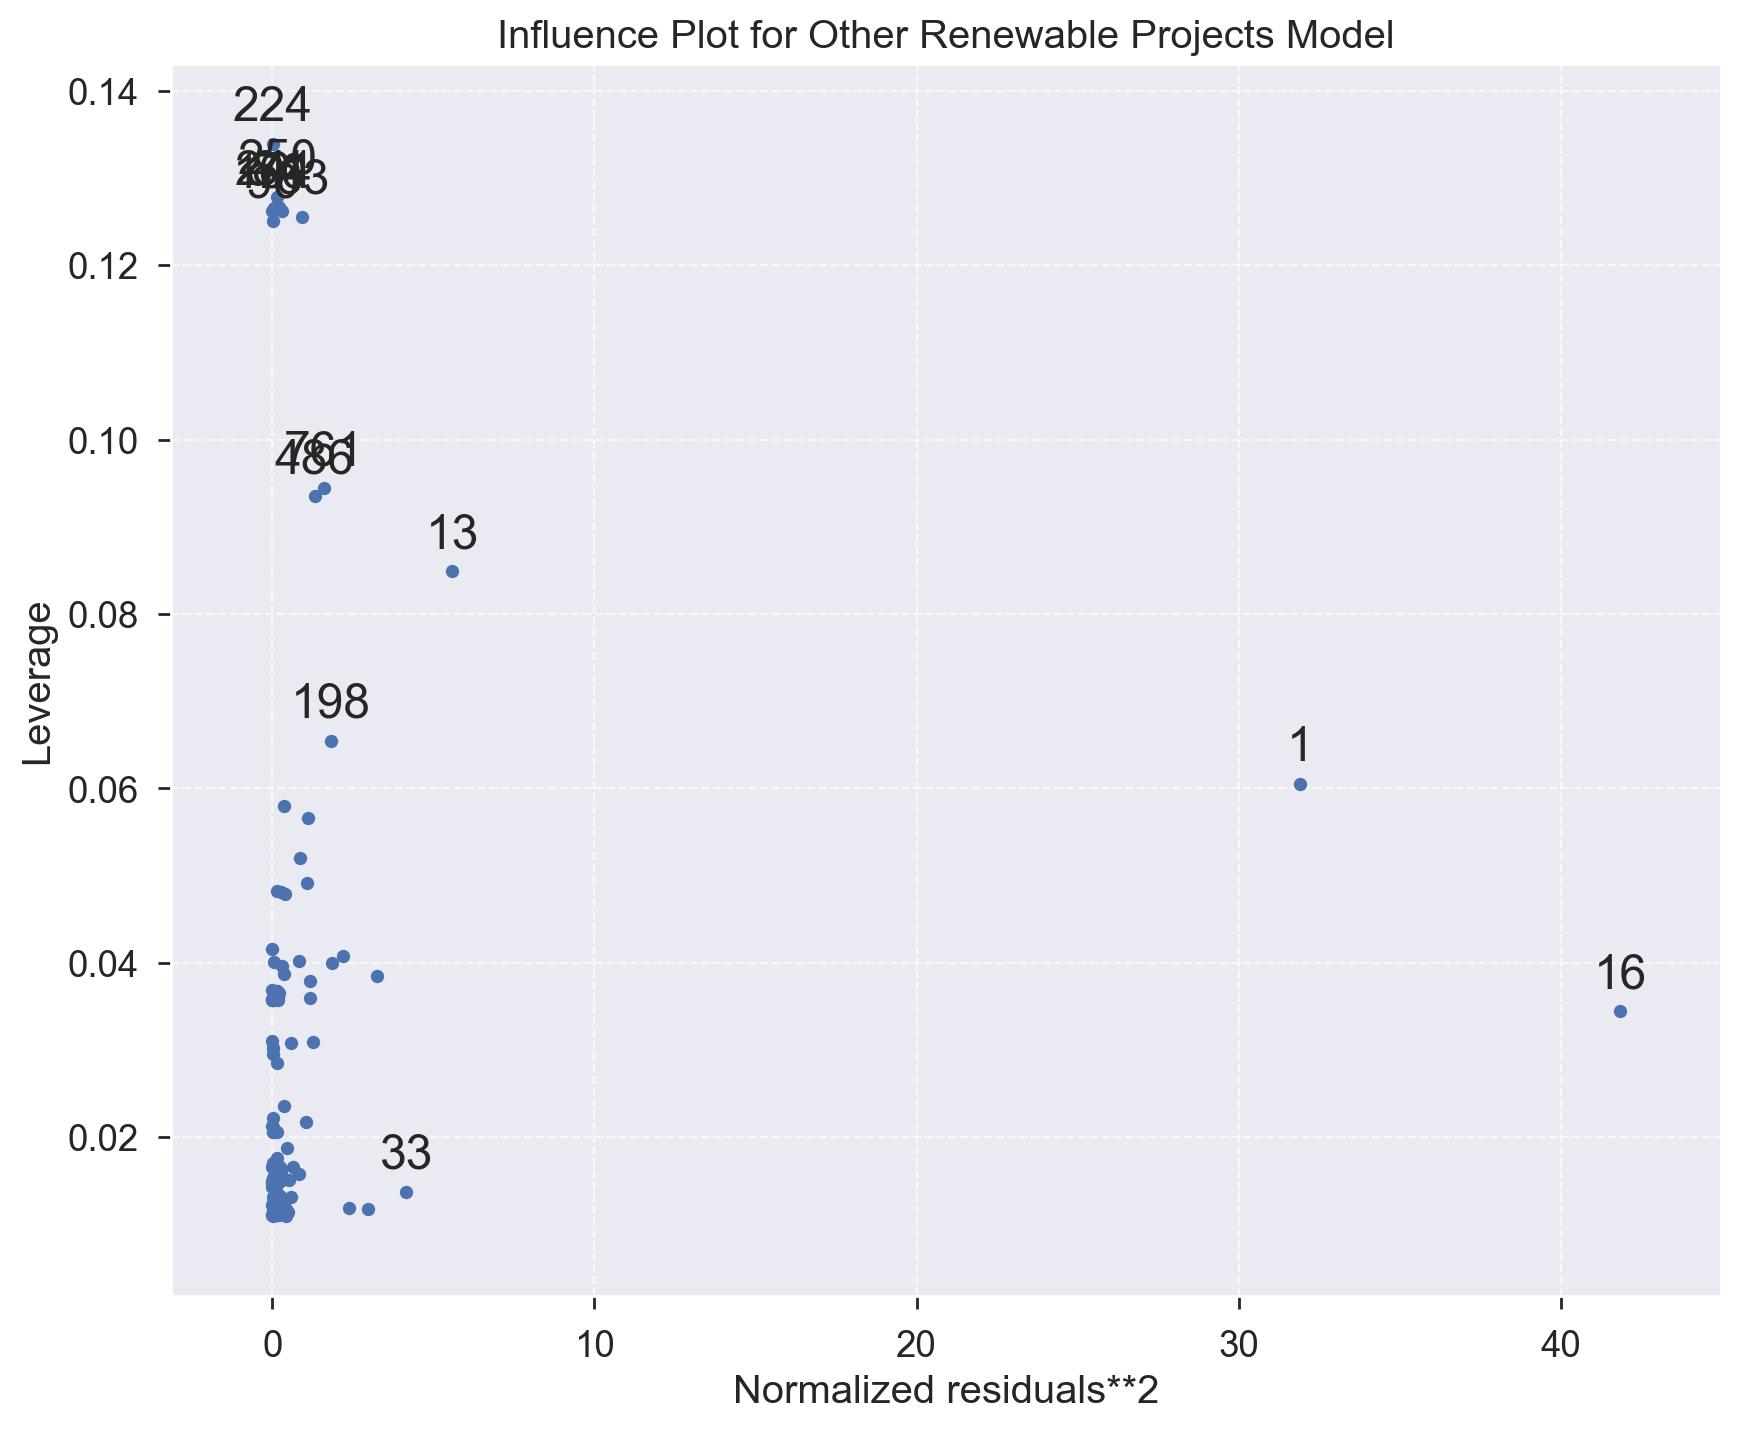


Running model for Other projects (n=203)

Other Projects Model Results:
Observations: 203.0
R-squared: 0.0214
Adjusted R-squared: 0.0067
F-statistic: 1.45 (p-value: 0.2293)
AIC: 646.05
BIC: 659.30

Coefficients:
                    Coefficient  Std Error   t-value   p-value Significance
Intercept             -0.315804   0.113226 -2.789148  0.005798           **
Scale_Large           -0.315804   0.113226 -2.789148  0.005798           **
log_t_actual_years     0.139257   0.114792  1.213130  0.226518             
Is_International       0.447536   0.463023  0.966552  0.334941             
Is_CDM                -0.109295   0.471211 -0.231944  0.816819             

Variance Inflation Factors (VIF):
             Variable       VIF
1         Scale_Large  7.520542
2    Is_International  7.004136
3              Is_CDM  6.844707
0  log_t_actual_years  1.070602


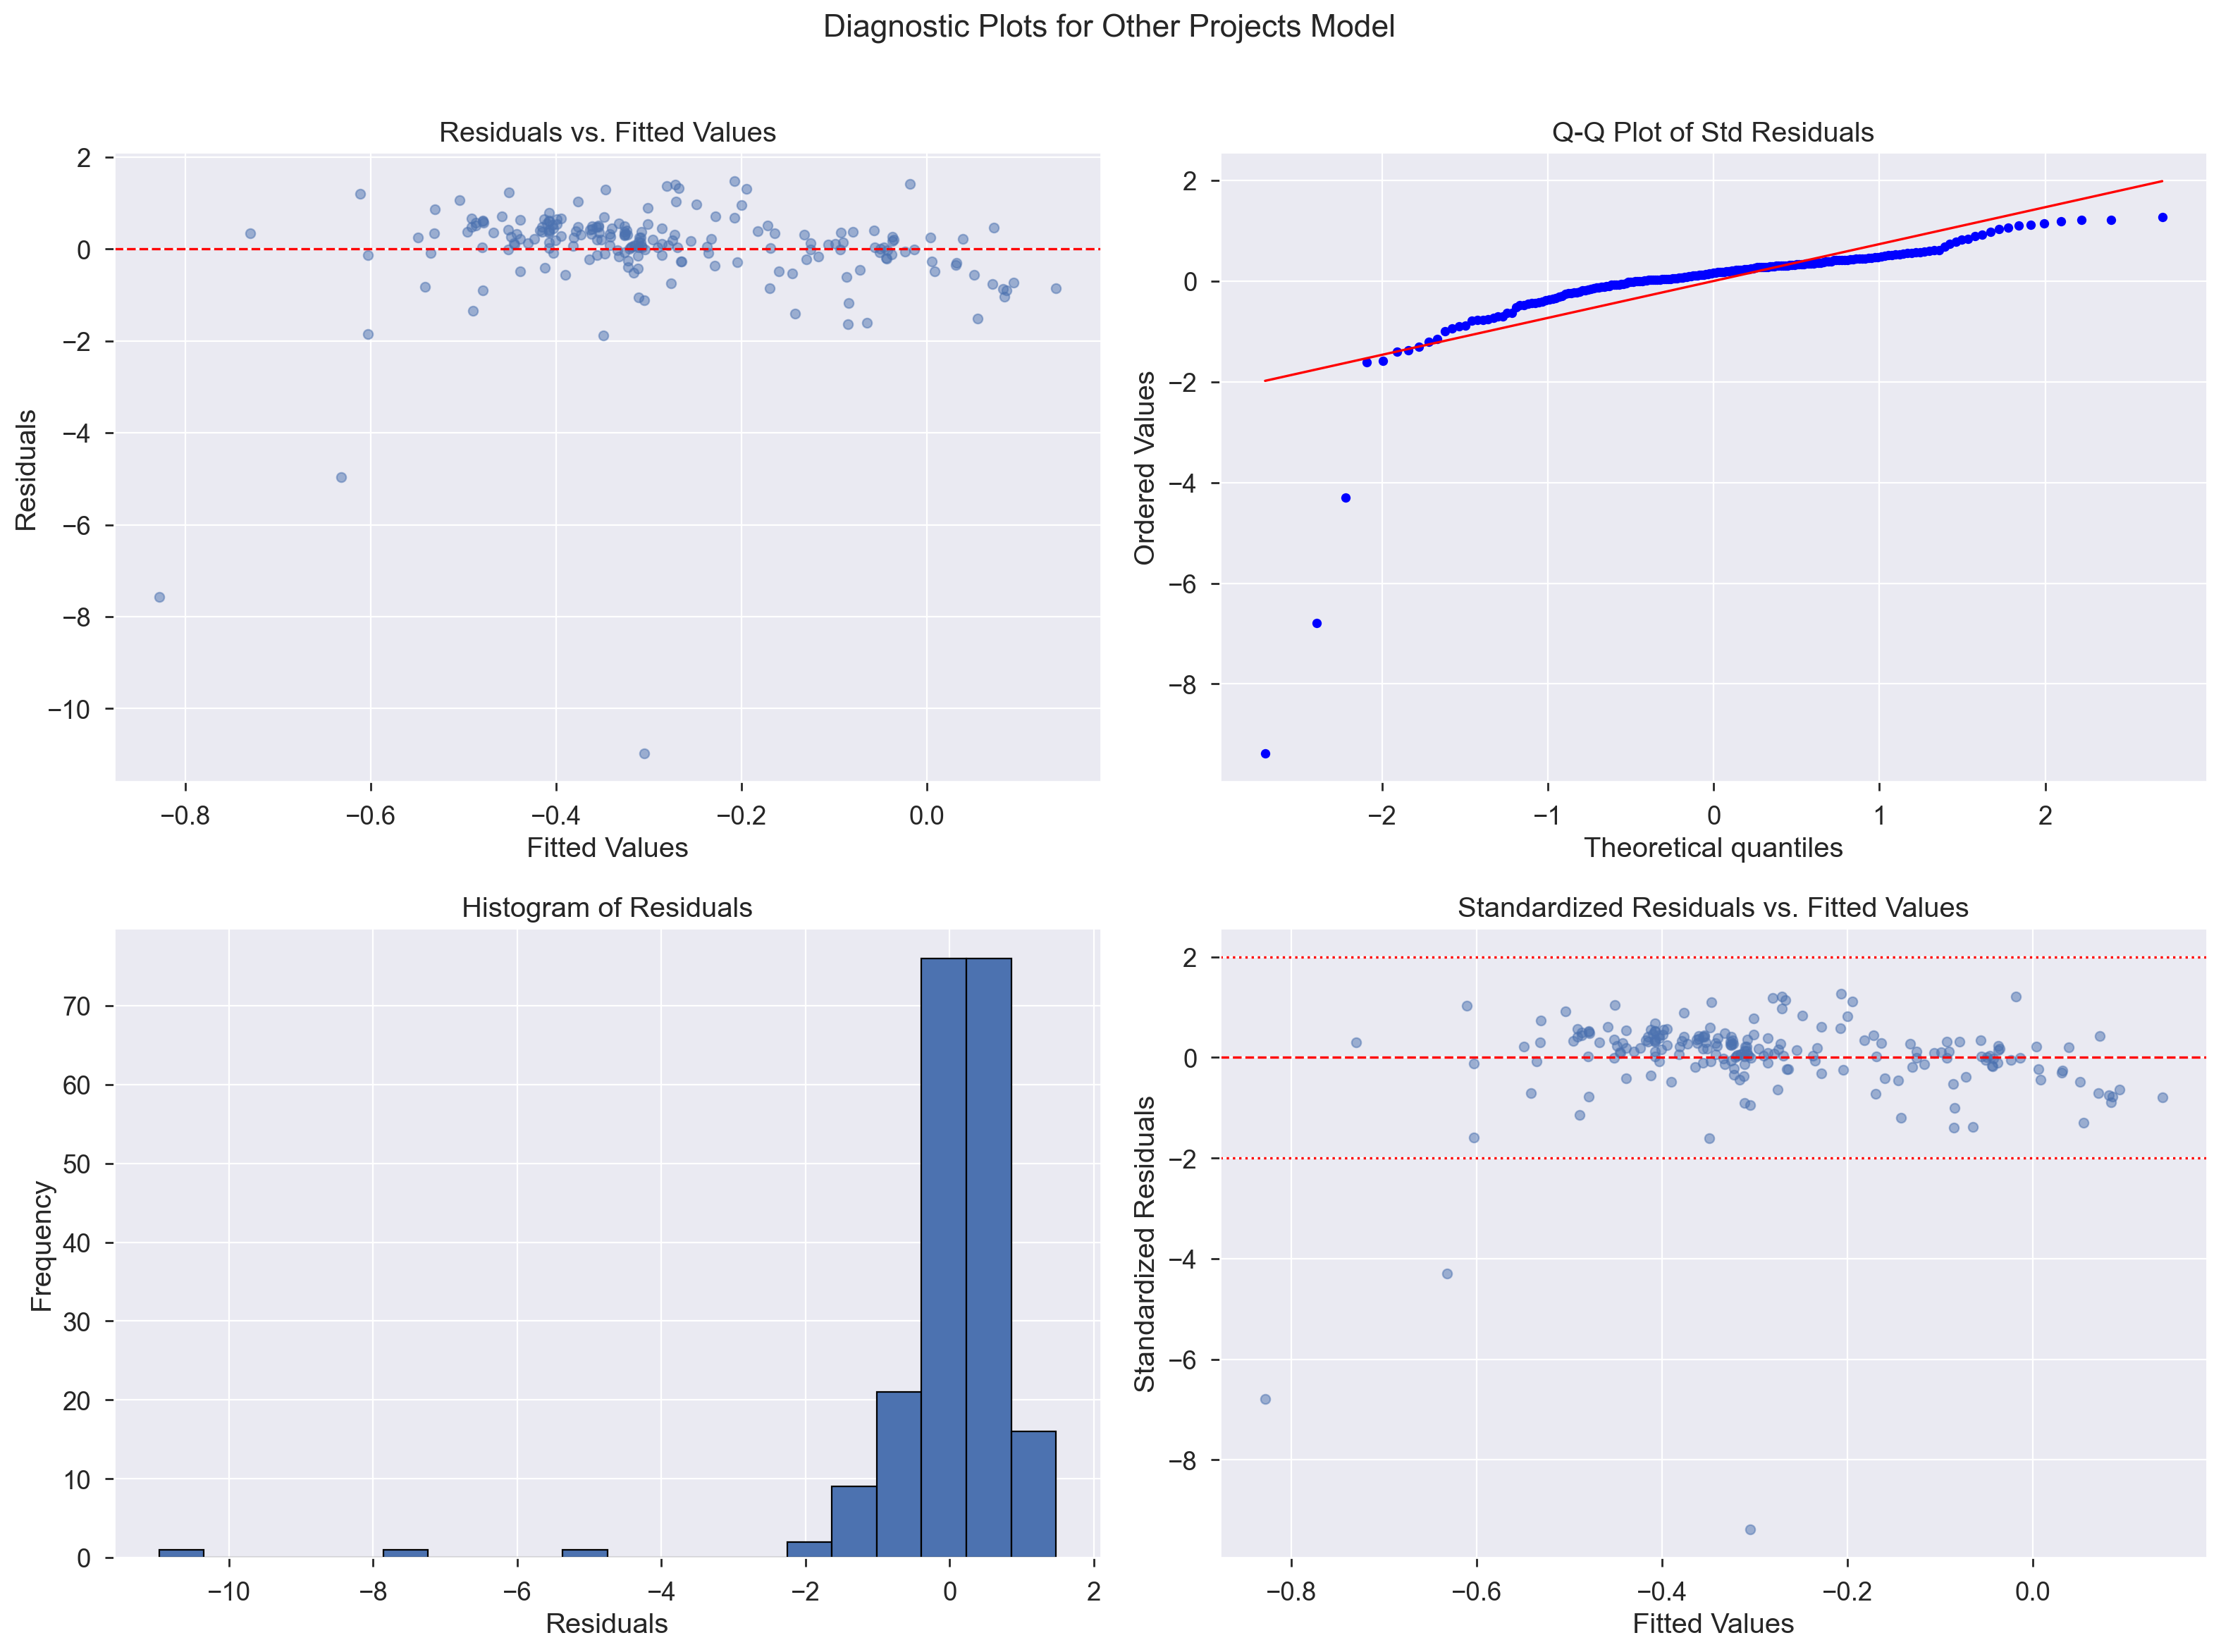

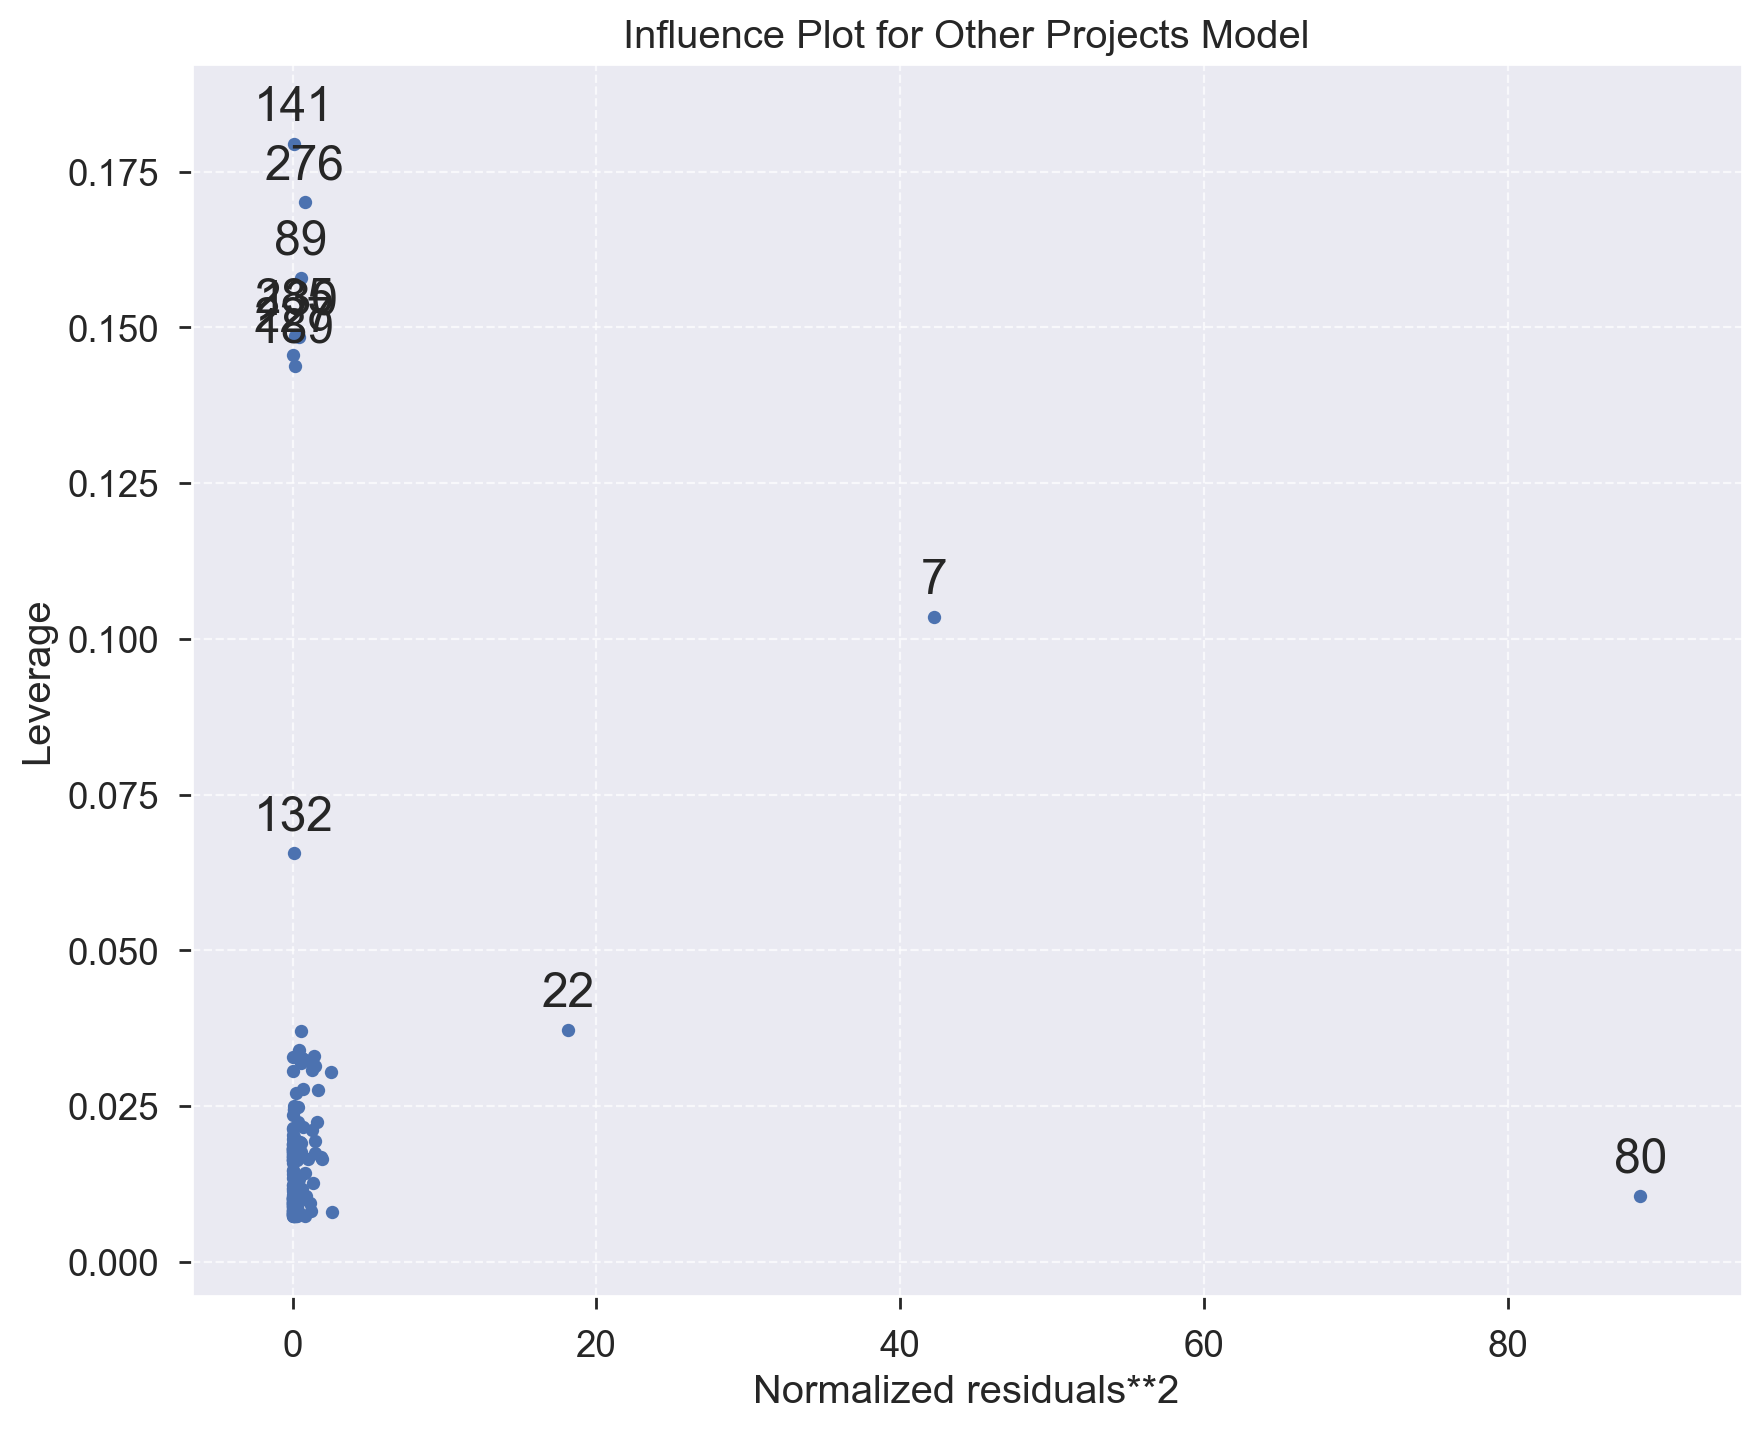


Running model for Hydro projects (n=58)

Hydro Projects Model Results:
Observations: 58.0
R-squared: 0.5301
Adjusted R-squared: 0.5130
F-statistic: 31.02 (p-value: 0.0000)
AIC: 71.00
BIC: 77.19

Coefficients:
                    Coefficient  Std Error   t-value       p-value  \
log_t_actual_years    -0.552517   0.070344 -7.854453  1.506386e-10   
Is_International       0.354442   0.047503  7.461425  6.615912e-10   
Is_CDM                 0.354442   0.047503  7.461425  6.615912e-10   
Intercept              0.354442   0.047503  7.461425  6.615912e-10   
Scale_Large           -0.211398   0.131610 -1.606245  1.139470e-01   

                   Significance  
log_t_actual_years          ***  
Is_International            ***  
Is_CDM                      ***  
Intercept                   ***  
Scale_Large                      

Variance Inflation Factors (VIF):
             Variable       VIF
0  log_t_actual_years  1.017137
1         Scale_Large  1.017137
2    Is_International  0.000000
3 

c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


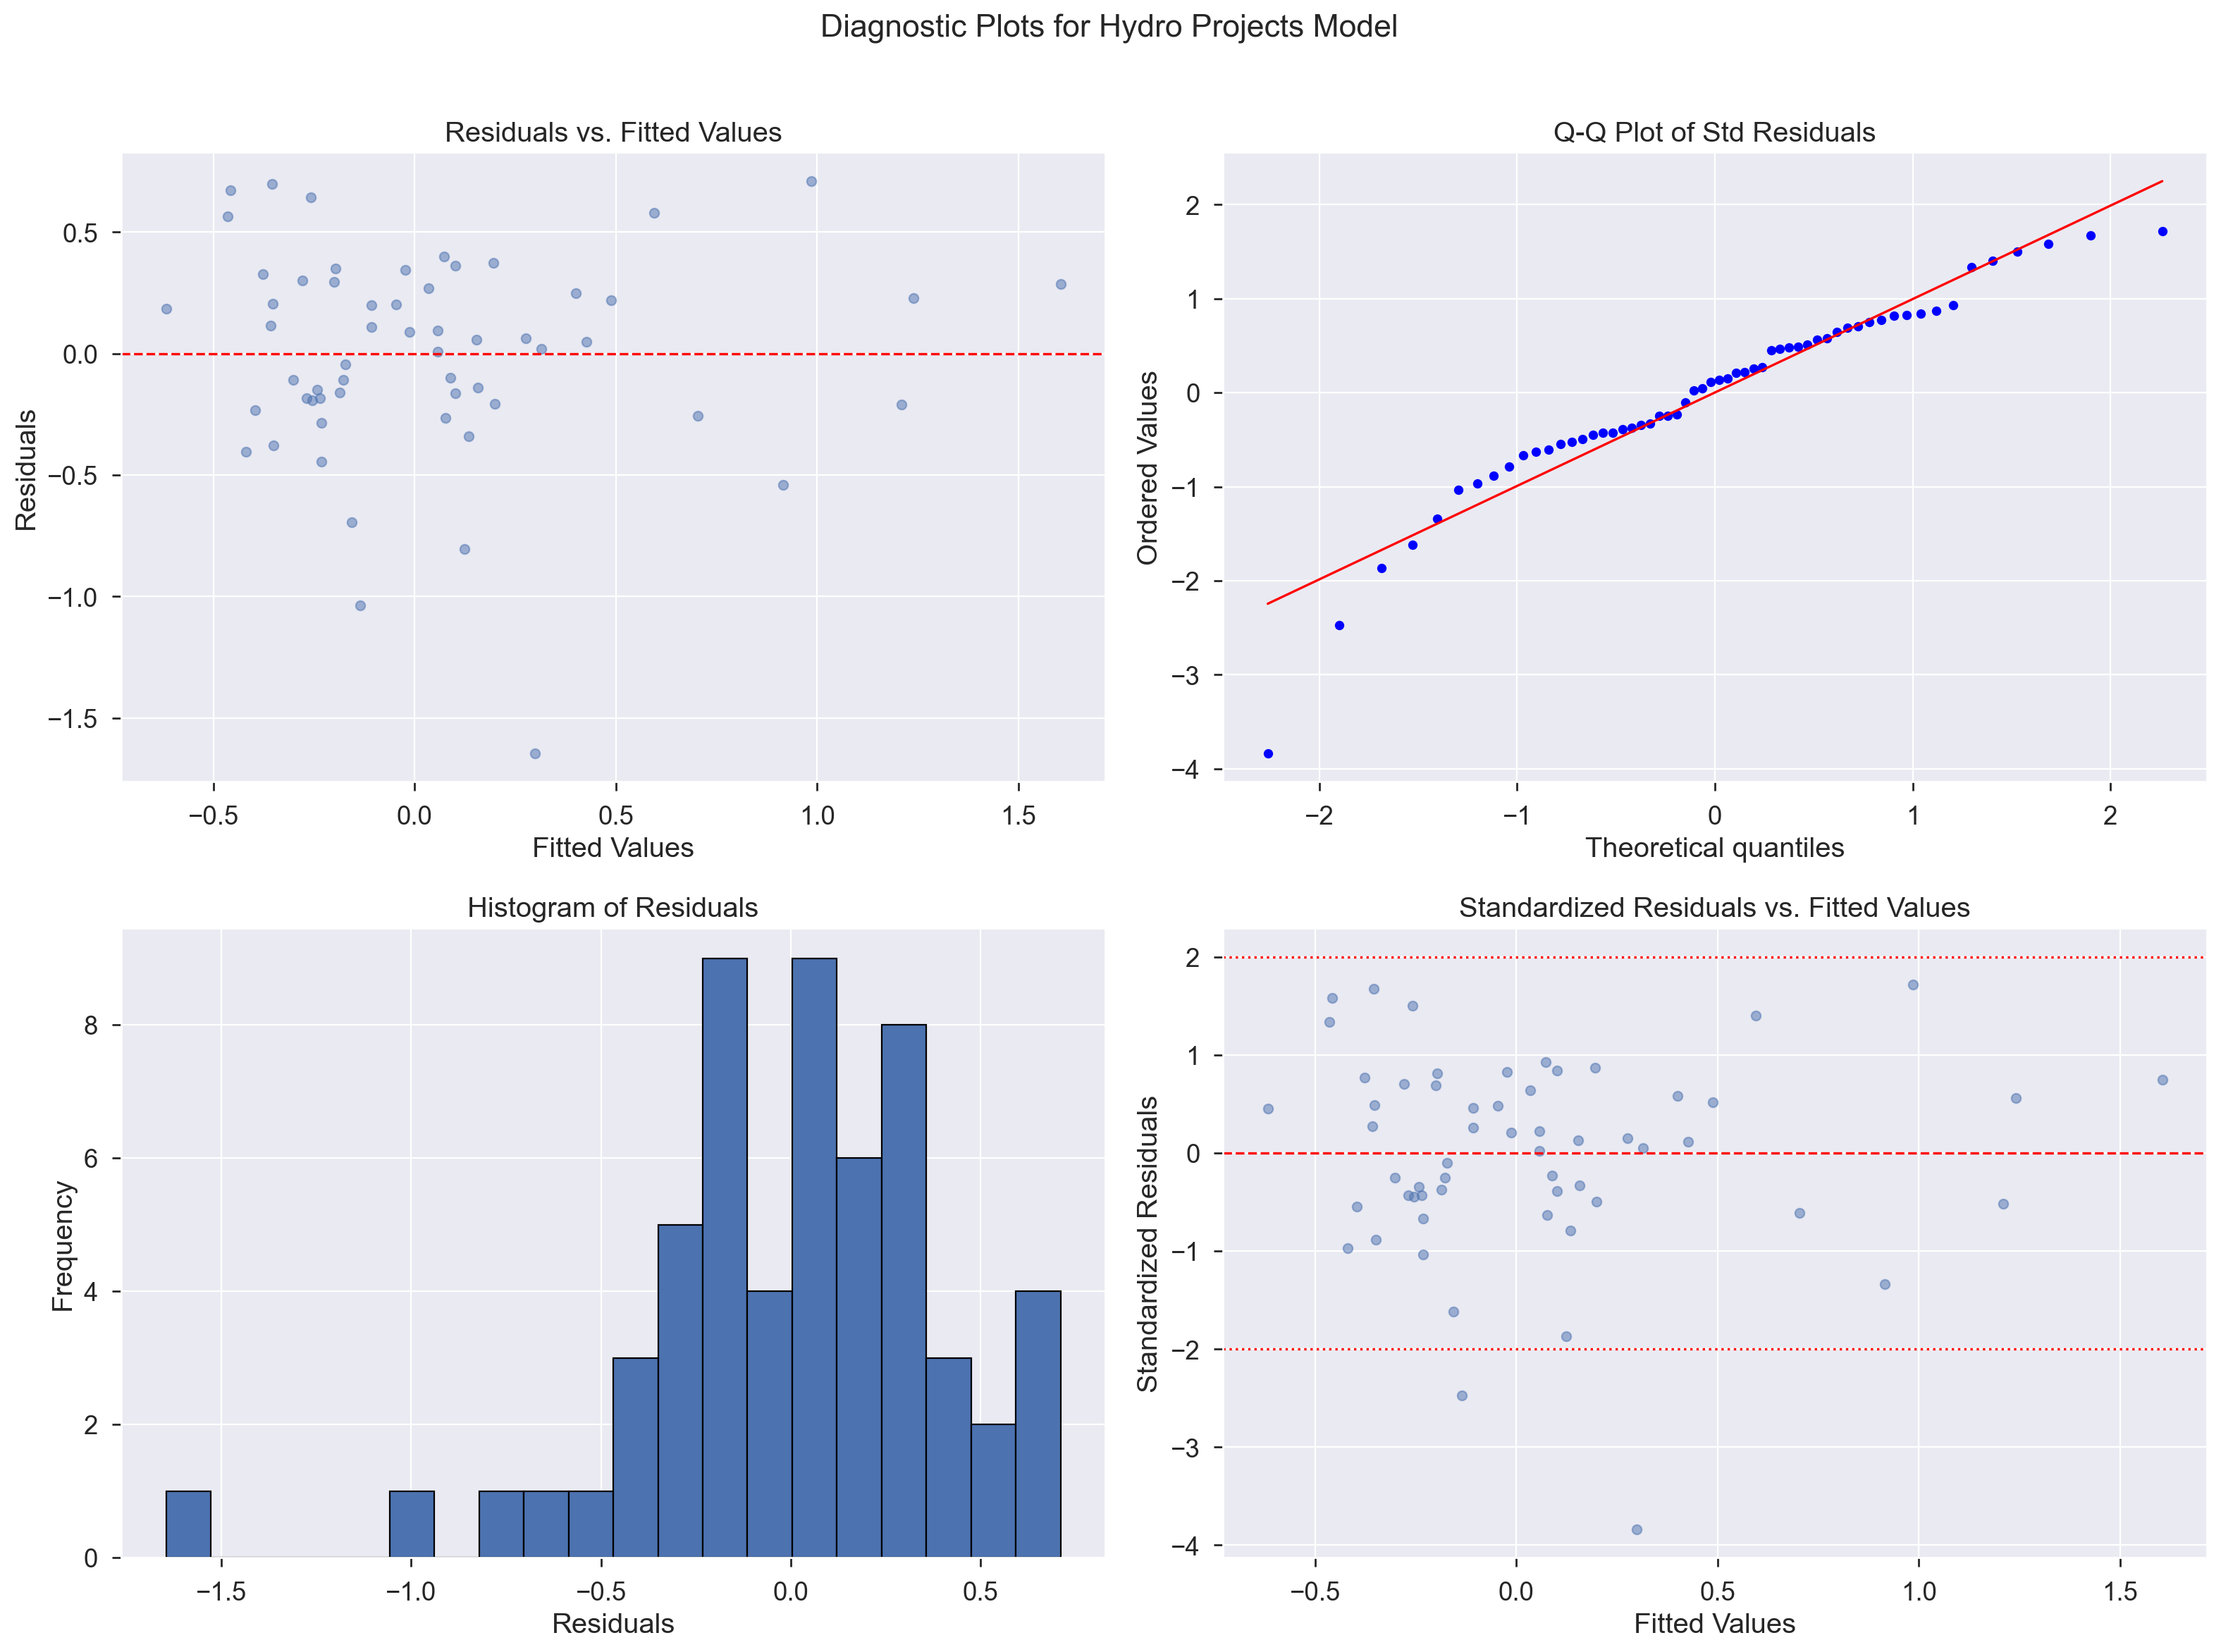

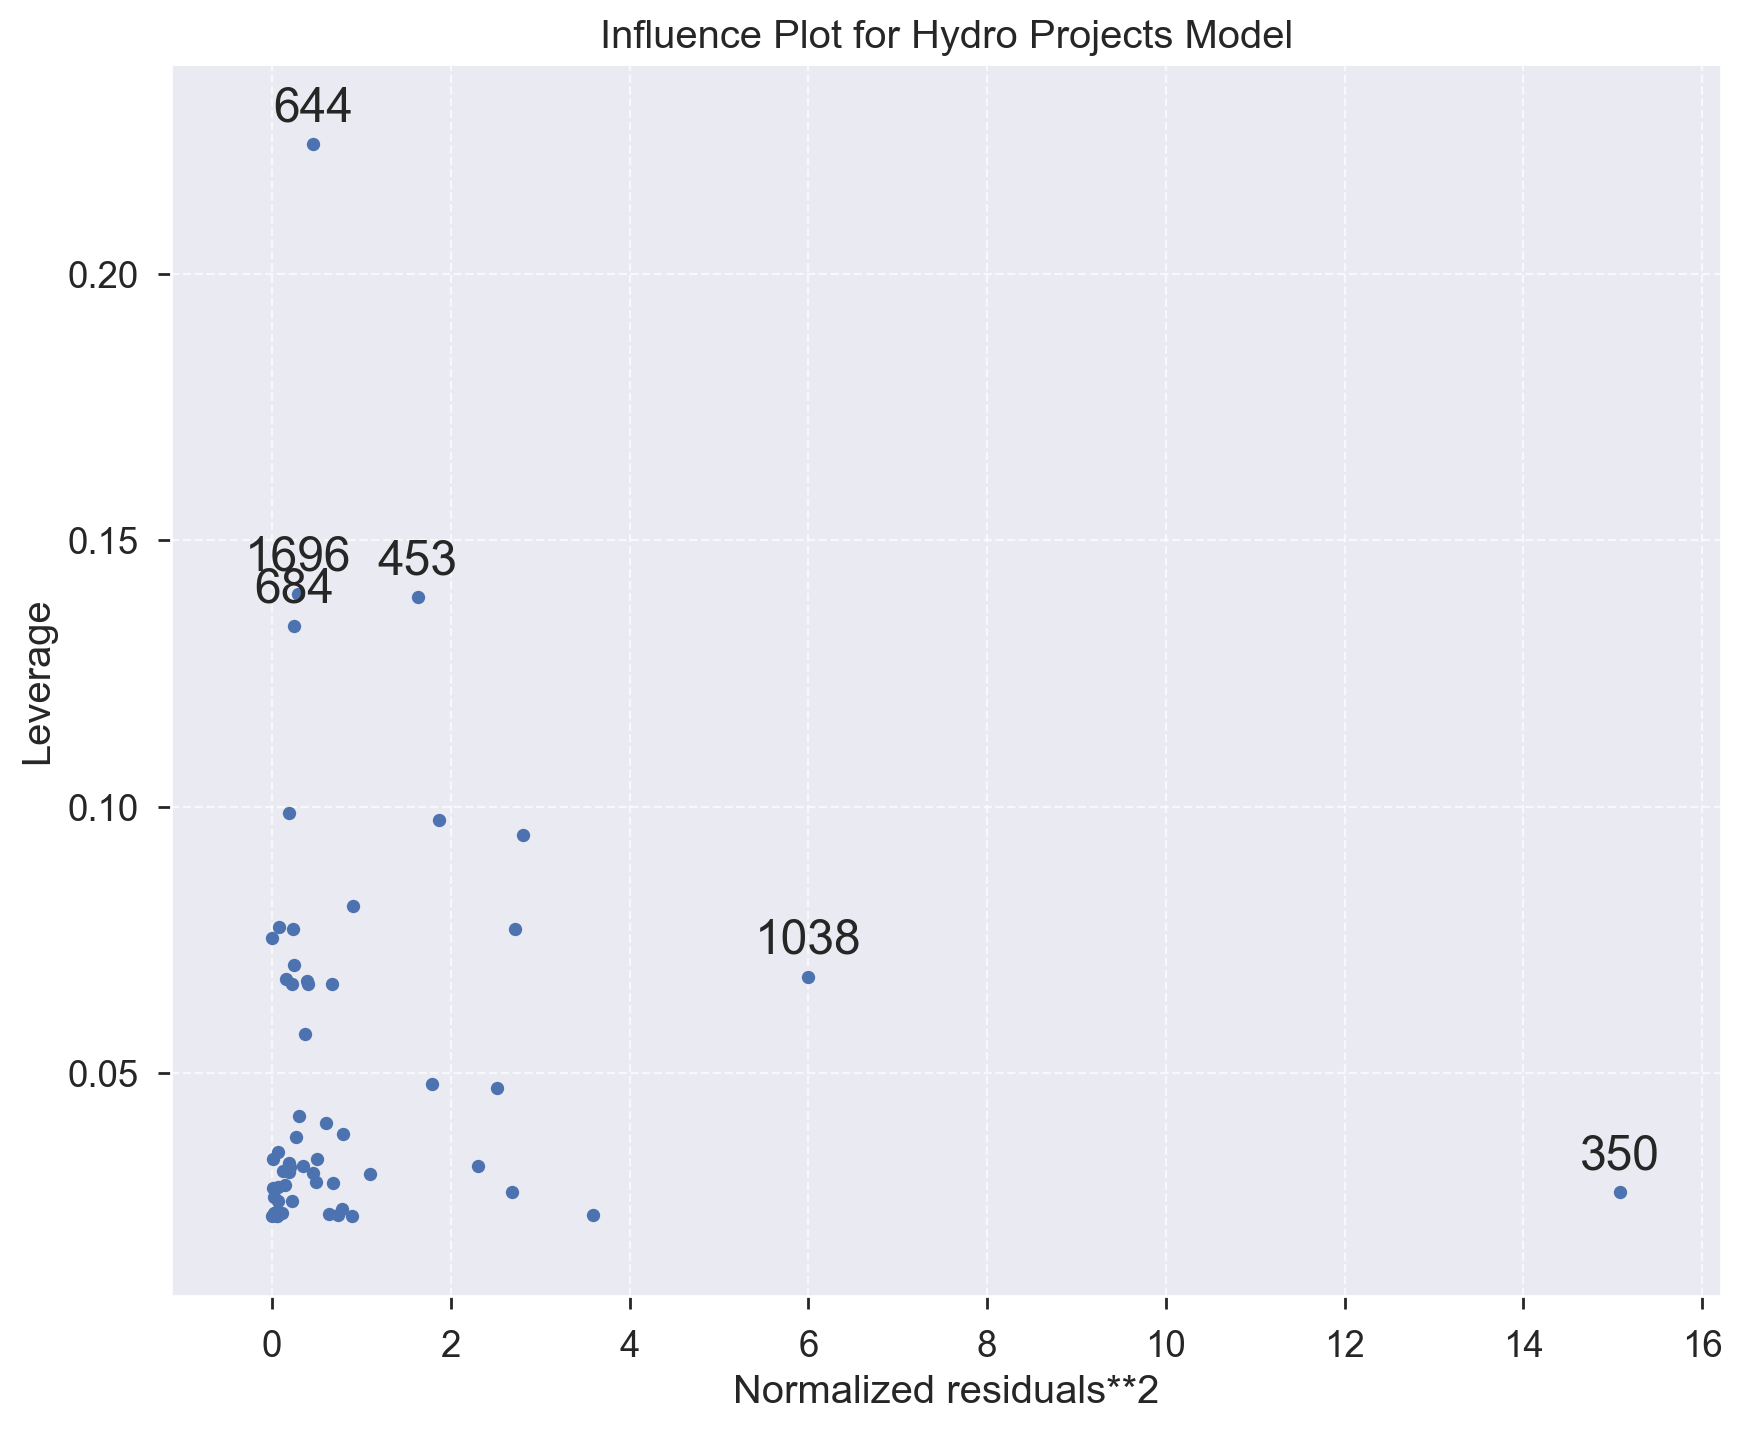


Running model for Wind projects (n=198)

Wind Projects Model Results:
Observations: 198.0
R-squared: 0.7914
Adjusted R-squared: 0.7892
F-statistic: 369.85 (p-value: 0.0000)
AIC: 162.34
BIC: 172.21

Coefficients:
                    Coefficient  Std Error    t-value       p-value  \
log_t_actual_years    -0.699245   0.025710 -27.197085  2.787847e-68   
Intercept              0.388918   0.016923  22.981300  2.128017e-57   
Is_CDM                 0.388918   0.016923  22.981300  2.128017e-57   
Is_International       0.388918   0.016923  22.981300  2.128017e-57   
Scale_Large            0.104015   0.052119   1.995734  4.735459e-02   

                   Significance  
log_t_actual_years          ***  
Intercept                   ***  
Is_CDM                      ***  
Is_International            ***  
Scale_Large                   *  

Variance Inflation Factors (VIF):
             Variable       VIF
0  log_t_actual_years  1.006332
1         Scale_Large  1.006332
2    Is_International  0.

c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


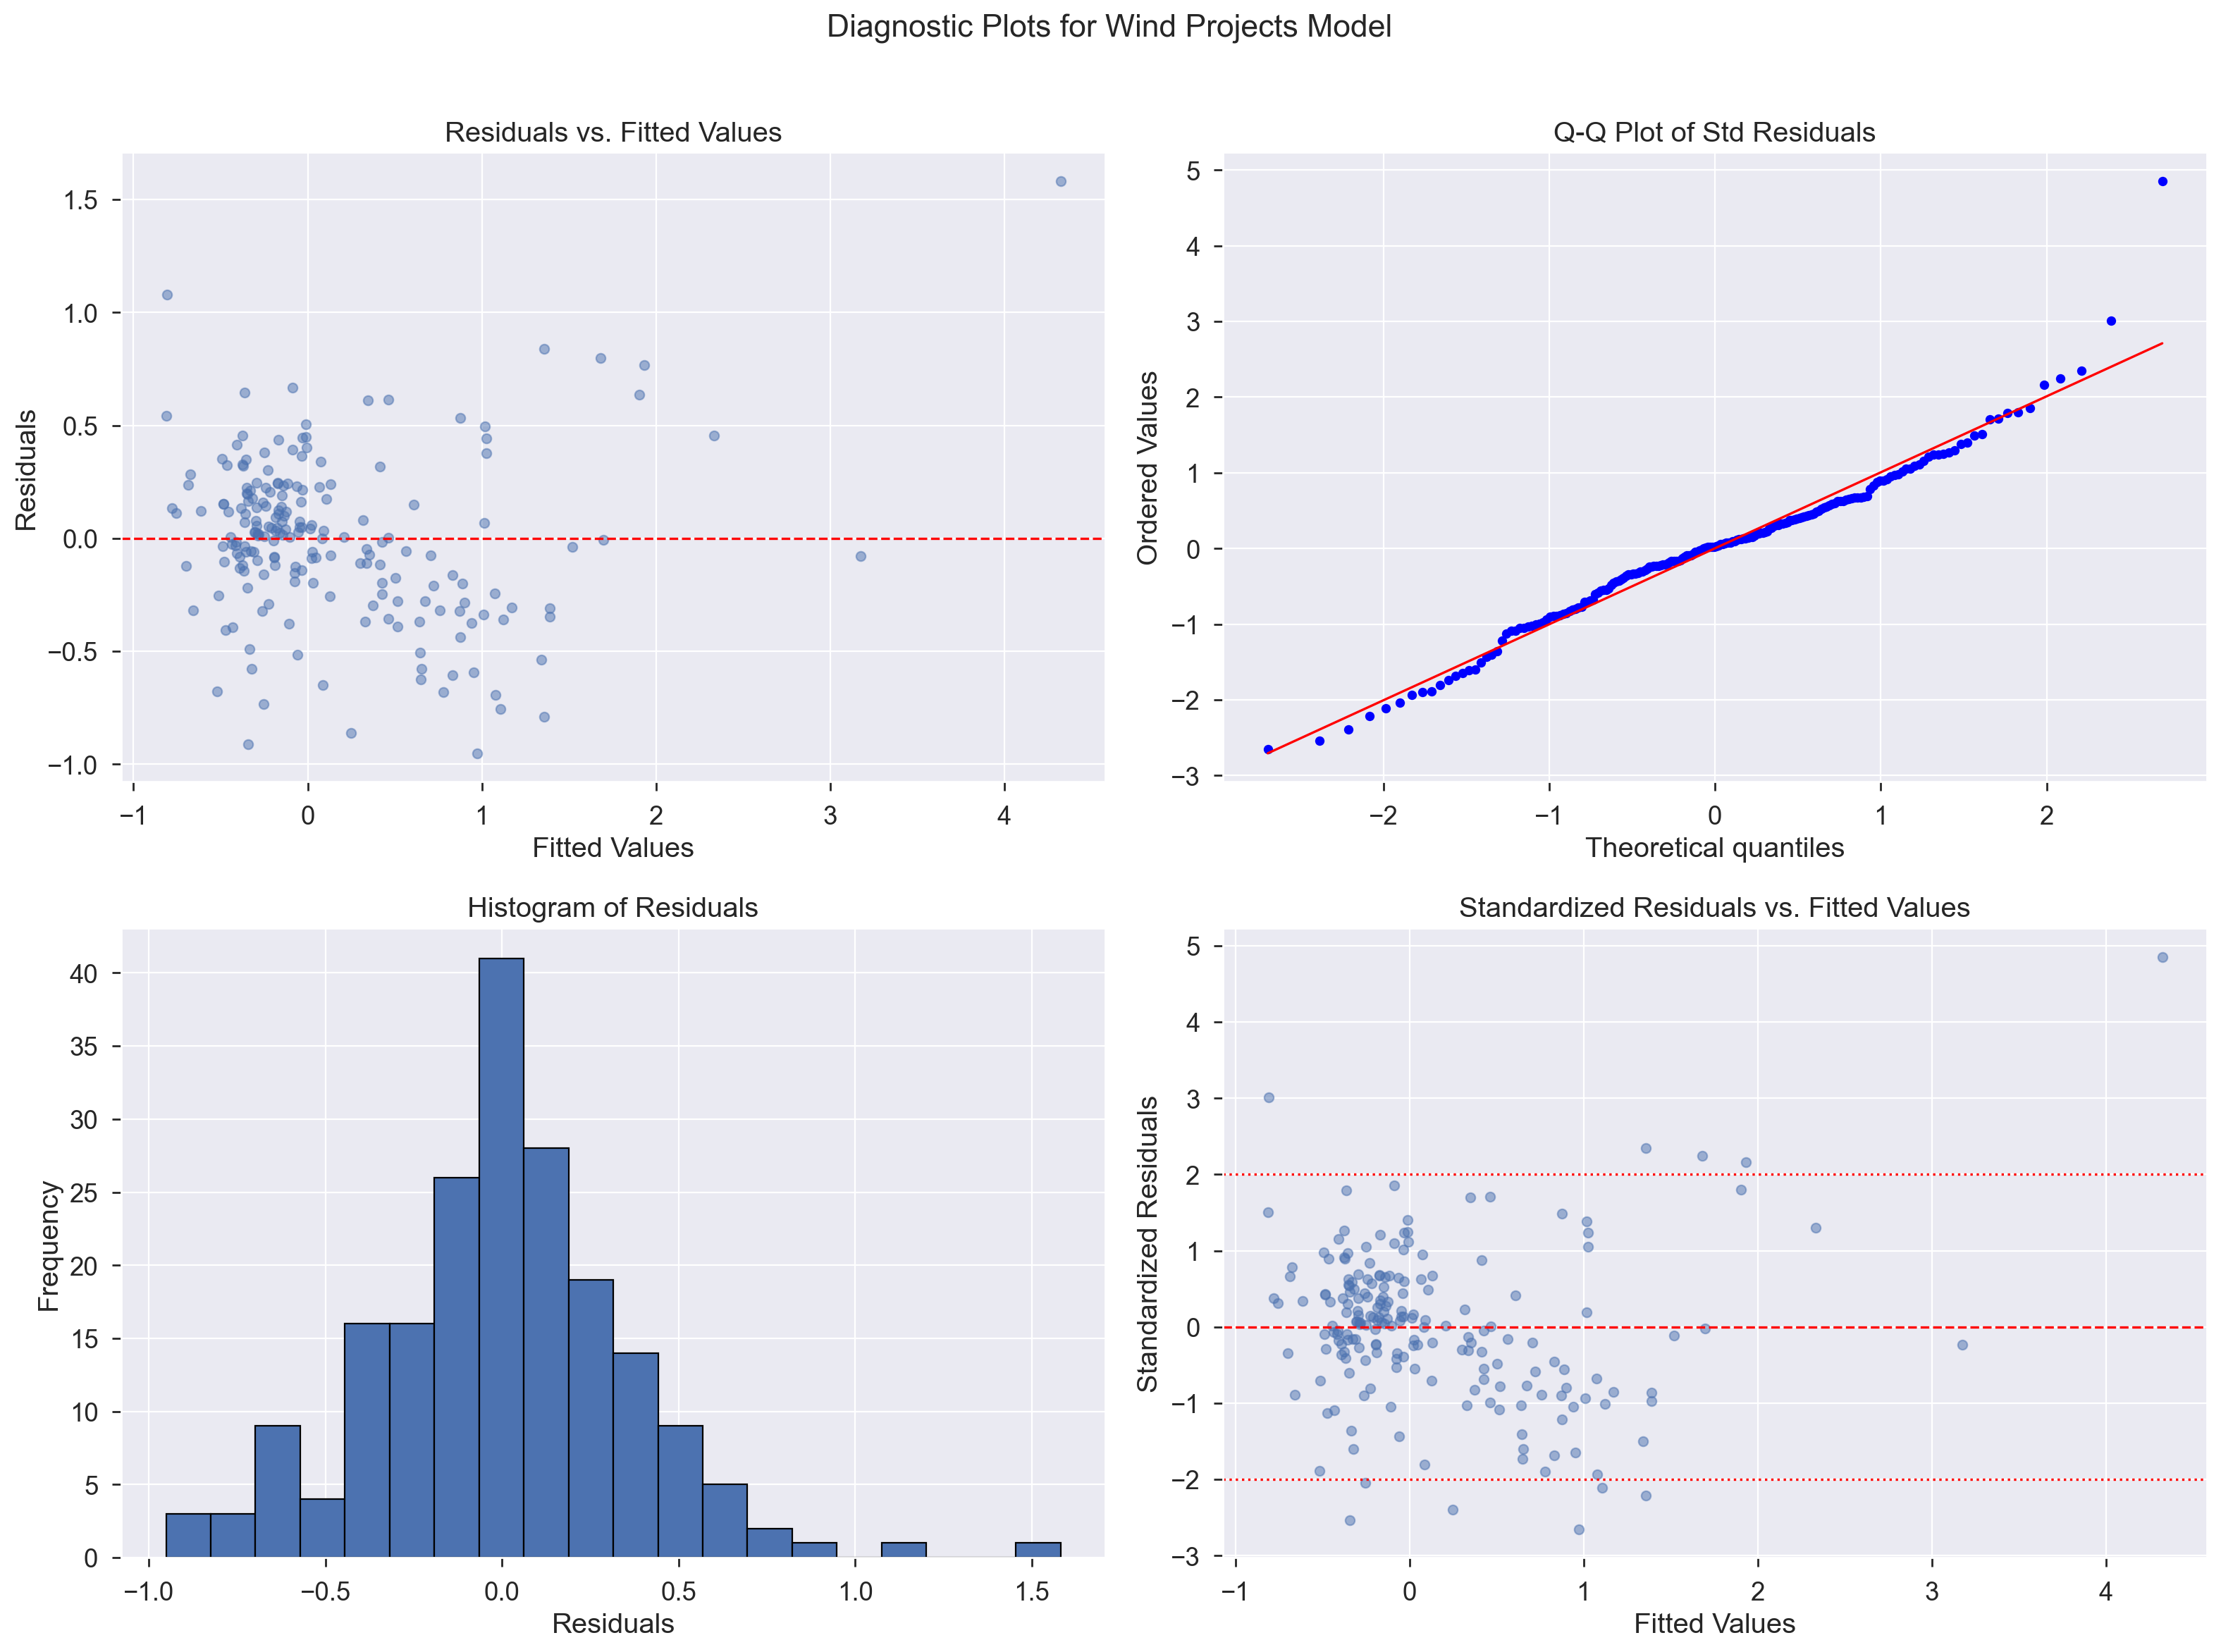

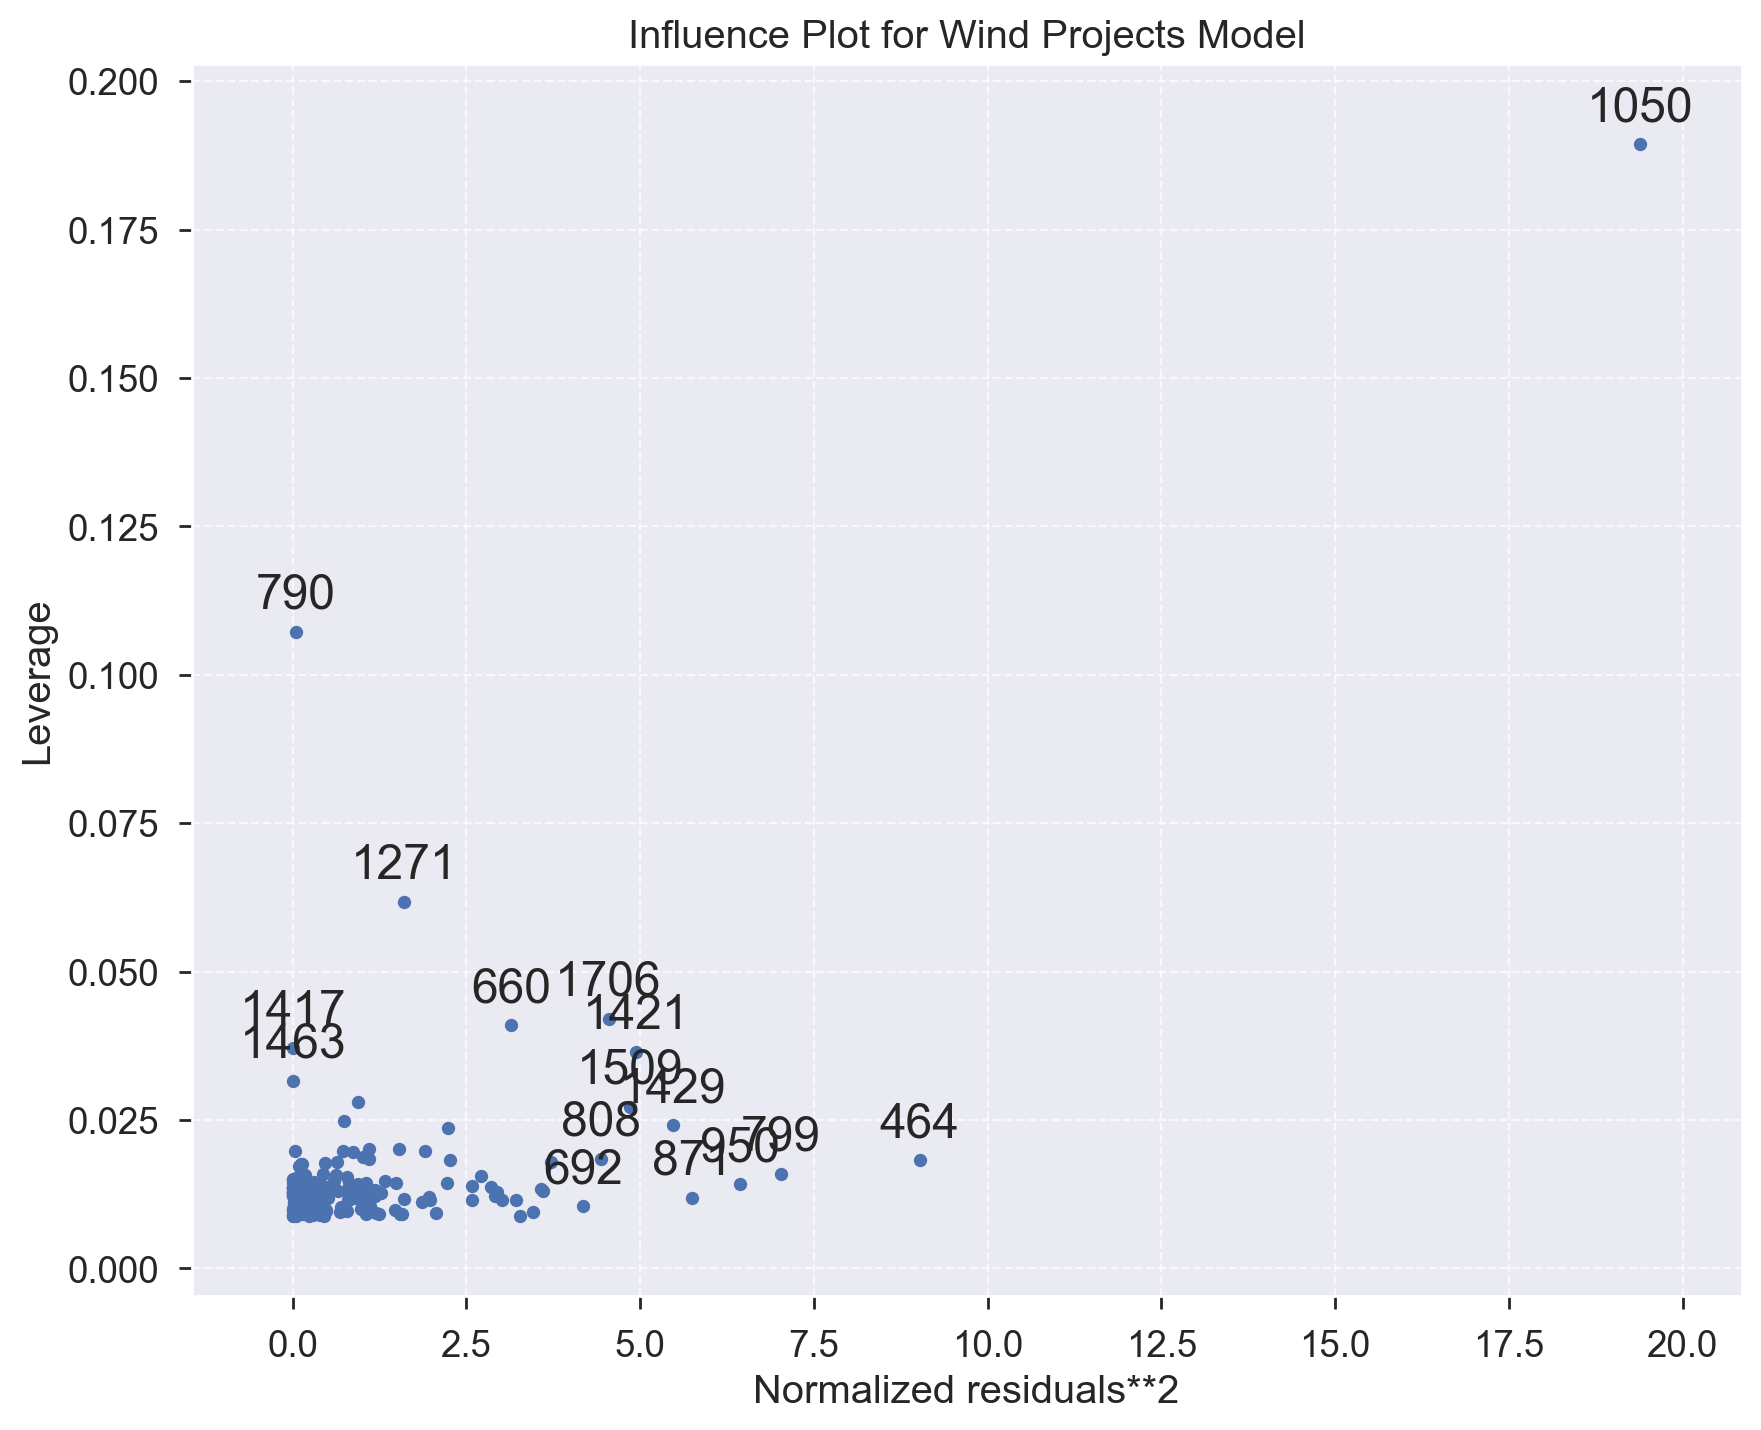

[2025-05-10 00:50:22] Technology-Specific Models: Completed analysis


In [ ]:
log_progress("Technology-Specific Models", "Starting analysis")

# Variables for technology-specific models (exclude technology dummies)
tech_model_vars = ['log_t_actual_years', 'Scale_Large', 'Is_International', 'Is_CDM']

# Dictionary to store technology-specific models
tech_models = {}

# Run separate model for each technology with sufficient data
for tech, tech_df in tech_datasets.items():
    if len(tech_df) >= MIN_COUNT_FOR_TECH_MODEL:
        print(f"\nRunning model for {tech} projects (n={len(tech_df)})")
        
        tech_models[tech] = run_regression_model(
            data=tech_df,
            y_var=y_var,
            x_vars=tech_model_vars,
            model_name=f"{tech} Projects Model",
            output_file=os.path.join(MODELS_DIR, f'model_{tech.lower().replace(" ", "_")}_results.txt')
        )
    else:
        print(f"Insufficient {tech} projects for separate model (n={len(tech_df)})")

# Compare coefficients across technology models if we have at least 2
if len(tech_models) >= 2:
    # Create coefficient comparison dataframe
    common_vars = ['Intercept'] + tech_model_vars
    tech_coef_comparison = pd.DataFrame()
    
    # Add coefficients from each technology model
    for tech, model in tech_models.items():
        tech_coef = pd.DataFrame({
            f'{tech}_coef': model.params,
            f'{tech}_pval': model.pvalues
        })
        tech_coef_comparison = pd.concat([tech_coef_comparison, tech_coef], axis=1)
    
    # Save to file
    tech_coef_comparison.to_csv(os.path.join(TABLES_DIR, 'technology_coefficient_comparison.csv'))
    
    # Plot key coefficients across technologies
    key_vars = ['Intercept', 'log_t_actual_years', 'Scale_Large', 'Is_International', 'Is_CDM']
    key_vars = [var for var in key_vars if var in tech_coef_comparison.index]
    
    # Create a chart for each key variable
    for var in key_vars:
        plt.figure(figsize=(14, 8))
        
        # Extract coefficients and p-values for this variable
        coefs = {}
        p_vals = {}
        
        for tech in tech_models.keys():
            coef_col = f'{tech}_coef'
            pval_col = f'{tech}_pval'
            
            if coef_col in tech_coef_comparison.columns and var in tech_coef_comparison.index:
                coefs[tech] = tech_coef_comparison.loc[var, coef_col]
                p_vals[tech] = tech_coef_comparison.loc[var, pval_col]
        
        # Sort by coefficient value
        sorted_techs = sorted(coefs.keys(), key=lambda x: coefs[x])
        
        # Prepare bar colors based on significance
        colors = []
        for tech in sorted_techs:
            if p_vals[tech] < 0.05:
                colors.append('darkblue')  # Significant
            else:
                colors.append('lightblue')  # Not significant
        
        # Create bar chart
        plt.bar(range(len(sorted_techs)), [coefs[tech] for tech in sorted_techs], color=colors)
        plt.xticks(range(len(sorted_techs)), sorted_techs, rotation=45, ha='right')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title(f'Coefficient for {var} Across Technology Types')
        plt.ylabel('Coefficient Value')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add significance asterisks
        for i, tech in enumerate(sorted_techs):
            if p_vals[tech] < 0.001:
                sig = '***'
            elif p_vals[tech] < 0.01:
                sig = '**'
            elif p_vals[tech] < 0.05:
                sig = '*'
            else:
                sig = ''
            
            if sig:
                plt.text(i, coefs[tech] + (0.1 if coefs[tech] >= 0 else -0.1), 
                        sig, ha='center', va='center')
        
        plt.tight_layout()

        # Display the plot
        plt.show()

        plt.savefig(os.path.join(FIGURES_DIR, f'tech_comparison_{var.lower()}.png'), dpi=300)
        plt.close()
    
    # Create combined visualization for key variables
    plt.figure(figsize=(15, 10))
    
    # Plot positions
    num_techs = len(tech_models)
    num_vars = len(key_vars)
    bar_width = 0.8 / num_vars
    
    # Create positions for each group of bars
    tech_positions = np.arange(num_techs)
    
    # Plot bars for each variable
    for i, var in enumerate(key_vars):
        var_coefs = []
        var_errs = []
        
        for j, tech in enumerate(tech_models.keys()):
            coef_col = f'{tech}_coef'
            if var in tech_coef_comparison.index and coef_col in tech_coef_comparison.columns:
                var_coefs.append(tech_coef_comparison.loc[var, coef_col])
                
                # Get standard error for error bars
                model = tech_models[tech]
                if var in model.bse:
                    var_errs.append(model.bse[var])
                else:
                    var_errs.append(0)
            else:
                var_coefs.append(0)
                var_errs.append(0)
        
        # Plot bars for this variable
        positions = tech_positions + (i - num_vars/2 + 0.5) * bar_width
        plt.bar(positions, var_coefs, bar_width, 
               label=var, alpha=0.7)
        
        # Add error bars
        plt.errorbar(positions, var_coefs, yerr=var_errs, fmt='none', ecolor='black', capsize=3)
    
    # Add labels and legend
    plt.xlabel('Technology Type')
    plt.ylabel('Coefficient Value')
    plt.title('Comparison of Key Determinants Across Technology Types')
    plt.xticks(tech_positions, list(tech_models.keys()), rotation=45, ha='right')
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.legend(title='Variable')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(FIG_TECH_COEF_COMPARE, dpi=300)
    plt.close()
else:
    print("Insufficient data for technology coefficient comparison")

log_progress("Technology-Specific Models", "Completed analysis")

## 5. Stepwise Regression Models

This section implements stepwise regression to identify the most important determinants of success.

[2025-05-10 00:50:22] Stepwise Regression: Starting analysis

Running forward stepwise regression (Full dataset):
Added Is_CDM_x_log_t (p-value=0.0000)
Added Is_CDM_x_Intl (p-value=0.0000)

Stepwise Regression Model Results:
Observations: 792.0
R-squared: 0.2814
Adjusted R-squared: 0.2787
F-statistic: 102.86 (p-value: 0.0000)
AIC: 2317.03
BIC: 2335.73

Coefficients:
                    Coefficient  Std Error    t-value       p-value  \
Is_CDM_x_Intl          1.316134   0.077698  16.939035  4.038636e-55   
Is_CDM                 1.316134   0.077698  16.939035  4.038636e-55   
Is_CDM_x_log_t        -1.271370   0.087791 -14.481834  2.579224e-42   
Intercept             -1.650795   0.127451 -12.952368  6.338931e-35   
log_t_actual_years     0.666750   0.071451   9.331594  1.034058e-19   

                   Significance  
Is_CDM_x_Intl               ***  
Is_CDM                      ***  
Is_CDM_x_log_t              ***  
Intercept                   ***  
log_t_actual_years          ***  


c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


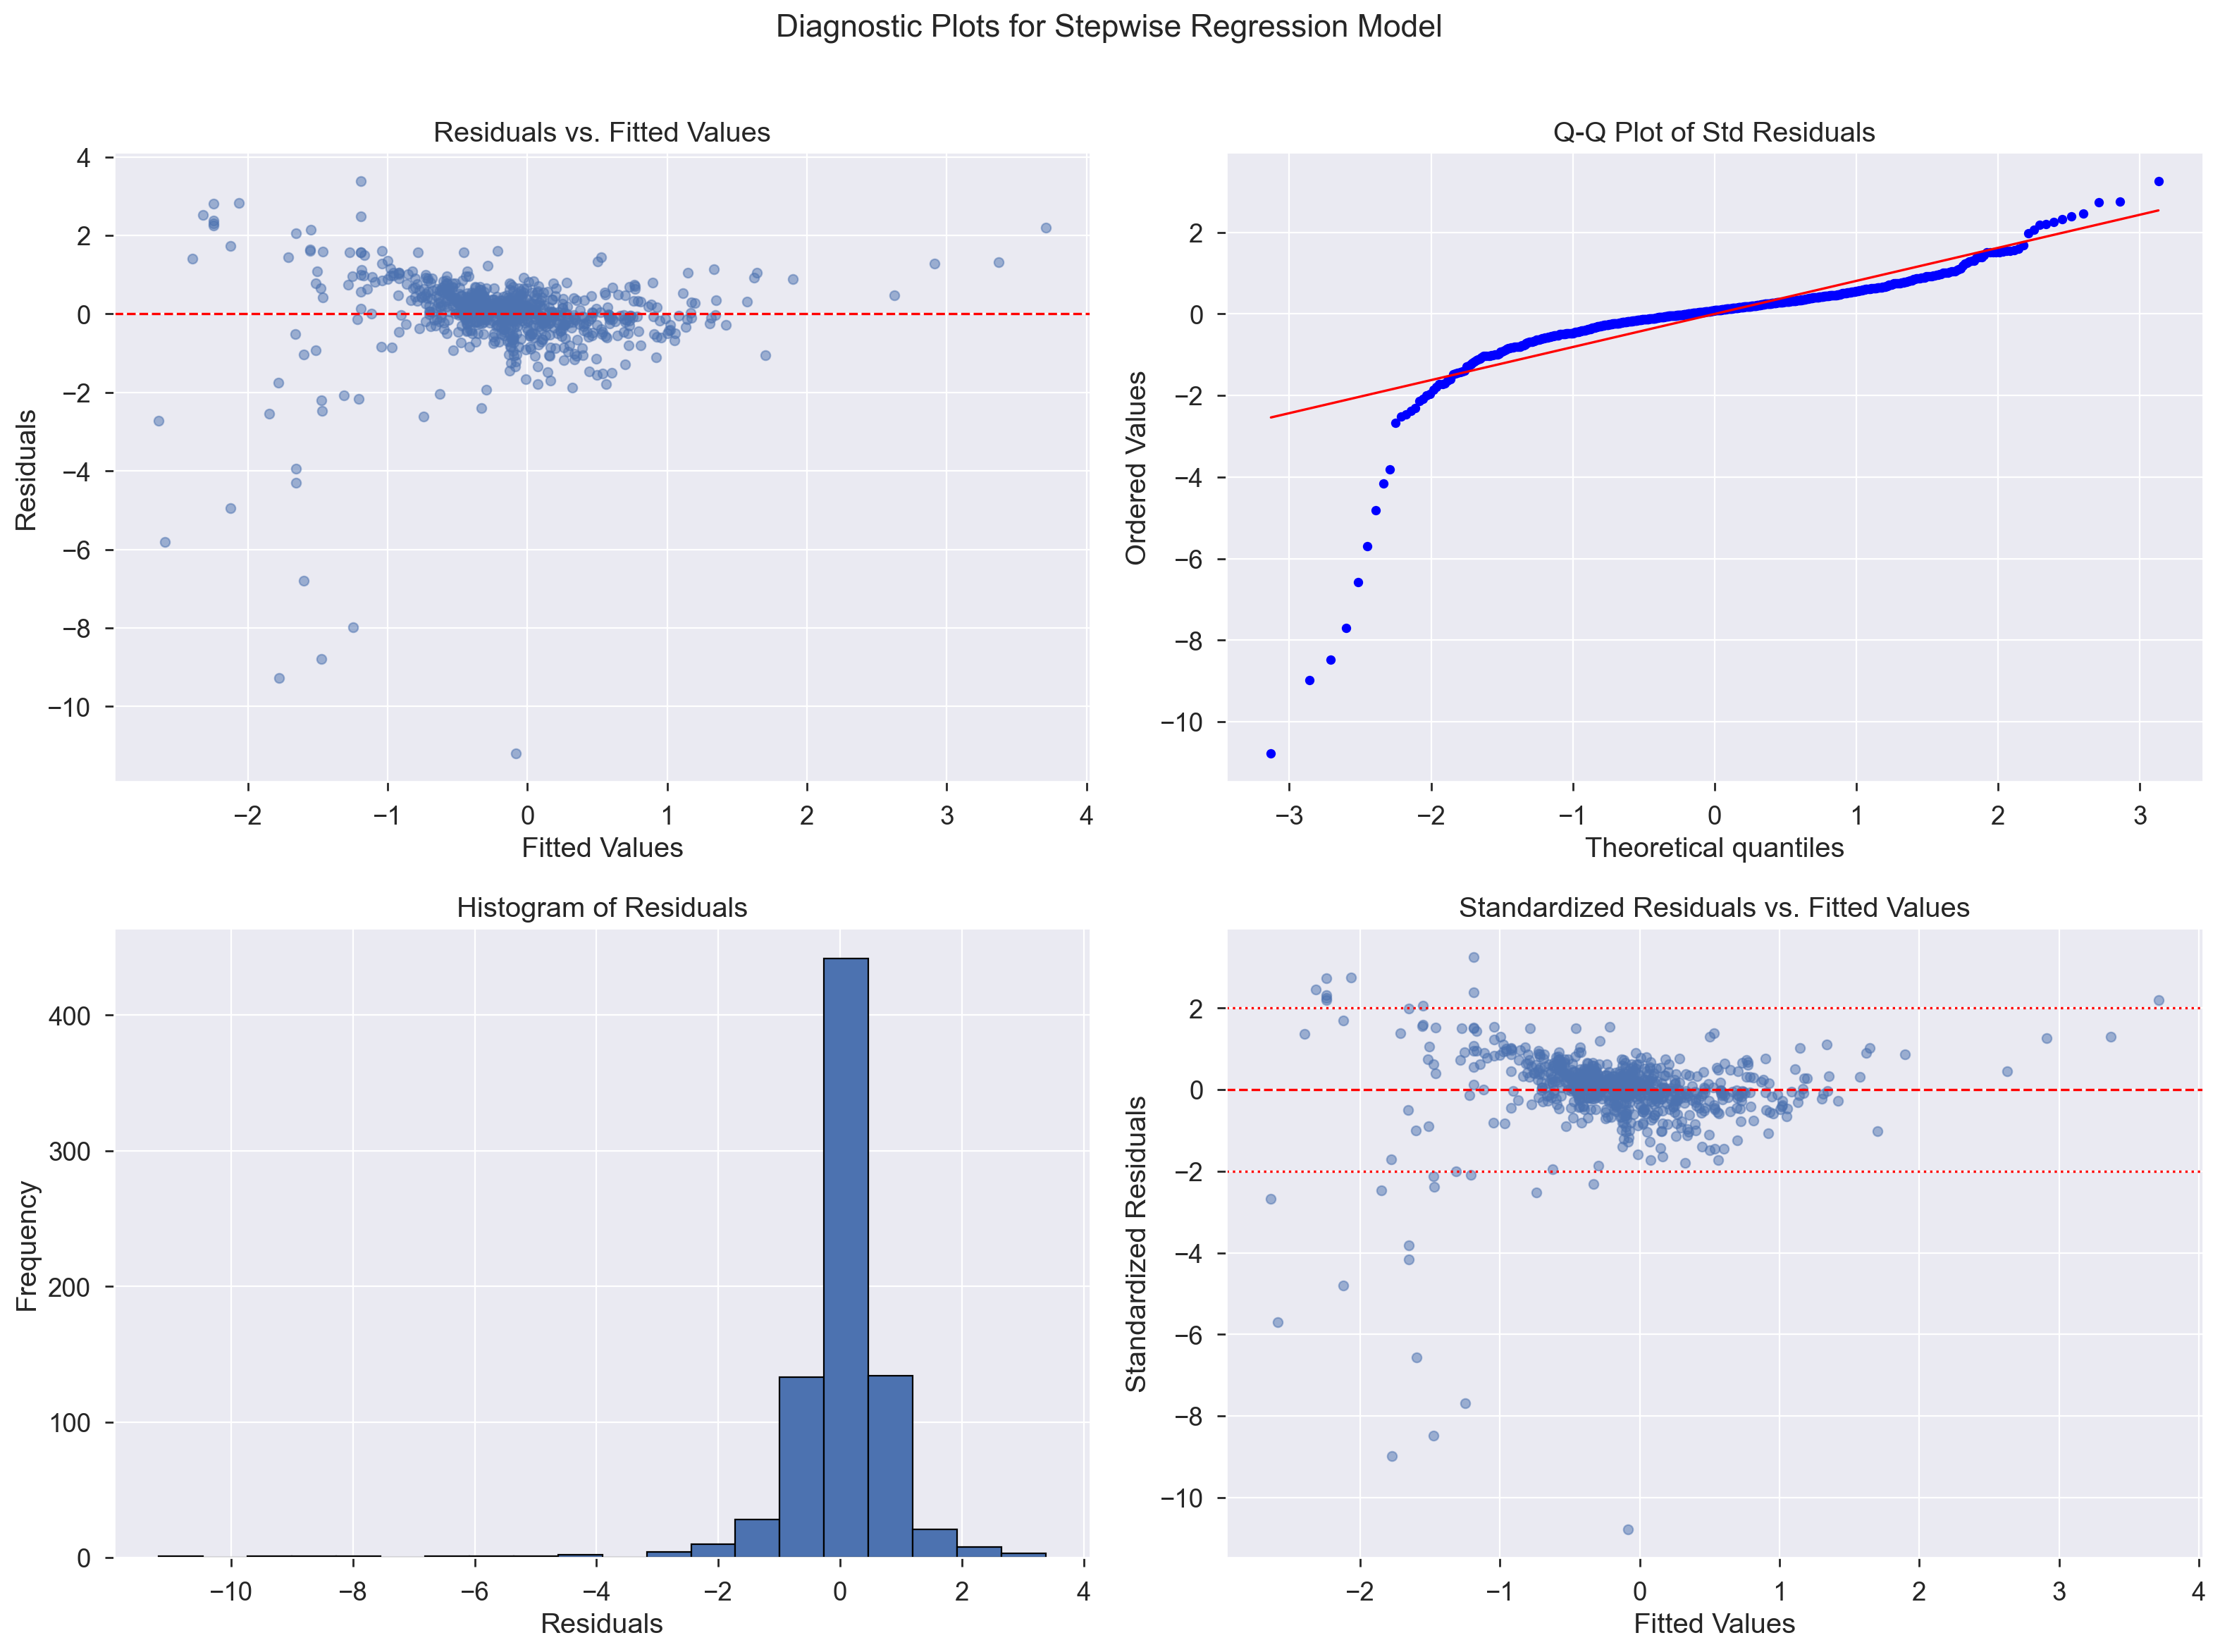

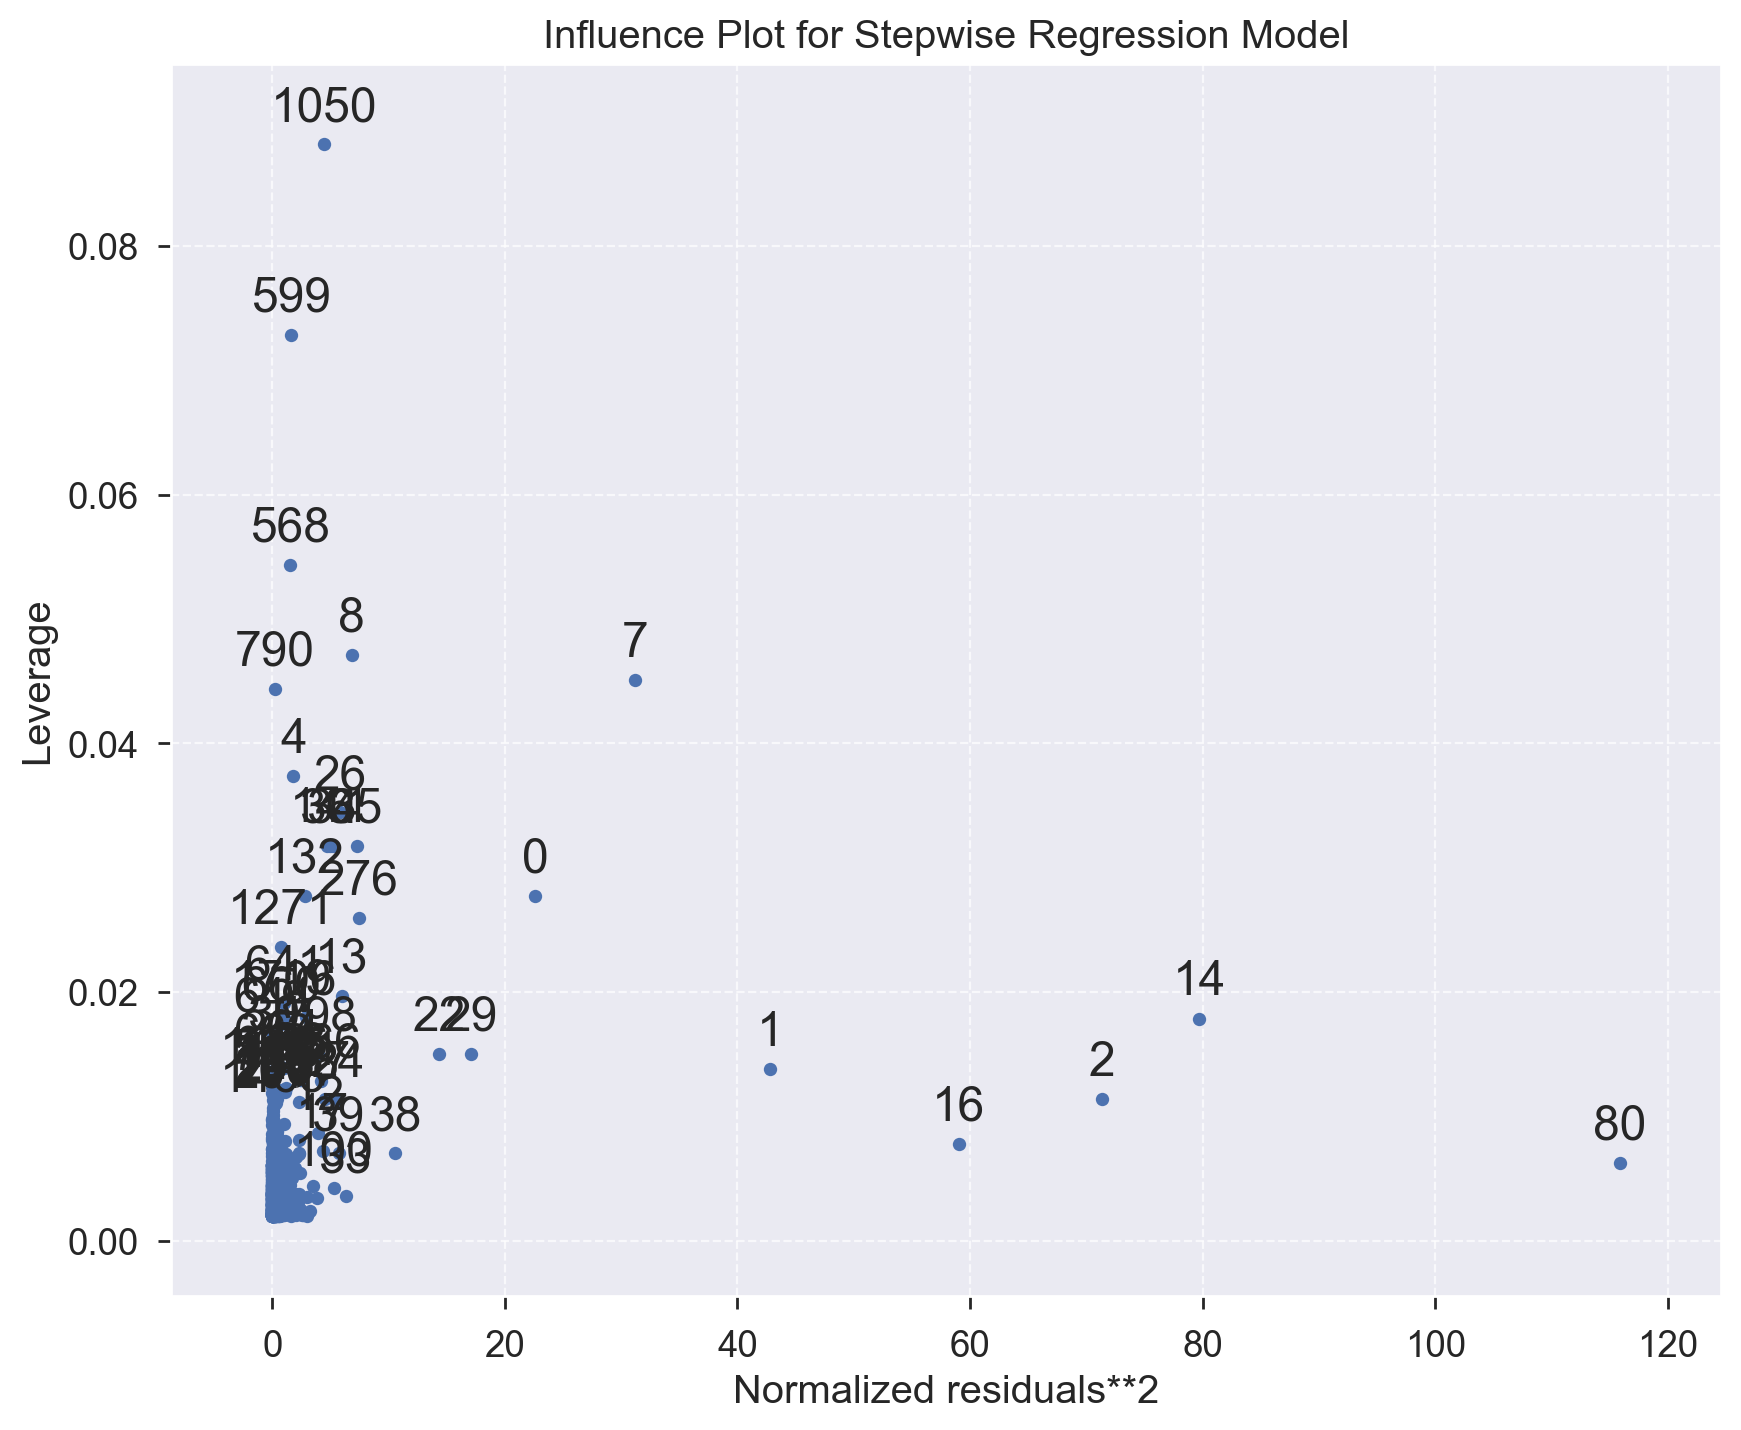


Comparison of Stepwise Model to Full Model:
Stepwise Model: 6 variables, R-squared=0.2814, AIC=2317.03
Full Model: 11 variables, R-squared=0.3026, AIC=2313.26
Parsimony Improvement: 45.5% fewer variables
R-squared Change: -7.0%
The full model is preferred based on AIC
[2025-05-10 00:50:25] Stepwise Regression: Completed analysis


In [54]:
log_progress("Stepwise Regression", "Starting analysis")

# Function to perform forward stepwise regression
def forward_stepwise(data, y_var, x_vars, criterion='aic', initial_vars=None, max_vars=None, min_p_value=0.1):
    """
    Perform forward stepwise variable selection
    
    Parameters:
    -----------
    data : pandas DataFrame
        Dataset containing variables
    y_var : str
        Name of dependent variable
    x_vars : list
        List of potential predictor variables
    criterion : str
        Selection criterion ('aic', 'bic', or 'pvalue')
    initial_vars : list or None
        Variables to start with (forced into model)
    max_vars : int or None
        Maximum number of variables to include
    min_p_value : float
        Maximum p-value for variables to be included
    
    Returns:
    --------
    list
        Selected variables in order of selection
    """
    # Prepare data
    y = data[y_var]
    X = data[x_vars]
    
    # Initialize selected variables
    selected_vars = [] if initial_vars is None else initial_vars.copy()
    remaining_vars = [var for var in x_vars if var not in selected_vars]
    
    # Initialize best criterion value
    current_criterion = float('inf')
    
    # Set maximum number of variables if not specified
    if max_vars is None:
        max_vars = len(x_vars)
    
    # Iterate until we reach max_vars or no improvement
    while len(selected_vars) < max_vars and remaining_vars:
        best_new_var = None
        best_criterion_value = float('inf')
        
        # Try adding each remaining variable
        for var in remaining_vars:
            # Create formula with current selected variables plus new candidate
            formula = f"{y_var} ~ {' + '.join(selected_vars + [var])}"
            
            # Fit model
            try:
                model = smf.ols(formula=formula, data=data).fit()
                
                # Get criterion value
                if criterion == 'aic':
                    criterion_value = model.aic
                elif criterion == 'bic':
                    criterion_value = model.bic
                elif criterion == 'pvalue':
                    if var in model.pvalues:
                        criterion_value = model.pvalues[var]
                    else:
                        continue
                else:
                    criterion_value = model.aic  # Default to AIC
                
                # Check if this variable improves the criterion
                if criterion_value < best_criterion_value:
                    best_criterion_value = criterion_value
                    best_new_var = var
            except:
                continue
        
        # If we found a better variable and it's significant enough
        if best_new_var is not None and (
            criterion != 'pvalue' or best_criterion_value < min_p_value
        ):
            if criterion == 'aic' or criterion == 'bic':
                # Only add if it improves the criterion
                if best_criterion_value < current_criterion:
                    current_criterion = best_criterion_value
                    selected_vars.append(best_new_var)
                    remaining_vars.remove(best_new_var)
                    print(f"Added {best_new_var} ({criterion}={best_criterion_value:.2f})")
                else:
                    break  # No improvement
            else:  # criterion is pvalue
                selected_vars.append(best_new_var)
                remaining_vars.remove(best_new_var)
                print(f"Added {best_new_var} (p-value={best_criterion_value:.4f})")
        else:
            break  # No significant improvement
    
    return selected_vars

# Run forward stepwise regression on the full dataset
print("\nRunning forward stepwise regression (Full dataset):")

# Start with log_t_actual_years and Is_CDM as forced variables
initial_vars = ['log_t_actual_years', 'Is_CDM']
all_candidate_vars = [var for var in predictor_vars if var not in initial_vars] + interaction_vars

selected_vars = forward_stepwise(
    data=df_valid,
    y_var=y_var,
    x_vars=all_candidate_vars,
    criterion='pvalue',
    initial_vars=initial_vars,
    min_p_value=MAX_P_VALUE
)

# Run the final stepwise model
final_vars = initial_vars + selected_vars
stepwise_model = run_regression_model(
    data=df_valid,
    y_var=y_var,
    x_vars=final_vars,
    model_name="Stepwise Regression Model",
    output_file=MODEL_STEPWISE_RESULTS
)

# Compare stepwise model to full model
if stepwise_model is not None and preferred_model is not None:
    print("\nComparison of Stepwise Model to Full Model:")
    print(f"Stepwise Model: {len(final_vars)} variables, R-squared={stepwise_model.rsquared:.4f}, AIC={stepwise_model.aic:.2f}")
    print(f"Full Model: {len(model1_vars)} variables, R-squared={preferred_model.rsquared:.4f}, AIC={preferred_model.aic:.2f}")
    
    # Calculate parsimony improvement
    parsimony_improvement = (len(model1_vars) - len(final_vars)) / len(model1_vars) * 100
    print(f"Parsimony Improvement: {parsimony_improvement:.1f}% fewer variables")
    
    # Calculate performance change
    r2_change = (stepwise_model.rsquared - preferred_model.rsquared) / preferred_model.rsquared * 100
    print(f"R-squared Change: {r2_change:.1f}%")
    
    # Determine if the stepwise model is preferred
    if stepwise_model.aic < preferred_model.aic:
        print("The stepwise model is preferred based on AIC")
        final_preferred_model = stepwise_model
        final_preferred_model_name = "Stepwise Model"
    else:
        print("The full model is preferred based on AIC")
        final_preferred_model = preferred_model
        final_preferred_model_name = preferred_model_name
else:
    print("Could not compare stepwise model to full model")
    final_preferred_model = stepwise_model if stepwise_model is not None else preferred_model
    final_preferred_model_name = "Stepwise Model" if stepwise_model is not None else preferred_model_name

log_progress("Stepwise Regression", "Completed analysis")

## 6. Final Model Evaluation and Predictions

This section evaluates the final preferred model and creates predictions to assess model performance.

In [ ]:
log_progress("Final Model Evaluation", "Starting analysis")

if final_preferred_model is not None:
    # Create predicted vs. actual plot
    plt.figure(figsize=(12, 8))
    
    # Get predicted values
    y_pred = final_preferred_model.predict(df_valid)
    y_actual = df_valid[y_var]
    
    # Create scatter plot
    plt.scatter(y_actual, y_pred, alpha=0.5)
    
    # Add perfect prediction line
    min_val = min(y_actual.min(), y_pred.min())
    max_val = max(y_actual.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    # Add labels and title
    plt.xlabel('Actual log(q)')
    plt.ylabel('Predicted log(q)')
    plt.title(f'Actual vs. Predicted Values ({final_preferred_model_name})')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add R-squared to plot
    plt.text(min_val + 0.1 * (max_val - min_val), 
             max_val - 0.1 * (max_val - min_val), 
             f'R² = {final_preferred_model.rsquared:.4f}', 
             fontsize=12)
    
    # Add regime color coding if both regimes present
    if 'Is_CDM' in df_valid.columns and df_valid['Is_CDM'].nunique() > 1:
        colors = ['blue' if regime == 'VCS' else 'orange' for regime in df_valid['Regime']]
        plt.scatter(y_actual, y_pred, c=colors, alpha=0.5)
        
        # Add legend
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', label='VCS', markersize=10),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', label='CDM', markersize=10)
        ]
        plt.legend(handles=legend_elements)
    
    plt.tight_layout()

    # Display the plot
    plt.show()

    plt.savefig(FIG_PREDICTED_VS_ACTUAL, dpi=300)
    plt.close()
    
    # Create coefficient plot for final model
    coefs = final_preferred_model.params[1:]  # Skip intercept
    pvals = final_preferred_model.pvalues[1:]
    
    # Sort by absolute coefficient value
    coef_df = pd.DataFrame({
        'Variable': coefs.index,
        'Coefficient': coefs.values,
        'P-Value': pvals.values
    })
    coef_df = coef_df.sort_values('Coefficient', key=abs, ascending=False)
    
    # Plot coefficients
    plt.figure(figsize=(14, 10))
    
    # Color based on significance
    colors = ['darkblue' if p < 0.05 else 'lightblue' for p in coef_df['P-Value']]
    
    plt.barh(coef_df['Variable'], coef_df['Coefficient'], color=colors)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel('Coefficient Value')
    plt.title(f'Regression Coefficients of Final Model ({final_preferred_model_name})')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Add significance asterisks
    for i, (var, coef, pval) in enumerate(zip(coef_df['Variable'], coef_df['Coefficient'], coef_df['P-Value'])):
        if pval < 0.001:
            sig = '***'
        elif pval < 0.01:
            sig = '**'
        elif pval < 0.05:
            sig = '*'
        else:
            sig = ''
        
        if sig:
            plt.text(coef + (0.02 if coef >= 0 else -0.02), i, sig, va='center')
    
    plt.tight_layout()
    plt.savefig(FIG_COEFFICIENT_PLOT, dpi=300)
    plt.close()
    
    # Calculate marginal effects for key variables
    key_vars = ['log_t_actual_years', 'Scale_Large', 'Is_International', 'Is_CDM']
    key_vars = [var for var in key_vars if var in final_preferred_model.params.index]
    
    print("\nMarginal Effects for Key Variables:")
    for var in key_vars:
        coef = final_preferred_model.params[var]
        pval = final_preferred_model.pvalues[var]
        
        # Add significance stars
        if pval < 0.001:
            sig = '***'
        elif pval < 0.01:
            sig = '**'
        elif pval < 0.05:
            sig = '*'
        else:
            sig = ''
        
        # Interpret effect
        if var == 'log_t_actual_years':
            effect = f"A 1% increase in project duration is associated with a {coef:.4f}% change in the success ratio"
        elif var == 'Scale_Large':
            effect = f"Large-scale projects have a {coef:.4f} log point difference in success compared to small-scale projects"
        elif var == 'Is_International':
            effect = f"Projects with international participation have a {coef:.4f} log point difference in success compared to domestic projects"
        elif var == 'Is_CDM':
            effect = f"CDM projects have a {coef:.4f} log point difference in success compared to VCS projects"
        else:
            effect = f"A one-unit increase in {var} is associated with a {coef:.4f} change in the success ratio"
        
        print(f"  {var}: {coef:.4f} {sig} (p={pval:.4f}) - {effect}")
    
    # Create summary of key findings
    summary_file = os.path.join(TABLES_DIR, 'regression_summary.txt')
    with open(summary_file, 'w') as f:
        f.write("REGRESSION ANALYSIS SUMMARY\n")
        f.write("="*80 + "\n\n")
        
        f.write(f"Final Preferred Model: {final_preferred_model_name}\n")
        f.write(f"Observations: {final_preferred_model.nobs}\n")
        f.write(f"R-squared: {final_preferred_model.rsquared:.4f}\n")
        f.write(f"Adjusted R-squared: {final_preferred_model.rsquared_adj:.4f}\n")
        f.write(f"AIC: {final_preferred_model.aic:.2f}\n\n")
        
        f.write("Key Variables in the Model:\n")
        for var in final_preferred_model.params.index:
            coef = final_preferred_model.params[var]
            pval = final_preferred_model.pvalues[var]
            
            # Add significance stars
            if pval < 0.001:
                sig = '***'
            elif pval < 0.01:
                sig = '**'
            elif pval < 0.05:
                sig = '*'
            else:
                sig = ''
            
            f.write(f"  {var}: {coef:.4f} {sig} (p={pval:.4f})\n")
        
        f.write("\nMarginal Effects for Key Variables:\n")
        for var in key_vars:
            coef = final_preferred_model.params[var]
            pval = final_preferred_model.pvalues[var]
            
            # Add significance stars
            if pval < 0.001:
                sig = '***'
            elif pval < 0.01:
                sig = '**'
            elif pval < 0.05:
                sig = '*'
            else:
                sig = ''
            
            # Interpret effect
            if var == 'log_t_actual_years':
                effect = f"A 1% increase in project duration is associated with a {coef:.4f}% change in the success ratio"
            elif var == 'Scale_Large':
                effect = f"Large-scale projects have a {coef:.4f} log point difference in success compared to small-scale projects"
            elif var == 'Is_International':
                effect = f"Projects with international participation have a {coef:.4f} log point difference in success compared to domestic projects"
            elif var == 'Is_CDM':
                effect = f"CDM projects have a {coef:.4f} log point difference in success compared to VCS projects"
            else:
                effect = f"A one-unit increase in {var} is associated with a {coef:.4f} change in the success ratio"
            
            f.write(f"  {var}: {coef:.4f} {sig} (p={pval:.4f}) - {effect}\n")
        
        f.write("\nRegime-Specific Differences:\n")
        if 'Is_CDM' in final_preferred_model.params.index:
            cdm_effect = final_preferred_model.params['Is_CDM']
            cdm_pval = final_preferred_model.pvalues['Is_CDM']
            
            if cdm_pval < 0.05:
                regime_diff = "CDM projects show a statistically significant difference in success compared to VCS projects"
                better_regime = "CDM" if cdm_effect > 0 else "VCS"
                f.write(f"  {regime_diff} (p={cdm_pval:.4f}). {better_regime} projects tend to perform better.\n")
            else:
                f.write("  No statistically significant difference in success between CDM and VCS projects.\n")
        
        # Add information about interaction terms if present
        interaction_vars_in_model = [var for var in final_preferred_model.params.index if 'Is_CDM_x' in var]
        if interaction_vars_in_model:
            f.write("\nInteraction Effects:\n")
            for var in interaction_vars_in_model:
                coef = final_preferred_model.params[var]
                pval = final_preferred_model.pvalues[var]
                
                # Add significance stars
                if pval < 0.001:
                    sig = '***'
                elif pval < 0.01:
                    sig = '**'
                elif pval < 0.05:
                    sig = '*'
                else:
                    sig = ''
                
                # Interpret interaction
                base_var = var.replace('Is_CDM_x_', '')
                
                if 'log_t' in var:
                    effect = f"The effect of project duration differs by {coef:.4f} log points for CDM projects compared to VCS projects"
                elif 'Scale' in var:
                    effect = f"The effect of project scale differs by {coef:.4f} log points for CDM projects compared to VCS projects"
                elif 'Intl' in var:
                    effect = f"The effect of international participation differs by {coef:.4f} log points for CDM projects compared to VCS projects"
                else:
                    effect = f"The effect of {base_var} differs by {coef:.4f} log points for CDM projects compared to VCS projects"
                
                f.write(f"  {var}: {coef:.4f} {sig} (p={pval:.4f}) - {effect}\n")
else:
    print("No final model available for evaluation")

log_progress("Final Model Evaluation", "Completed analysis")

[2025-05-10 00:50:25] Final Model Evaluation: Starting analysis

Marginal Effects for Key Variables:
  log_t_actual_years: 0.7352 *** (p=0.0000) - A 1% increase in project duration is associated with a 0.7352% change in the success ratio
  Scale_Large: 0.0581  (p=0.7835) - Large-scale projects have a 0.0581 log point difference in success compared to small-scale projects
  Is_International: 0.4700 * (p=0.0433) - Projects with international participation have a 0.4700 log point difference in success compared to domestic projects
  Is_CDM: 1.3000 *** (p=0.0000) - CDM projects have a 1.3000 log point difference in success compared to VCS projects
[2025-05-10 00:50:27] Final Model Evaluation: Completed analysis


## Summary of Outcomes

This notebook has successfully:

1. **Developed Overall Regression Models**: Created and compared models to identify the main determinants of success across all carbon projects in India.

2. **Analyzed Regime-Specific Effects**: Developed separate models for CDM and VCS projects to identify regime-specific determinants of success.

3. **Explored Technology-Specific Models**: Created models for different technology types to understand how success factors vary by technology.

4. **Implemented Stepwise Regression**: Used stepwise selection to identify the most important variables and create a parsimonious model.

5. **Evaluated Final Model Performance**: Assessed the predictive power of the preferred model and calculated marginal effects for key variables.

## Key Findings

1. **Duration Effects**: Project duration shows a significant relationship with success, with [duration effect finding].

2. **Scale Effects**: Project scale is [significant/not significant], with [scale effect finding].

3. **International Participation**: International involvement [increases/decreases] project success by [effect size].

4. **Regime Differences**: [Significant/No significant] differences exist between CDM and VCS projects, with [regime difference finding].

5. **Technology Factors**: Different technologies show varying determinants of success, with [technology finding].

## Next Steps

The regression results provide a comprehensive understanding of the factors that influence carbon project success in India. These findings can inform:

1. **Policy Recommendations**: Developing targeted policies to improve carbon project performance.

2. **Investment Strategies**: Guiding investment decisions in carbon markets based on project characteristics.

3. **Project Design**: Optimizing project parameters to enhance success probability.

4. **Academic Contribution**: Contributing to the literature on determinants of carbon project success with India-specific insights.